In [1]:
import os
import importlib
import time

import numpy as np
import pandas as pd

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import skimage
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
#from torchvision import transforms
from torch.utils import data
from torch.utils.data.sampler import SubsetRandomSampler

import load_data
import model

In [2]:
plt.style.use('Solarize_Light2')
%matplotlib inline
importlib.reload(load_data)
importlib.reload(model)

<module 'model' from '/home/uldo/work/kaggle/competitions/Human_Protein_Atlas_Image_Classification/code/model.py'>

In [3]:
W = H = 256

BATCH_SIZE = 100

LABEL_NAMES_MAP = {
    0:  "Nucleoplasm",  
    1:  "Nuclear membrane",   
    2:  "Nucleoli",   
    3:  "Nucleoli fibrillar center",   
    4:  "Nuclear speckles",
    5:  "Nuclear bodies",   
    6:  "Endoplasmic reticulum",   
    7:  "Golgi apparatus",   
    8:  "Peroxisomes",   
    9:  "Endosomes",   
    10:  "Lysosomes",   
    11:  "Intermediate filaments",   
    12:  "Actin filaments",   
    13:  "Focal adhesion sites",   
    14:  "Microtubules",   
    15:  "Microtubule ends",   
    16:  "Cytokinetic bridge",   
    17:  "Mitotic spindle",   
    18:  "Microtubule organizing center",   
    19:  "Centrosome",   
    20:  "Lipid droplets",   
    21:  "Plasma membrane",   
    22:  "Cell junctions",   
    23:  "Mitochondria",   
    24:  "Aggresome",   
    25:  "Cytosol",   
    26:  "Cytoplasmic bodies",   
    27:  "Rods & rings"
}

In [4]:
def show(image, labels):
    f, (ax1,ax2,ax3,ax4) = plt.subplots(1, 4, figsize=(25,25), sharey=True)

    title = ""
    npimage = image.numpy()
    nplabels = labels.numpy()
    print(npimage.shape)
    print(nplabels)

    for i, label in enumerate(nplabels):
        if label == 1:
            if title == '':
                title += LABEL_NAMES_MAP[i]
            else:
                title += " & " + LABEL_NAMES_MAP[i]
    
    ax1.imshow(npimage[0,:,:],cmap="hot")
    ax1.set_title('Red')
    ax2.imshow(npimage[1,:,:],cmap="copper")
    ax2.set_title('Green')
    ax3.imshow(npimage[2,:,:],cmap="bone")
    ax3.set_title('Blue')
    ax4.imshow(npimage[3,:,:],cmap="afmhot")
    ax4.set_title('Yellow')
    f.suptitle(title, fontsize=20, y=0.62)
    

In [5]:
class HPA_ConvNeuralNet(nn.Module):
    
    def __init__(self):
        super(HPA_ConvNeuralNet, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(4, 8, 5, 1, 2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(8, 16, 5, 1, 2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.drop_out = nn.Dropout()
        self.out1 = nn.Linear(int(16 * W/4 * H/4), 900)
        self.out2 = nn.Linear(900, 28)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)
        output = self.drop_out(x)
        output = self.out1(x)
        output = self.out2(output)
        #return output, x
        return output

In [6]:
def init_weights(submodule):
    if type(submodule) == nn.Linear:
        nn.init.xavier_uniform_(submodule.weight)
        submodule.bias.data.fill_(0.01)

In [7]:
def prepare_loaders(dataset, valid_train_ratio=0.6):
    dataset_size = len(dataset)
    print("dataset_size: ", dataset_size)

    validation_subset_size = int(dataset_size * (1 - valid_train_ratio))
    print("validation_subset_size: ", validation_subset_size)

    indices = list(range(dataset_size))
    validation_indices = np.random.choice(indices, size=validation_subset_size, replace=False)
    train_indices = list(set(indices) - set(validation_indices))

    train_sampler = SubsetRandomSampler(train_indices)
    validation_sampler = SubsetRandomSampler(validation_indices)
    
    dataset_sizes = {
            'train': len(train_indices),
            'validation': len(validation_indices)
        }

    train_loader = data.DataLoader(dataset, batch_size=BATCH_SIZE, num_workers=1, sampler=train_sampler)
    validation_loader = data.DataLoader(dataset, batch_size=BATCH_SIZE, num_workers=1, sampler=validation_sampler)

    loaders = {
            'train': train_loader,
            'validation': validation_loader
        }

    return loaders, dataset_sizes

In [8]:
def test(model, validation_loader, validation_dataset_size, criterion):
    model.eval()
    with torch.no_grad():
        
        correct_predicted_total = 0.0
        total_loss = 0.0
        total = 0.0
        
        for inputs, labels in validation_loader:
            inputs = inputs.to(device, dtype=torch.float)
            
            labels = labels.to(device, dtype=torch.uint8)
            
            outputs = model(inputs)
            
            loss = criterion(outputs, labels)
            total_loss += loss.item() * inputs.size(0)
            
            predicted = outputs > 0

            total += labels.size(0)

            sum_of_correct_predicted = torch.sum((predicted == labels).all(1))
            item = sum_of_correct_predicted.item()

            correct_predicted_total += item

        print("total: ", total)
        accuracy = correct_predicted_total / total
        print(
                "Validation accuracy of the model on the {} validation images: {} ".format(
                    validation_dataset_size,
                    accuracy
                )
            )

    return accuracy

In [9]:
def validate(model, validation_loader, criterion):
    model.eval()
    with torch.no_grad():
        
        correct_predicted_total = 0.0
        total_loss = 0.0
        #total = 0.0
        
        for inputs, labels in validation_loader:
            inputs = inputs.to(device, dtype=torch.float)
            #labels_as_float = labels.to(device, dtype=torch.float)
            #labels = labels.to(device, dtype=torch.uint8)
            labels = labels.to(device, dtype=torch.float)
            outputs = model(inputs)
            
            loss = criterion(outputs, labels)
            #loss = criterion(outputs, labels_as_float)
            total_loss += loss.item() * inputs.size(0)
            
            predicted = outputs > 0

            #total += labels.size(0)
            labels = labels.data.byte()
            sum_of_correct_predicted = torch.sum((predicted == labels).all(1))
            item = sum_of_correct_predicted.item()

            correct_predicted_total += item

        #accuracy = correct_predicted_total / total
        accuracy = correct_predicted_total
        

    return (total_loss, accuracy)

In [10]:
def one_epoch_model_process(model, loader, criterion, optimizer=None):
    accuracy = 0.0
    total_loss = 0.0

    for inputs, labels in loader:
        inputs = inputs.to(device, dtype=torch.float)
        labels = labels.to(device, dtype=torch.float)
        outputs = model(inputs)
            
        loss = criterion(outputs, labels)
        if optimizer:
            loss.backward()
            optimizer.step()
        total_loss += loss.item() * inputs.size(0)
            
        predicted = outputs > 0

        labels = labels.data.byte()
        torch_sum_of_correct_predicted = torch.sum((predicted == labels).all(1))
        correct_predicted = torch_sum_of_correct_predicted.item()

        accuracy += correct_predicted        

    return (total_loss, accuracy)

In [11]:
def train_model(num_of_epoch, model, dataset_loaders, dataset_sizes, criterion, optimizer):
    torch.cuda.empty_cache()
    since = time.time()
    
    train_losses = []
    train_accuracies = []
    validation_losses = []
    validation_accuracies = []
    
    for epoch in range(num_of_epoch):
        pass   

In [61]:
def run_model(model, batch):
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    #inputs = batch
    #inputs = inputs.to(device, dtype=torch.float)
    inputs = batch.to(device, dtype=torch.float)
    outputs = model(inputs)
    #return outputs[0].cpu()
    return outputs.cpu()

In [13]:
def save_model(model, full=True, name='model'):
    if not full:
        torch.save(model.state_dict(), '{}_params.pkl'.format(name))
    else:
        torch.save(model, '{}.pkl'.format(name))
    return

In [14]:
def restore_model(name='model'):
    return torch.load('{}.pkl'.format(name))

In [15]:
train_df = load_data.load_text_data('../input/train.csv')

In [16]:
print(train_df.shape)

(31072, 2)


In [17]:
dataset = load_data.HumanProteinAtlasDataset(
    train_df,
    transform=load_data.transforms.ToTensor()
)

In [18]:
dataset_loaders, dataset_sizes = prepare_loaders(dataset)

dataset_size:  31072
validation_subset_size:  12428


In [19]:
train_loader = dataset_loaders['train']
validation_loader = dataset_loaders['validation']
train_dataset_size = dataset_sizes['train']
validation_dataset_size = dataset_sizes['validation']

In [20]:
print(train_dataset_size)
print(validation_dataset_size)

18644
12428


In [21]:
print(train_loader)

In [22]:
train_iter = iter(train_loader)

In [23]:
print(type(train_iter))

<class 'torch.utils.data.dataloader._DataLoaderIter'>


In [24]:
images, labels = train_iter.next()

In [25]:
print("images shape on batch size = {}".format(images.size()))
print("labels shape on batch size = {}".format(labels.size()))

images shape on batch size = torch.Size([100, 4, 256, 256])
labels shape on batch size = torch.Size([100, 28])


(4, 256, 256)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]


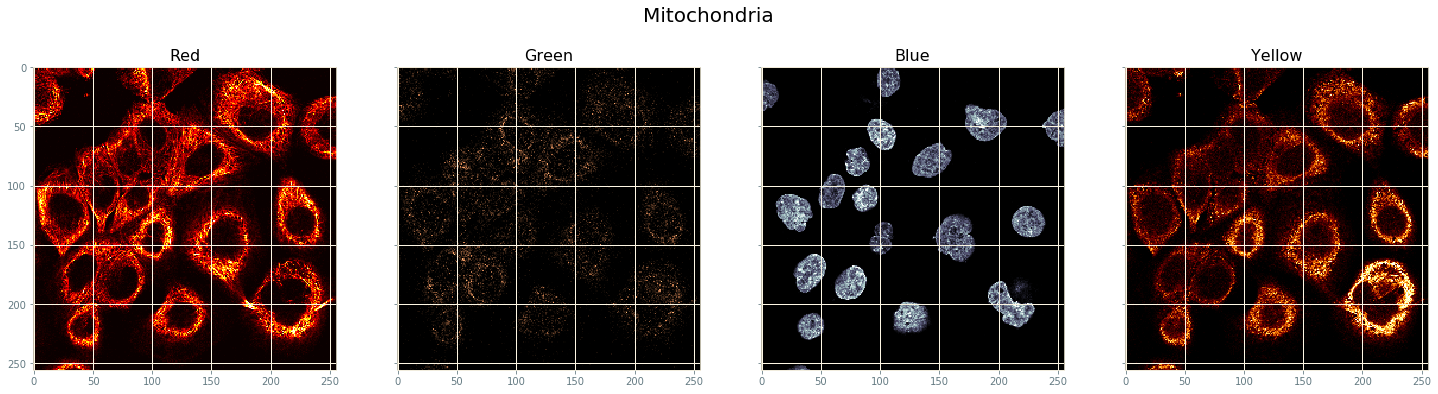

In [26]:
show(images[0], labels[0])

In [27]:
hpa_conv_neural_net = HPA_ConvNeuralNet()
hpa_conv_neural_net.apply(init_weights)

HPA_ConvNeuralNet(
  (conv1): Sequential(
    (0): Conv2d(4, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (drop_out): Dropout(p=0.5)
  (out1): Linear(in_features=65536, out_features=900, bias=True)
  (out2): Linear(in_features=900, out_features=28, bias=True)
)

In [28]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [29]:
print(device)

cuda:0


In [30]:
hpa_conv_neural_net.to(device)

HPA_ConvNeuralNet(
  (conv1): Sequential(
    (0): Conv2d(4, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (drop_out): Dropout(p=0.5)
  (out1): Linear(in_features=65536, out_features=900, bias=True)
  (out2): Linear(in_features=900, out_features=28, bias=True)
)

In [31]:
criterion=nn.BCEWithLogitsLoss(reduction='sum')
optimizer = optim.Adam(hpa_conv_neural_net.parameters(), lr=0.001, betas=(0.9, 0.99))

In [32]:
num_of_epoch = 12
train_losses = []
train_accuracies = []
validation_losses = []
validation_accuracies = []

In [33]:
torch.cuda.empty_cache()
since = time.time()
for epoch in range(num_of_epoch):
    epoch_train_accuracy = 0.0
    epoch_train_loss = 0.0
    correct_predicted_total = 0.0
    train_loss = 0.0
    #total_loss = 0.0
    #total = 0.0
    for i, data_batch in enumerate(train_loader, 0):
        
        inputs, labels = data_batch
        inputs, labels = inputs.to(device, dtype=torch.float), labels.to(device, dtype=torch.float)

        optimizer.zero_grad()
        
        outputs = hpa_conv_neural_net(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * inputs.size(0)
        
        predicted = outputs > 0

        #total += labels.size(0)
        labels = labels.data.byte()
        sum_of_correct_predicted = torch.sum((predicted == labels).all(1))
        item = sum_of_correct_predicted.item()
        correct_predicted_total += item
        
    epoch_train_loss = train_loss / train_dataset_size
    epoch_train_accuracy = correct_predicted_total / train_dataset_size
    
    validation_loss, validation_accuracy = validate(hpa_conv_neural_net, validation_loader, criterion)
    
    epoch_validation_loss = validation_loss / validation_dataset_size
    epoch_validation_accuracy = validation_accuracy / validation_dataset_size
    
    print("Epoch {}: train loss {}, train accuracy"
          " {}, validation loss {}, validation accuracy {}".format(
              epoch + 1,
              epoch_train_loss,
              epoch_train_accuracy,
              epoch_validation_loss,
              epoch_validation_accuracy
        )
    )
    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_accuracy)
    validation_losses.append(epoch_validation_loss)
    validation_accuracies.append(epoch_validation_accuracy)
            
print("Finished Training")
time_elapsed = time.time() - since
print(
    'Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60
    )
)

Epoch 1: train loss 507.7775801090027, train accuracy 0.02858828577558464, validation loss 468.92251937566635, validation accuracy 0.019230769230769232
Epoch 2: train loss 440.8784013284529, train accuracy 0.05991203604376743, validation loss 456.52826627075075, validation accuracy 0.05374959768265208
Epoch 3: train loss 374.05984341568814, train accuracy 0.1249195451619824, validation loss 492.7458888392453, validation accuracy 0.07233665915674284
Epoch 4: train loss 245.73558605057414, train accuracy 0.34440034327397556, validation loss 578.0641332601174, validation accuracy 0.09132603797875764
Epoch 5: train loss 115.61823049683193, train accuracy 0.6589787599227633, validation loss 759.2729065609316, validation accuracy 0.1050852912777599
Epoch 6: train loss 53.904111621155295, train accuracy 0.8371057712937138, validation loss 1006.8391909763519, validation accuracy 0.10178628902478275
Epoch 7: train loss 34.87740927513923, train accuracy 0.8953014374597725, validation loss 1143.8

In [34]:
#torch.cuda.empty_cache()
#validation_accuracy = validate(hpa_conv_neural_net, validation_loader, validation_dataset_size)

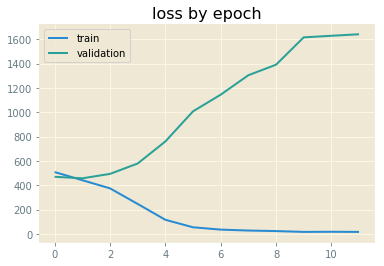

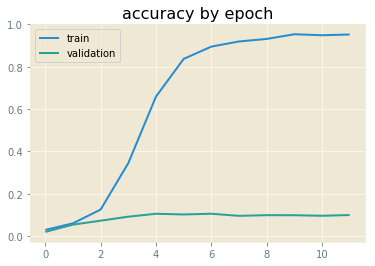

In [35]:
plt.plot(np.arange(len(train_losses)), train_losses, label='train')
plt.plot(np.arange(len(validation_losses)), validation_losses, label='validation')
plt.legend()
plt.title("loss by epoch")
plt.show()

plt.plot(np.arange(len(train_accuracies)), train_accuracies, label='train')
plt.plot(np.arange(len(validation_accuracies)), validation_accuracies, label='validation')
plt.legend()
plt.title("accuracy by epoch")
plt.show()

In [36]:
save_model(hpa_conv_neural_net, full=True, name='hpa_conv_neural_net_2019-01-10-1')

/home/uldo/miniconda3/envs/DS-New/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type HPA_ConvNeuralNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [37]:
!ls -lh

итого 1,4G
-rw-r--r-- 1 uldo uldo 1,8M дек 15 14:41 4-channel-resnet-from-scratch-pytorch-lb-0-16-1.ipynb
-rw-r--r-- 1 uldo uldo  15K дек 13 19:33 4-channel-resnet-from-scratch-pytorch-lb-0-16.ipynb
-rw-r--r-- 1 uldo uldo 2,1K янв  3 21:28 another_torch_validation_example.py
-rw-r--r-- 1 uldo uldo  29K дек  7 19:11 baseline-u-net-on-pytorch.py
-rw-r--r-- 1 uldo uldo  91M дек 15 13:49 bestmodel_1_0.49606512784957885.torch
-rw-r--r-- 1 uldo uldo  91M дек 13 19:34 bestmodel_1_0.5092800498008728.torch
-rw-r--r-- 1 uldo uldo  67K дек 23 19:14 cifar10_tutorial.ipynb
-rw-r--r-- 1 uldo uldo  12K дек 23 18:51 cifar10_tutorial.py
-rw-r--r-- 1 uldo uldo 226M янв  2 20:30 cnn.pkl
drwxr-xr-x 3 uldo uldo 4,0K дек 23 18:59 data
-rw-r--r-- 1 uldo uldo 6,0M дек 15 20:04 first_exp_eda-1.ipynb
-rw-r--r-- 1 uldo uldo 3,3M дек 13 11:31 first_exp_eda.ipynb
-rw-r--r-- 1 uldo uldo 2,4K дек 15 20:17 first_exp_model_with_pytorch.py
-rw-r--r-- 1 uldo uldo 226M янв  7 23:18 hpa_conv_neural_net_1.pkl
-rw-r--r-- 1 

In [71]:
importlib.reload(load_data)

<module 'load_data' from '/home/uldo/work/kaggle/competitions/Human_Protein_Atlas_Image_Classification/code/load_data.py'>

In [72]:
test_df = load_data.load_text_data('../input/sample_submission.csv')

In [73]:
test_dataset = load_data.HumanProteinAtlasDataset(
    test_df,
    transform=load_data.transforms.ToTensor(),
    train_mode=False
)

In [74]:
print(type(data))
print(data)

<class 'module'>
<module 'torch.utils.data' from '/home/uldo/miniconda3/envs/DS-New/lib/python3.6/site-packages/torch/utils/data/__init__.py'>


In [75]:
test_loader = data.DataLoader(test_dataset, shuffle=False, batch_size=BATCH_SIZE, num_workers=1)

In [91]:
torch.cuda.empty_cache()
since = time.time()
ids = []
predictions = []
hpa_conv_neural_net = hpa_conv_neural_net.cuda()

for test_data_batch in test_loader:
    #print("test_data_batch:\n", test_data_batch)
    test_input, input_ids = test_data_batch
    print("len(input_ids):\n", len(input_ids))
    test_output = run_model(hpa_conv_neural_net, test_input)
    print("test_output:\n", test_output)
    batch_predictions = []
    
    test_output = test_output.detach().numpy()
    print("test_output.shape: ", test_output.shape)
    
    #j = 0
    for sample in test_output:
        prediction = ''
        #print("type(sample): ", type(sample))
        #print("sample.shape: ", sample.shape)
        #print("sample:\n", sample)
        for i, label in enumerate(sample):
            #print("i: {}, label: {}".format(str(i), label))
            if label > 0:
                prediction += ' ' + str(i)
                #print("label > 0, label: {}, prediction: {}\n".format(label, prediction))
        if prediction == '':
            prediction = '0'
        else:
            prediction = prediction[1:]
        print("prediction after\n", prediction)
        #batch_predictions.append(''.join(prediction))
        batch_predictions.append(prediction)
        print('batch_predictions:\n', batch_predictions)
        #if j > 9:
        #    break
        #j += 1
    #ids += list(test_data_batch['Id'])
    ids.extend(input_ids)
    #predictions += batch_predictions
    predictions.extend(batch_predictions)
    #predictions.append(batch_predictions)
    
time_elapsed = time.time() - since
print(
    'Test dataset scoring completed in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60
    )
)

len(input_ids):
 100
test_output:
 tensor([[-11.8569, -21.0061,  -1.9996,  ..., -25.1965, -27.2761, -22.2582],
        [ -5.4796, -10.9801,  -5.5373,  ...,  -3.9910,  -8.6401, -10.9367],
        [ -2.4647, -24.3507, -14.5105,  ...,  12.2887, -13.9403, -18.8974],
        ...,
        [ 26.4146,  -8.3249,   1.1552,  ..., -20.3766, -27.6336, -27.7867],
        [-15.5569, -21.3309, -11.7595,  ..., -19.0333, -14.3692, -18.4287],
        [-14.0199, -14.7525, -18.1694,  ...,  14.9169, -17.9095, -22.3334]],
       grad_fn=<CopyBackwards>)
test_output.shape:  (100, 28)
prediction after
 7
batch_predictions:
 ['7']
prediction after
 23
batch_predictions:
 ['7', '23']
prediction after
 21 25
batch_predictions:
 ['7', '23', '21 25']
prediction after
 0
batch_predictions:
 ['7', '23', '21 25', '0']
prediction after
 0
batch_predictions:
 ['7', '23', '21 25', '0', '0']
prediction after
 5
batch_predictions:
 ['7', '23', '21 25', '0', '0', '5']
prediction after
 0
batch_predictions:
 ['7', '23', '21 

len(input_ids):
 100
test_output:
 tensor([[  8.6631, -13.1152,  -9.6879,  ...,  -5.7529, -15.6872, -17.7929],
        [  1.2231, -16.9251,  -2.5048,  ...,   3.6227, -14.7259, -18.6849],
        [ -3.5360,  -9.4705,  -3.1379,  ...,  -1.5769,  -9.4577, -11.9773],
        ...,
        [-14.7013,  -7.2524, -13.2229,  ...,  -9.1496,  -8.4676, -17.7249],
        [ -7.7047, -13.4251,  -7.6561,  ..., -12.6198,  -8.5524, -14.2482],
        [ 13.3996, -23.2609, -13.5603,  ...,  -3.9115, -27.1656, -34.7584]],
       grad_fn=<CopyBackwards>)
test_output.shape:  (100, 28)
prediction after
 0
batch_predictions:
 ['0']
prediction after
 0 21 25
batch_predictions:
 ['0', '0 21 25']
prediction after
 0
batch_predictions:
 ['0', '0 21 25', '0']
prediction after
 0
batch_predictions:
 ['0', '0 21 25', '0', '0']
prediction after
 0
batch_predictions:
 ['0', '0 21 25', '0', '0', '0']
prediction after
 0 25
batch_predictions:
 ['0', '0 21 25', '0', '0', '0', '0 25']
prediction after
 25
batch_predictions:


len(input_ids):
 100
test_output:
 tensor([[-15.8378, -25.3312, -26.0962,  ...,  -5.0890, -27.2168, -24.9080],
        [  5.7897,  -9.2041,  -3.7748,  ...,   5.3306,  -9.1550, -16.6709],
        [ -3.5820, -11.0555,  -7.2163,  ...,  -8.7992, -10.6940, -10.7484],
        ...,
        [ -6.9529,  -5.2009,   5.2311,  ...,   4.0481,  -8.9633, -12.3649],
        [ 35.5534, -31.7017,  -0.0590,  ..., -48.5996, -45.6792, -38.2681],
        [  3.0165, -13.5967,   0.6769,  ..., -10.9732, -15.4438, -20.7578]],
       grad_fn=<CopyBackwards>)
test_output.shape:  (100, 28)
prediction after
 7
batch_predictions:
 ['7']
prediction after
 0 25
batch_predictions:
 ['7', '0 25']
prediction after
 0
batch_predictions:
 ['7', '0 25', '0']
prediction after
 25
batch_predictions:
 ['7', '0 25', '0', '25']
prediction after
 0
batch_predictions:
 ['7', '0 25', '0', '25', '0']
prediction after
 0
batch_predictions:
 ['7', '0 25', '0', '25', '0', '0']
prediction after
 0 21 25
batch_predictions:
 ['7', '0 25', 

len(input_ids):
 100
test_output:
 tensor([[-12.5061,  -9.8176,  -8.9812,  ..., -14.1776, -17.0530, -14.2750],
        [  0.1795,  -5.0411, -12.7381,  ..., -14.6712,  -5.0053, -13.0399],
        [ -2.9403, -19.5349,  -7.5436,  ...,   5.2890, -25.0118, -26.1824],
        ...,
        [ -6.7684, -16.2063, -14.5485,  ...,  11.7199, -20.6543, -25.2755],
        [  5.6212, -18.1304, -19.6514,  ...,   3.0876, -17.4768, -24.0330],
        [ -1.0239, -16.6022, -24.7655,  ...,  -2.4081, -18.7942, -27.0454]],
       grad_fn=<CopyBackwards>)
test_output.shape:  (100, 28)
prediction after
 0
batch_predictions:
 ['0']
prediction after
 0
batch_predictions:
 ['0', '0']
prediction after
 25
batch_predictions:
 ['0', '0', '25']
prediction after
 0 21
batch_predictions:
 ['0', '0', '25', '0 21']
prediction after
 23
batch_predictions:
 ['0', '0', '25', '0 21', '23']
prediction after
 0
batch_predictions:
 ['0', '0', '25', '0 21', '23', '0']
prediction after
 7
batch_predictions:
 ['0', '0', '25', '0 21

len(input_ids):
 100
test_output:
 tensor([[ -2.5487, -17.4157, -18.4426,  ...,  -6.4752, -15.3840, -18.7857],
        [  3.8137, -41.1020, -34.4453,  ...,  33.8480, -37.8719, -54.2775],
        [  4.4309, -13.1784, -14.0468,  ...,   8.2984, -18.7147, -16.1536],
        ...,
        [  3.6310, -15.2885,  -5.0451,  ..., -10.3721, -15.2605, -16.7542],
        [  4.0026, -18.0875, -20.4339,  ...,  -7.1762, -24.1683, -20.3374],
        [ -5.7744,  -6.8422,  -6.6158,  ...,  -2.7275,  -7.7423, -12.2362]],
       grad_fn=<CopyBackwards>)
test_output.shape:  (100, 28)
prediction after
 0
batch_predictions:
 ['0']
prediction after
 0 5 25
batch_predictions:
 ['0', '0 5 25']
prediction after
 0 25
batch_predictions:
 ['0', '0 5 25', '0 25']
prediction after
 0 25
batch_predictions:
 ['0', '0 5 25', '0 25', '0 25']
prediction after
 0
batch_predictions:
 ['0', '0 5 25', '0 25', '0 25', '0']
prediction after
 2 25
batch_predictions:
 ['0', '0 5 25', '0 25', '0 25', '0', '2 25']
prediction after
 2

 0
batch_predictions:
 ['0', '0 5 25', '0 25', '0 25', '0', '2 25', '23', '5', '21 25', '0 21', '23', '0 5', '0', '21', '4 21', '0', '21', '0', '21 25', '0', '0', '0 21', '0', '0', '25', '0', '0 2 7', '0', '0', '0 25', '0 25', '0', '23', '0 7 25', '0 25', '25', '4', '0 25', '0', '0', '0', '21 25', '21 25', '0 25', '0 25', '0', '0', '0', '0 21 25', '0', '25', '0 2 4', '0', '4', '0', '0', '0']
prediction after
 0
batch_predictions:
 ['0', '0 5 25', '0 25', '0 25', '0', '2 25', '23', '5', '21 25', '0 21', '23', '0 5', '0', '21', '4 21', '0', '21', '0', '21 25', '0', '0', '0 21', '0', '0', '25', '0', '0 2 7', '0', '0', '0 25', '0 25', '0', '23', '0 7 25', '0 25', '25', '4', '0 25', '0', '0', '0', '21 25', '21 25', '0 25', '0 25', '0', '0', '0', '0 21 25', '0', '25', '0 2 4', '0', '4', '0', '0', '0', '0']
prediction after
 0
batch_predictions:
 ['0', '0 5 25', '0 25', '0 25', '0', '2 25', '23', '5', '21 25', '0 21', '23', '0 5', '0', '21', '4 21', '0', '21', '0', '21 25', '0', '0', '0 21', 

len(input_ids):
 100
test_output:
 tensor([[ -4.9701, -13.0257,  -7.7426,  ...,   2.6103, -12.0519, -13.3493],
        [ -9.5585,  -4.5580,  -6.9285,  ..., -11.6229, -12.6738, -15.8962],
        [ -3.2231, -11.0795, -12.7452,  ...,  -2.2680, -10.8756, -11.4690],
        ...,
        [ -5.9190, -10.4559,  -5.1055,  ..., -15.0442, -11.5021, -14.3209],
        [ -7.0111,  -9.1384,  -6.5186,  ...,   7.1180, -10.4370, -16.4438],
        [ -3.3918, -18.6717,  -8.2975,  ..., -23.3826, -10.9880, -18.9721]],
       grad_fn=<CopyBackwards>)
test_output.shape:  (100, 28)
prediction after
 25
batch_predictions:
 ['25']
prediction after
 0
batch_predictions:
 ['25', '0']
prediction after
 0
batch_predictions:
 ['25', '0', '0']
prediction after
 25
batch_predictions:
 ['25', '0', '0', '25']
prediction after
 25
batch_predictions:
 ['25', '0', '0', '25', '25']
prediction after
 0 25
batch_predictions:
 ['25', '0', '0', '25', '25', '0 25']
prediction after
 21
batch_predictions:
 ['25', '0', '0', '25'

len(input_ids):
 100
test_output:
 tensor([[  3.9005,  -7.7441,  -7.9211,  ...,  -2.0914,  -9.8231, -11.2148],
        [  1.6119, -13.9876,  -7.1877,  ...,  -3.6858, -16.9333, -16.6662],
        [-10.0363, -18.9797, -15.5519,  ..., -10.6471,  -3.8047, -12.1630],
        ...,
        [ 19.7936,  -9.4654, -14.2293,  ...,  17.8479, -16.2339, -25.0695],
        [ -1.3708, -10.4822, -13.5754,  ...,   0.0291, -14.1269, -21.6448],
        [-13.0360, -25.3522, -23.4109,  ...,  -7.8524, -17.0663, -23.8210]],
       grad_fn=<CopyBackwards>)
test_output.shape:  (100, 28)
prediction after
 0
batch_predictions:
 ['0']
prediction after
 0
batch_predictions:
 ['0', '0']
prediction after
 5
batch_predictions:
 ['0', '0', '5']
prediction after
 0 25
batch_predictions:
 ['0', '0', '5', '0 25']
prediction after
 0
batch_predictions:
 ['0', '0', '5', '0 25', '0']
prediction after
 23 25
batch_predictions:
 ['0', '0', '5', '0 25', '0', '23 25']
prediction after
 0
batch_predictions:
 ['0', '0', '5', '0 25'

len(input_ids):
 100
test_output:
 tensor([[-21.5314, -16.1885, -10.0289,  ..., -19.4863, -18.4567, -14.7775],
        [ -1.0743,  -6.7007,  -5.0188,  ...,  -1.7239,  -6.6257,  -8.6376],
        [ -3.7183, -19.9201, -14.3471,  ...,  -2.4168, -19.2173, -22.9062],
        ...,
        [ 11.4764, -23.7639, -28.6680,  ...,  -7.4502, -34.6861, -41.5536],
        [-33.8027, -20.6615, -22.4969,  ...,  -4.3149, -26.0621, -24.9938],
        [ 42.2712, -10.3811, -19.1972,  ...,  -8.9175, -26.3976, -29.8758]],
       grad_fn=<CopyBackwards>)
test_output.shape:  (100, 28)
prediction after
 0
batch_predictions:
 ['0']
prediction after
 0
batch_predictions:
 ['0', '0']
prediction after
 0
batch_predictions:
 ['0', '0', '0']
prediction after
 0
batch_predictions:
 ['0', '0', '0', '0']
prediction after
 0
batch_predictions:
 ['0', '0', '0', '0', '0']
prediction after
 0
batch_predictions:
 ['0', '0', '0', '0', '0', '0']
prediction after
 0
batch_predictions:
 ['0', '0', '0', '0', '0', '0', '0']
predic

len(input_ids):
 100
test_output:
 tensor([[  1.9964, -22.4738, -25.3475,  ...,   1.7144, -22.3151, -30.9818],
        [ -8.1982, -20.5773, -18.6432,  ..., -13.8101, -18.3760, -22.0756],
        [ -2.5154, -23.3848, -30.6997,  ...,   9.0468, -20.7779, -30.2721],
        ...,
        [ -8.1101, -21.1954, -13.7870,  ..., -17.7346,  -8.7814, -13.4554],
        [ 12.0089,  -8.2235, -23.1688,  ...,   1.3117, -19.0815, -19.5071],
        [ -2.4994,  -7.8382,  -8.2267,  ...,  -0.9507,  -9.1410,  -9.7112]],
       grad_fn=<CopyBackwards>)
test_output.shape:  (100, 28)
prediction after
 0 25
batch_predictions:
 ['0 25']
prediction after
 0
batch_predictions:
 ['0 25', '0']
prediction after
 4 7 21 25
batch_predictions:
 ['0 25', '0', '4 7 21 25']
prediction after
 0 25
batch_predictions:
 ['0 25', '0', '4 7 21 25', '0 25']
prediction after
 21 25
batch_predictions:
 ['0 25', '0', '4 7 21 25', '0 25', '21 25']
prediction after
 4
batch_predictions:
 ['0 25', '0', '4 7 21 25', '0 25', '21 25', '4

len(input_ids):
 100
test_output:
 tensor([[  0.6795,  -6.4487, -14.8122,  ...,  -2.8272, -12.2493, -13.8045],
        [ -2.9725, -19.6652, -12.1096,  ...,  -4.6024, -17.5582, -22.3919],
        [  7.6812, -42.0592, -15.6859,  ..., -31.0156, -23.1373, -40.6097],
        ...,
        [  4.2500, -10.4455, -14.3470,  ...,   1.6029, -12.1238, -13.9540],
        [ -6.7385,   0.0145, -16.2239,  ...,  -8.8147, -22.6998, -34.7135],
        [ -9.2944, -11.0175, -12.5957,  ...,  -6.1136,  -9.1344, -14.1747]],
       grad_fn=<CopyBackwards>)
test_output.shape:  (100, 28)
prediction after
 0
batch_predictions:
 ['0']
prediction after
 0
batch_predictions:
 ['0', '0']
prediction after
 0
batch_predictions:
 ['0', '0', '0']
prediction after
 0
batch_predictions:
 ['0', '0', '0', '0']
prediction after
 0 25
batch_predictions:
 ['0', '0', '0', '0', '0 25']
prediction after
 25
batch_predictions:
 ['0', '0', '0', '0', '0 25', '25']
prediction after
 2
batch_predictions:
 ['0', '0', '0', '0', '0 25', '2

len(input_ids):
 100
test_output:
 tensor([[  0.8020, -11.6111,  -6.3053,  ...,  -7.6151, -10.0200,  -9.1400],
        [ -7.7865, -12.2875,  -8.7007,  ...,  -1.5302, -10.6710, -12.8951],
        [ -5.8347, -10.0728,  -6.7493,  ...,  -5.2231, -10.0433, -11.6348],
        ...,
        [  0.2992, -17.8094, -11.6774,  ...,   7.4104, -10.5293, -16.4445],
        [ -6.6395, -15.1580,  -2.3383,  ..., -24.5207, -15.6105, -19.0626],
        [-12.9670,  -7.9605,  -6.9483,  ..., -17.3010,  -3.6598,  -9.6298]],
       grad_fn=<CopyBackwards>)
test_output.shape:  (100, 28)
prediction after
 0
batch_predictions:
 ['0']
prediction after
 0
batch_predictions:
 ['0', '0']
prediction after
 0
batch_predictions:
 ['0', '0', '0']
prediction after
 25
batch_predictions:
 ['0', '0', '0', '25']
prediction after
 4
batch_predictions:
 ['0', '0', '0', '25', '4']
prediction after
 0
batch_predictions:
 ['0', '0', '0', '25', '4', '0']
prediction after
 5 25
batch_predictions:
 ['0', '0', '0', '25', '4', '0', '5 

len(input_ids):
 100
test_output:
 tensor([[ -6.8191, -11.6745,  -8.8417,  ...,  -7.5637, -14.1283, -13.3089],
        [ -6.9623,  -8.9660,  -4.3135,  ..., -12.4039, -12.0406, -17.0691],
        [ -7.5534,  -7.1242, -10.9658,  ..., -17.2993, -11.9091, -12.7636],
        ...,
        [ -0.3871,  -9.2085,  -5.5577,  ...,  -9.1169, -11.7405, -12.4878],
        [  7.0242,  -3.3117, -15.9401,  ...,  -2.4576, -12.1901, -19.0887],
        [ -5.6559, -15.6594, -14.4474,  ..., -23.0283, -16.3893, -15.9687]],
       grad_fn=<CopyBackwards>)
test_output.shape:  (100, 28)
prediction after
 0
batch_predictions:
 ['0']
prediction after
 0
batch_predictions:
 ['0', '0']
prediction after
 0
batch_predictions:
 ['0', '0', '0']
prediction after
 0
batch_predictions:
 ['0', '0', '0', '0']
prediction after
 0
batch_predictions:
 ['0', '0', '0', '0', '0']
prediction after
 25
batch_predictions:
 ['0', '0', '0', '0', '0', '25']
prediction after
 0 25
batch_predictions:
 ['0', '0', '0', '0', '0', '25', '0 25

len(input_ids):
 100
test_output:
 tensor([[ -0.1565, -20.4366, -24.5097,  ...,   6.4446, -14.0597, -19.4202],
        [  5.4760, -10.5624,  -8.5556,  ...,  -3.2455, -10.0268, -13.0612],
        [  5.2043, -11.3141, -15.9040,  ...,  -3.3744, -11.8156, -20.2487],
        ...,
        [  4.1788, -26.5748, -37.3792,  ...,  19.9721, -38.5862, -50.8264],
        [  2.9197,  -8.8641, -10.3539,  ...,  -9.3100,  -8.7021, -12.0356],
        [  3.8967, -11.0320,  -3.3314,  ...,  -1.2085, -13.1935, -24.1253]],
       grad_fn=<CopyBackwards>)
test_output.shape:  (100, 28)
prediction after
 25
batch_predictions:
 ['25']
prediction after
 0
batch_predictions:
 ['25', '0']
prediction after
 0
batch_predictions:
 ['25', '0', '0']
prediction after
 25
batch_predictions:
 ['25', '0', '0', '25']
prediction after
 25
batch_predictions:
 ['25', '0', '0', '25', '25']
prediction after
 25
batch_predictions:
 ['25', '0', '0', '25', '25', '25']
prediction after
 0
batch_predictions:
 ['25', '0', '0', '25', '25

len(input_ids):
 100
test_output:
 tensor([[  4.2882, -14.7862,  -8.5907,  ...,  -9.8857, -11.7653, -15.8450],
        [ -1.2567, -15.3489,  -5.5433,  ..., -13.3499, -19.3769, -26.2712],
        [  0.2251, -11.2185,  -1.4726,  ..., -23.2784, -15.1039, -13.0917],
        ...,
        [ -2.9510,  -8.0905,  -3.2045,  ...,  -2.0145,  -7.0453,  -9.9431],
        [  0.4171,  -7.4244,  -9.8301,  ..., -13.2680, -12.0289, -11.8495],
        [-46.6249, -26.5095, -32.1038,  ...,   9.7197, -35.8521, -42.2314]],
       grad_fn=<CopyBackwards>)
test_output.shape:  (100, 28)
prediction after
 0 7
batch_predictions:
 ['0 7']
prediction after
 0
batch_predictions:
 ['0 7', '0']
prediction after
 0
batch_predictions:
 ['0 7', '0', '0']
prediction after
 0
batch_predictions:
 ['0 7', '0', '0', '0']
prediction after
 0
batch_predictions:
 ['0 7', '0', '0', '0', '0']
prediction after
 0
batch_predictions:
 ['0 7', '0', '0', '0', '0', '0']
prediction after
 25
batch_predictions:
 ['0 7', '0', '0', '0', '0',

len(input_ids):
 100
test_output:
 tensor([[ 11.0080, -20.9361, -14.8283,  ...,   1.5650, -17.0091, -20.8734],
        [-34.6058, -43.0485, -22.7728,  ..., -32.4525, -56.0843, -60.3437],
        [ -2.0803,  -6.0231,  -3.9124,  ...,  -6.1286, -11.3225,  -9.5561],
        ...,
        [ -1.7746,  -7.8788, -43.0236,  ..., -24.4076, -27.6549, -23.9930],
        [-15.1617, -12.3976, -13.4260,  ...,  -5.2798,  -7.1973, -13.0289],
        [ -1.3906, -12.2215,  -0.5187,  ...,  -9.0516, -11.6999, -11.2559]],
       grad_fn=<CopyBackwards>)
test_output.shape:  (100, 28)
prediction after
 0 25
batch_predictions:
 ['0 25']
prediction after
 0
batch_predictions:
 ['0 25', '0']
prediction after
 0
batch_predictions:
 ['0 25', '0', '0']
prediction after
 0 25
batch_predictions:
 ['0 25', '0', '0', '0 25']
prediction after
 0
batch_predictions:
 ['0 25', '0', '0', '0 25', '0']
prediction after
 25
batch_predictions:
 ['0 25', '0', '0', '0 25', '0', '25']
prediction after
 0
batch_predictions:
 ['0 25'

len(input_ids):
 100
test_output:
 tensor([[ -4.1254, -13.0825,  -4.3038,  ...,  -2.9967, -13.7360, -16.0136],
        [ -8.9914, -33.4833, -29.4744,  ...,  15.8568, -30.8321, -43.9030],
        [ -0.2147, -22.1133, -16.3943,  ...,  -3.9003, -18.2836, -17.9590],
        ...,
        [ -4.4072, -11.6438,  -3.7572,  ...,  -1.5990,  -7.3254, -12.1002],
        [-36.5301, -35.6947, -33.5147,  ...,   2.6822, -56.0704, -63.5905],
        [  8.8139, -19.8790, -11.2102,  ...,   6.0690, -16.0006, -17.7507]],
       grad_fn=<CopyBackwards>)
test_output.shape:  (100, 28)
prediction after
 0
batch_predictions:
 ['0']
prediction after
 21 25
batch_predictions:
 ['0', '21 25']
prediction after
 0
batch_predictions:
 ['0', '21 25', '0']
prediction after
 25
batch_predictions:
 ['0', '21 25', '0', '25']
prediction after
 0
batch_predictions:
 ['0', '21 25', '0', '25', '0']
prediction after
 25
batch_predictions:
 ['0', '21 25', '0', '25', '0', '25']
prediction after
 0
batch_predictions:
 ['0', '21 25

len(input_ids):
 100
test_output:
 tensor([[  4.0163, -19.8949, -14.7699,  ...,   9.0488, -16.7964, -30.5469],
        [-10.0192, -12.9259, -10.5464,  ...,  -4.6168, -15.1495, -18.3762],
        [-15.1389, -20.0454,  -9.3311,  ..., -24.8820, -16.2374, -16.2857],
        ...,
        [ -1.1504, -10.6298,  -4.2274,  ...,   0.1307,  -6.3453, -10.8170],
        [  1.2844,  -9.5611,  -1.3120,  ...,  -0.1148, -11.8298, -16.4534],
        [ -3.4954,  -8.1933,  -6.8169,  ...,  -9.4622, -10.7624, -14.9196]],
       grad_fn=<CopyBackwards>)
test_output.shape:  (100, 28)
prediction after
 0 25
batch_predictions:
 ['0 25']
prediction after
 21
batch_predictions:
 ['0 25', '21']
prediction after
 0
batch_predictions:
 ['0 25', '21', '0']
prediction after
 0
batch_predictions:
 ['0 25', '21', '0', '0']
prediction after
 21
batch_predictions:
 ['0 25', '21', '0', '0', '21']
prediction after
 0
batch_predictions:
 ['0 25', '21', '0', '0', '21', '0']
prediction after
 0
batch_predictions:
 ['0 25', '21

len(input_ids):
 100
test_output:
 tensor([[-23.9173, -18.8483, -32.0269,  ..., -20.5861,  -8.5238, -17.4465],
        [ -4.4952, -12.2816, -21.7531,  ..., -27.1801, -18.6844, -20.7715],
        [  1.4576, -14.5467,  -8.0783,  ...,  -2.7399, -10.4393, -16.3866],
        ...,
        [ 27.6032,  -2.2132, -10.7163,  ..., -12.0474, -20.4589, -39.9596],
        [ -5.6285,  -9.1445, -13.1796,  ...,  -5.5181,  -9.9251, -14.3497],
        [ -9.6971, -21.7579, -31.7270,  ...,  -6.5218, -26.6932, -19.3260]],
       grad_fn=<CopyBackwards>)
test_output.shape:  (100, 28)
prediction after
 4
batch_predictions:
 ['4']
prediction after
 0
batch_predictions:
 ['4', '0']
prediction after
 0
batch_predictions:
 ['4', '0', '0']
prediction after
 4 25
batch_predictions:
 ['4', '0', '0', '4 25']
prediction after
 0
batch_predictions:
 ['4', '0', '0', '4 25', '0']
prediction after
 0 5
batch_predictions:
 ['4', '0', '0', '4 25', '0', '0 5']
prediction after
 0
batch_predictions:
 ['4', '0', '0', '4 25', '0

len(input_ids):
 100
test_output:
 tensor([[ -80.9546,  -63.1847,  -61.7270,  ...,  -13.2708,  -92.5303,
         -114.5846],
        [   0.7284,   -8.2162,  -10.6846,  ...,    0.4271,  -11.4743,
          -16.5886],
        [  -6.0179,   -6.3071,   -4.8429,  ...,  -18.8867,  -17.7608,
          -15.8595],
        ...,
        [   9.9921,  -16.7819,  -16.8935,  ...,    5.1836,  -14.1614,
          -19.2570],
        [   8.4431,  -18.1198,  -19.4967,  ...,  -23.8357,  -30.5049,
          -26.9801],
        [   3.4259,  -15.1360,   -6.7458,  ...,   -3.1265,  -11.6491,
          -14.2518]], grad_fn=<CopyBackwards>)
test_output.shape:  (100, 28)
prediction after
 21
batch_predictions:
 ['21']
prediction after
 0 25
batch_predictions:
 ['21', '0 25']
prediction after
 0
batch_predictions:
 ['21', '0 25', '0']
prediction after
 0
batch_predictions:
 ['21', '0 25', '0', '0']
prediction after
 0
batch_predictions:
 ['21', '0 25', '0', '0', '0']
prediction after
 0
batch_predictions:
 ['21', '0

len(input_ids):
 100
test_output:
 tensor([[ -9.7305, -17.4041,  -8.8571,  ...,  -7.1919,  -6.2877, -13.9598],
        [ -2.2395,  -9.6391,  -4.5080,  ..., -11.1054, -14.7986, -14.3582],
        [ 18.5158,  -5.6573, -19.5694,  ..., -37.7364, -23.2469, -28.1475],
        ...,
        [ -0.4152,  -9.3760,  -6.7945,  ...,  -5.8879, -12.1312, -11.4148],
        [-35.7391, -22.2346, -15.1938,  ...,   0.7833, -23.7490, -29.3881],
        [ -5.1685, -20.2772, -18.6088,  ..., -21.6330, -20.8532, -17.3378]],
       grad_fn=<CopyBackwards>)
test_output.shape:  (100, 28)
prediction after
 0
batch_predictions:
 ['0']
prediction after
 0
batch_predictions:
 ['0', '0']
prediction after
 0 4
batch_predictions:
 ['0', '0', '0 4']
prediction after
 0
batch_predictions:
 ['0', '0', '0 4', '0']
prediction after
 0
batch_predictions:
 ['0', '0', '0 4', '0', '0']
prediction after
 0 25
batch_predictions:
 ['0', '0', '0 4', '0', '0', '0 25']
prediction after
 0
batch_predictions:
 ['0', '0', '0 4', '0', '0'

len(input_ids):
 100
test_output:
 tensor([[  -9.1995,  -19.6029,   -5.8693,  ...,    5.1910,   -9.5206,
          -17.0156],
        [  24.7839,  -58.3649, -100.8672,  ...,    1.4143,  -96.4331,
         -105.7841],
        [ -11.4194,  -38.6602,   -7.2612,  ...,  -21.7304,  -33.1793,
          -44.8101],
        ...,
        [  14.1188,  -10.0926,   -3.0208,  ...,    4.9182,  -20.2322,
          -35.4827],
        [  -0.8203,  -12.7645,  -25.1290,  ...,    6.6445,  -27.0981,
          -34.5727],
        [  -6.9222,  -12.1897,  -14.1740,  ...,   -2.4097,  -12.8423,
          -14.3918]], grad_fn=<CopyBackwards>)
test_output.shape:  (100, 28)
prediction after
 25
batch_predictions:
 ['25']
prediction after
 0 25
batch_predictions:
 ['25', '0 25']
prediction after
 23
batch_predictions:
 ['25', '0 25', '23']
prediction after
 0
batch_predictions:
 ['25', '0 25', '23', '0']
prediction after
 21 25
batch_predictions:
 ['25', '0 25', '23', '0', '21 25']
prediction after
 0
batch_predictions

 7
batch_predictions:
 ['25', '0 25', '23', '0', '21 25', '0', '25', '0', '21', '25', '0', '4', '0 21', '0', '0', '25', '0', '25', '0', '4 21', '0', '7', '25', '0 23', '0', '0 19', '0', '0', '0 25', '0', '25', '0 2', '3 21', '0', '0', '0', '21 25', '25', '0', '0', '0', '0 25', '0 25', '2', '0 21 25', '0', '0', '25', '0', '0', '0', '0 25', '0 25', '0', '25', '7']
prediction after
 0
batch_predictions:
 ['25', '0 25', '23', '0', '21 25', '0', '25', '0', '21', '25', '0', '4', '0 21', '0', '0', '25', '0', '25', '0', '4 21', '0', '7', '25', '0 23', '0', '0 19', '0', '0', '0 25', '0', '25', '0 2', '3 21', '0', '0', '0', '21 25', '25', '0', '0', '0', '0 25', '0 25', '2', '0 21 25', '0', '0', '25', '0', '0', '0', '0 25', '0 25', '0', '25', '7', '0']
prediction after
 0 25
batch_predictions:
 ['25', '0 25', '23', '0', '21 25', '0', '25', '0', '21', '25', '0', '4', '0 21', '0', '0', '25', '0', '25', '0', '4 21', '0', '7', '25', '0 23', '0', '0 19', '0', '0', '0 25', '0', '25', '0 2', '3 21', '0'

len(input_ids):
 100
test_output:
 tensor([[ 45.6859, -23.2136, -17.8480,  ...,  -7.2045, -35.5974, -36.1237],
        [ -1.4474, -12.2129, -10.0745,  ...,  -0.5423, -10.3057, -12.1522],
        [-20.6646, -14.3428, -15.2509,  ...,  -1.5930, -13.1467, -18.3419],
        ...,
        [ -6.4392, -14.3486, -17.0762,  ...,  -0.3306, -14.2097, -21.0263],
        [-16.0085, -16.1731,  -8.4463,  ..., -16.9046, -15.5886, -18.8976],
        [ -3.5077, -10.7477, -15.3903,  ..., -13.9853, -17.3129, -12.5448]],
       grad_fn=<CopyBackwards>)
test_output.shape:  (100, 28)
prediction after
 0 19
batch_predictions:
 ['0 19']
prediction after
 0
batch_predictions:
 ['0 19', '0']
prediction after
 23
batch_predictions:
 ['0 19', '0', '23']
prediction after
 2 7 23
batch_predictions:
 ['0 19', '0', '23', '2 7 23']
prediction after
 0
batch_predictions:
 ['0 19', '0', '23', '2 7 23', '0']
prediction after
 0
batch_predictions:
 ['0 19', '0', '23', '2 7 23', '0', '0']
prediction after
 25
batch_predictio

 2
batch_predictions:
 ['0 19', '0', '23', '2 7 23', '0', '0', '25', '0', '23', '21', '0', '0', '0', '0', '0', '0', '0 25', '0', '4', '25', '0 21', '0', '4 25', '0', '0', '0', '0', '0', '0 25', '0', '2 21 25', '25', '5 23', '0', '25', '0', '0', '0', '0 21', '0', '0', '25', '0', '0 21', '21', '0', '2']
prediction after
 0
batch_predictions:
 ['0 19', '0', '23', '2 7 23', '0', '0', '25', '0', '23', '21', '0', '0', '0', '0', '0', '0', '0 25', '0', '4', '25', '0 21', '0', '4 25', '0', '0', '0', '0', '0', '0 25', '0', '2 21 25', '25', '5 23', '0', '25', '0', '0', '0', '0 21', '0', '0', '25', '0', '0 21', '21', '0', '2', '0']
prediction after
 0
batch_predictions:
 ['0 19', '0', '23', '2 7 23', '0', '0', '25', '0', '23', '21', '0', '0', '0', '0', '0', '0', '0 25', '0', '4', '25', '0 21', '0', '4 25', '0', '0', '0', '0', '0', '0 25', '0', '2 21 25', '25', '5 23', '0', '25', '0', '0', '0', '0 21', '0', '0', '25', '0', '0 21', '21', '0', '2', '0', '0']
prediction after
 21 25
batch_predictions:

len(input_ids):
 100
test_output:
 tensor([[  0.6581,  -4.3605,  -6.9662,  ...,   0.5474, -17.5983, -25.5327],
        [-14.6740, -13.6082, -12.9436,  ..., -19.0267,  -7.2914, -10.3414],
        [ 76.9260, -22.9007, -15.2578,  ...,  15.9916, -33.9789, -60.7701],
        ...,
        [-16.7326,  -6.3066, -10.1177,  ...,   1.0532,  -8.8811, -18.6138],
        [  3.0607, -17.3014,  -6.0019,  ..., -13.3325, -22.5903, -25.2323],
        [ -3.5225,  -8.4278,  -9.6445,  ...,  -5.7799,  -5.8946,  -8.9899]],
       grad_fn=<CopyBackwards>)
test_output.shape:  (100, 28)
prediction after
 0 21 25
batch_predictions:
 ['0 21 25']
prediction after
 7
batch_predictions:
 ['0 21 25', '7']
prediction after
 0 25
batch_predictions:
 ['0 21 25', '7', '0 25']
prediction after
 0
batch_predictions:
 ['0 21 25', '7', '0 25', '0']
prediction after
 0
batch_predictions:
 ['0 21 25', '7', '0 25', '0', '0']
prediction after
 0
batch_predictions:
 ['0 21 25', '7', '0 25', '0', '0', '0']
prediction after
 0 21
ba

len(input_ids):
 100
test_output:
 tensor([[ -2.7832, -12.6094,  -1.2867,  ...,   1.6260, -12.4513, -14.3958],
        [  0.4286, -11.1563,  -8.8245,  ...,  -4.6012, -14.2806, -16.3857],
        [  0.1880,  -6.8138,  -6.2981,  ...,   0.4355,  -7.3317, -10.1838],
        ...,
        [  0.4650, -16.4526,  -3.7170,  ...,   4.7121, -23.6774, -23.9518],
        [  8.7870, -19.4099,  -8.8570,  ...,  -5.3615,  -9.6895, -15.9719],
        [ -2.2626,  -9.7850,  -3.6099,  ...,  -2.0966,  -6.7191, -10.5699]],
       grad_fn=<CopyBackwards>)
test_output.shape:  (100, 28)
prediction after
 5 25
batch_predictions:
 ['5 25']
prediction after
 0
batch_predictions:
 ['5 25', '0']
prediction after
 0 25
batch_predictions:
 ['5 25', '0', '0 25']
prediction after
 0
batch_predictions:
 ['5 25', '0', '0 25', '0']
prediction after
 4 25
batch_predictions:
 ['5 25', '0', '0 25', '0', '4 25']
prediction after
 2
batch_predictions:
 ['5 25', '0', '0 25', '0', '4 25', '2']
prediction after
 0
batch_predictions

len(input_ids):
 100
test_output:
 tensor([[  6.8725,  -7.1265,  -0.7430,  ..., -21.3318, -24.1612, -23.2197],
        [-11.5406,  -8.6729, -12.8492,  ...,  15.6116, -10.5294, -15.5876],
        [ -9.7250, -11.9739, -12.4279,  ...,   2.3393, -17.0114, -16.7428],
        ...,
        [ -6.9992, -11.9281, -21.3003,  ...,  -4.7768, -13.5752, -13.6206],
        [ -3.3711,  -4.4575,  -5.4571,  ...,   0.2663, -15.6410, -16.8405],
        [-18.3190, -21.7622, -19.4461,  ..., -14.2921, -17.9134, -19.0919]],
       grad_fn=<CopyBackwards>)
test_output.shape:  (100, 28)
prediction after
 0
batch_predictions:
 ['0']
prediction after
 5 25
batch_predictions:
 ['0', '5 25']
prediction after
 25
batch_predictions:
 ['0', '5 25', '25']
prediction after
 0
batch_predictions:
 ['0', '5 25', '25', '0']
prediction after
 7
batch_predictions:
 ['0', '5 25', '25', '0', '7']
prediction after
 21 25
batch_predictions:
 ['0', '5 25', '25', '0', '7', '21 25']
prediction after
 0
batch_predictions:
 ['0', '5 25

len(input_ids):
 100
test_output:
 tensor([[ 13.9519,  -9.0209,  -6.8693,  ...,  -2.8228, -14.6722, -20.1776],
        [ -5.0299, -12.0332, -13.1382,  ...,   3.9621, -19.1369, -19.4687],
        [ -0.4933,  -8.8431, -13.1417,  ..., -10.0000,  -7.3123, -14.6368],
        ...,
        [  2.2703, -23.0547,  -3.8329,  ...,  -5.9121, -25.0667, -25.0741],
        [-10.0126, -16.2178, -17.4124,  ...,  -3.4675, -16.5115, -20.9705],
        [ -8.0785, -17.8716,  -7.5045,  ...,  -7.4301, -16.0141, -17.1812]],
       grad_fn=<CopyBackwards>)
test_output.shape:  (100, 28)
prediction after
 0
batch_predictions:
 ['0']
prediction after
 4 21 25
batch_predictions:
 ['0', '4 21 25']
prediction after
 21
batch_predictions:
 ['0', '4 21 25', '21']
prediction after
 0
batch_predictions:
 ['0', '4 21 25', '21', '0']
prediction after
 0
batch_predictions:
 ['0', '4 21 25', '21', '0', '0']
prediction after
 25
batch_predictions:
 ['0', '4 21 25', '21', '0', '0', '25']
prediction after
 21 25
batch_predictio

 0 2 5
batch_predictions:
 ['0', '4 21 25', '21', '0', '0', '25', '21 25', '0', '0', '0', '23 25', '0', '0 21', '0', '0', '0 25', '0', '0', '0', '0 25', '0', '0 4 21 25', '0', '0 21 25', '23', '0', '0', '0', '0', '0', '0', '21', '0 25', '25', '0', '6 25', '21', '0', '0', '0', '7 21', '0 2', '0', '0', '0', '0', '0', '0', '5', '0 25', '25', '0 1', '4', '0', '0', '0', '0', '0', '25', '2', '0', '0', '25', '0', '0', '4', '4', '5', '0', '0', '25', '0', '0', '0 2', '0', '0', '0', '0', '0', '0', '3', '21', '0', '0 21', '0', '0', '0', '25', '0 25', '25', '0', '0', '21', '0 21', '0 2 5']
prediction after
 21
batch_predictions:
 ['0', '4 21 25', '21', '0', '0', '25', '21 25', '0', '0', '0', '23 25', '0', '0 21', '0', '0', '0 25', '0', '0', '0', '0 25', '0', '0 4 21 25', '0', '0 21 25', '23', '0', '0', '0', '0', '0', '0', '21', '0 25', '25', '0', '6 25', '21', '0', '0', '0', '7 21', '0 2', '0', '0', '0', '0', '0', '0', '5', '0 25', '25', '0 1', '4', '0', '0', '0', '0', '0', '25', '2', '0', '0', '2

 0
batch_predictions:
 ['0', '0', '0', '21', '4', '21', '0 25', '25', '0 21 25', '21', '0 5', '0', '23', '0', '25', '2', '0', '0', '0', '25', '0 21', '0', '0 2 25', '0', '6 7', '0', '25', '0', '0', '25', '0', '0', '0', '14 25', '0', '5 21', '0', '0', '0 4', '5', '0 25', '0', '7 25', '0', '23', '25', '0', '0', '0', '0', '0', '0', '0', '0 7', '0', '0', '0', '0 25', '0', '0 23 25', '0', '21', '0', '0 21', '21 25', '0', '0', '0', '0', '0 25', '0', '0', '0 7 25', '0', '0 23', '0', '0', '0', '0', '0', '0', '21', '0', '0 23', '21 25', '21', '0', '2', '21 25', '0', '0', '0', '0', '21', '4', '0 21', '21', '4 18 19', '0']
prediction after
 25
batch_predictions:
 ['0', '0', '0', '21', '4', '21', '0 25', '25', '0 21 25', '21', '0 5', '0', '23', '0', '25', '2', '0', '0', '0', '25', '0 21', '0', '0 2 25', '0', '6 7', '0', '25', '0', '0', '25', '0', '0', '0', '14 25', '0', '5 21', '0', '0', '0 4', '5', '0 25', '0', '7 25', '0', '23', '25', '0', '0', '0', '0', '0', '0', '0', '0 7', '0', '0', '0', '0 2

 ['0 7', '21 25', '0', '0', '25', '0', '0 25', '0', '0', '0', '7', '25', '0', '0', '23', '0', '0', '0 25', '2', '0', '0', '0 11 25', '0', '0', '0', '0', '0', '0 2 5', '0', '0', '0', '0 22', '0 3 25', '0', '0', '0', '5 7', '25', '0', '0', '0', '0', '4', '0 25', '25', '7', '0', '25', '2 25', '0 5', '0', '0', '0', '0', '25', '0', '0', '0', '0', '0', '2', '23', '0 25', '0', '21 25', '4', '21', '5 25', '23 25', '0', '0', '25', '7', '0', '0', '0', '0', '0', '0', '0', '0', '25', '4', '21', '23', '0', '4']
prediction after
 0
batch_predictions:
 ['0 7', '21 25', '0', '0', '25', '0', '0 25', '0', '0', '0', '7', '25', '0', '0', '23', '0', '0', '0 25', '2', '0', '0', '0 11 25', '0', '0', '0', '0', '0', '0 2 5', '0', '0', '0', '0 22', '0 3 25', '0', '0', '0', '5 7', '25', '0', '0', '0', '0', '4', '0 25', '25', '7', '0', '25', '2 25', '0 5', '0', '0', '0', '0', '25', '0', '0', '0', '0', '0', '2', '23', '0 25', '0', '21 25', '4', '21', '5 25', '23 25', '0', '0', '25', '7', '0', '0', '0', '0', '0', '

 0
batch_predictions:
 ['0 21', '0', '0', '0', '0', '0', '4 7', '0', '0 21', '0 7', '0 25', '0', '0', '2', '0 21', '25', '0 25', '0', '0', '25', '0', '0', '0 25', '0', '5', '0', '0', '0', '0', '0', '0', '0', '0 2', '0', '2 25', '0', '0', '0', '0', '0', '25', '0', '0', '0', '0 21', '0', '0', '0 4', '0', '0', '0 25', '0', '0', '0', '0', '0', '0', '0', '0', '21 25', '25', '23', '4', '0', '25', '0 25', '4', '21', '5', '0 21', '0', '0', '0', '25', '0', '11 25', '0', '7', '0', '4', '0', '0', '23', '0', '7', '0', '0', '0 25', '0', '0']
prediction after
 0
batch_predictions:
 ['0 21', '0', '0', '0', '0', '0', '4 7', '0', '0 21', '0 7', '0 25', '0', '0', '2', '0 21', '25', '0 25', '0', '0', '25', '0', '0', '0 25', '0', '5', '0', '0', '0', '0', '0', '0', '0', '0 2', '0', '2 25', '0', '0', '0', '0', '0', '25', '0', '0', '0', '0 21', '0', '0', '0 4', '0', '0', '0 25', '0', '0', '0', '0', '0', '0', '0', '0', '21 25', '25', '23', '4', '0', '25', '0 25', '4', '21', '5', '0 21', '0', '0', '0', '25', '

len(input_ids):
 100
test_output:
 tensor([[  3.4440,  -8.5564, -10.9600,  ...,   3.7164, -10.2248, -19.7956],
        [ -4.1720, -14.1100, -19.5040,  ...,  -1.7566, -15.8712, -19.8858],
        [ 22.5644, -19.2983, -19.9085,  ..., -25.0983, -22.4742, -22.1341],
        ...,
        [  2.3912, -13.2241,  -4.2074,  ...,  -7.0822, -10.5397, -11.4157],
        [ 11.1542, -14.1268, -14.6253,  ...,  -6.2790, -19.3667, -23.5083],
        [ -4.0346, -24.3246, -16.0853,  ...,  -3.9936, -13.7854, -23.5770]],
       grad_fn=<CopyBackwards>)
test_output.shape:  (100, 28)
prediction after
 0 25
batch_predictions:
 ['0 25']
prediction after
 0
batch_predictions:
 ['0 25', '0']
prediction after
 0
batch_predictions:
 ['0 25', '0', '0']
prediction after
 0 21 25
batch_predictions:
 ['0 25', '0', '0', '0 21 25']
prediction after
 0 25
batch_predictions:
 ['0 25', '0', '0', '0 21 25', '0 25']
prediction after
 0 21
batch_predictions:
 ['0 25', '0', '0', '0 21 25', '0 25', '0 21']
prediction after
 7
ba

len(input_ids):
 100
test_output:
 tensor([[  9.6153, -14.7037, -22.3957,  ...,  -4.8662, -20.0497, -19.5576],
        [  6.5755, -12.6288, -10.5869,  ..., -17.0240, -34.6873, -35.0514],
        [  7.2510, -11.9746, -12.0834,  ...,  -3.0055, -15.0204, -15.6217],
        ...,
        [ -6.3497, -23.4545,  -0.0642,  ..., -11.3137, -19.2590, -16.7191],
        [ -2.8916,  -9.5468,  -9.2646,  ...,   5.2555,  -6.1443, -12.3305],
        [ -0.7059, -11.8053, -14.0361,  ..., -20.1509, -18.5537, -18.1185]],
       grad_fn=<CopyBackwards>)
test_output.shape:  (100, 28)
prediction after
 0
batch_predictions:
 ['0']
prediction after
 0
batch_predictions:
 ['0', '0']
prediction after
 0
batch_predictions:
 ['0', '0', '0']
prediction after
 0
batch_predictions:
 ['0', '0', '0', '0']
prediction after
 21
batch_predictions:
 ['0', '0', '0', '0', '21']
prediction after
 0
batch_predictions:
 ['0', '0', '0', '0', '21', '0']
prediction after
 4
batch_predictions:
 ['0', '0', '0', '0', '21', '0', '4']
pr

 0
batch_predictions:
 ['0', '0', '0', '0', '21', '0', '4', '25', '0 2 7', '0', '0', '4', '0', '0', '0', '0', '0', '4', '2', '0', '0', '25', '25', '0', '0', '25', '0', '0', '0 25', '0', '0', '0', '5 7', '0 25', '0', '21', '23', '0', '0', '0', '7', '0', '0', '0 25', '0', '0', '0', '0', '0', '4 25', '0', '0', '0 2', '25', '23', '25', '0', '25', '0', '0', '0', '0', '0 21 25', '25', '0', '0', '7 25', '0', '2', '0 21', '0 25', '0 25', '0', '7', '25', '0', '0 25', '0 25', '21', '0 7 25', '25', '25', '0', '0', '0', '25', '0', '0', '0 21', '0', '0', '0', '25', '0 23', '0']
prediction after
 0
batch_predictions:
 ['0', '0', '0', '0', '21', '0', '4', '25', '0 2 7', '0', '0', '4', '0', '0', '0', '0', '0', '4', '2', '0', '0', '25', '25', '0', '0', '25', '0', '0', '0 25', '0', '0', '0', '5 7', '0 25', '0', '21', '23', '0', '0', '0', '7', '0', '0', '0 25', '0', '0', '0', '0', '0', '4 25', '0', '0', '0 2', '25', '23', '25', '0', '25', '0', '0', '0', '0', '0 21 25', '25', '0', '0', '7 25', '0', '2', '

 ['0', '25', '25', '0', '0 25', '0', '0 25', '0', '0 21 25', '0', '0', '21', '0', '0', '0 25', '0', '25', '21 25', '0 23', '0', '25', '0', '0', '0', '0', '0 25', '0', '25', '0', '0', '5 14', '5', '0', '0', '12 21', '0']
prediction after
 0
batch_predictions:
 ['0', '25', '25', '0', '0 25', '0', '0 25', '0', '0 21 25', '0', '0', '21', '0', '0', '0 25', '0', '25', '21 25', '0 23', '0', '25', '0', '0', '0', '0', '0 25', '0', '25', '0', '0', '5 14', '5', '0', '0', '12 21', '0', '0']
prediction after
 21 25
batch_predictions:
 ['0', '25', '25', '0', '0 25', '0', '0 25', '0', '0 21 25', '0', '0', '21', '0', '0', '0 25', '0', '25', '21 25', '0 23', '0', '25', '0', '0', '0', '0', '0 25', '0', '25', '0', '0', '5 14', '5', '0', '0', '12 21', '0', '0', '21 25']
prediction after
 0
batch_predictions:
 ['0', '25', '25', '0', '0 25', '0', '0 25', '0', '0 21 25', '0', '0', '21', '0', '0', '0 25', '0', '25', '21 25', '0 23', '0', '25', '0', '0', '0', '0', '0 25', '0', '25', '0', '0', '5 14', '5', '0',

len(input_ids):
 100
test_output:
 tensor([[ -3.3268,  -9.8863,  -6.7604,  ...,   2.2257,  -7.2094, -10.4126],
        [ -6.2799, -14.4289, -12.4144,  ...,  -8.7093, -11.5925, -15.2736],
        [ -6.6268,  -7.2515,  -4.2373,  ...,  -7.5544,  -9.6450, -11.0794],
        ...,
        [ -1.5230,  -7.6186, -18.2731,  ...,  -7.2824, -26.8279, -27.3290],
        [-19.5754, -19.5363, -24.4433,  ...,  -9.7177, -19.6852, -20.5784],
        [  3.9507,  -9.8631, -36.6306,  ...,  22.1402, -16.9407, -37.8224]],
       grad_fn=<CopyBackwards>)
test_output.shape:  (100, 28)
prediction after
 25
batch_predictions:
 ['25']
prediction after
 0
batch_predictions:
 ['25', '0']
prediction after
 4
batch_predictions:
 ['25', '0', '4']
prediction after
 0
batch_predictions:
 ['25', '0', '4', '0']
prediction after
 0
batch_predictions:
 ['25', '0', '4', '0', '0']
prediction after
 5 7
batch_predictions:
 ['25', '0', '4', '0', '0', '5 7']
prediction after
 21
batch_predictions:
 ['25', '0', '4', '0', '0', '5 

len(input_ids):
 100
test_output:
 tensor([[  2.4854, -17.3224, -21.6220,  ...,   0.4611, -18.6713, -23.9372],
        [  1.2873, -14.5212,  -6.6953,  ...,  -2.9666, -14.2496, -13.8951],
        [ -3.4329, -12.0913,  -8.9435,  ...,  -0.3129,  -8.7344, -10.4251],
        ...,
        [  6.3542, -14.1342,  -3.9354,  ...,  -0.4295, -21.0335, -21.7150],
        [ 16.7647, -34.9304, -22.1712,  ..., -36.5685, -41.2635, -40.2377],
        [ -8.2820,  -7.7993,  -8.8189,  ...,  -8.0638,  -7.0233, -10.8210]],
       grad_fn=<CopyBackwards>)
test_output.shape:  (100, 28)
prediction after
 0 25
batch_predictions:
 ['0 25']
prediction after
 0
batch_predictions:
 ['0 25', '0']
prediction after
 5
batch_predictions:
 ['0 25', '0', '5']
prediction after
 0
batch_predictions:
 ['0 25', '0', '5', '0']
prediction after
 0
batch_predictions:
 ['0 25', '0', '5', '0', '0']
prediction after
 0
batch_predictions:
 ['0 25', '0', '5', '0', '0', '0']
prediction after
 0
batch_predictions:
 ['0 25', '0', '5', '0

 0
batch_predictions:
 ['0 25', '0', '5', '0', '0', '0', '0', '0', '25', '25', '0', '0', '0', '25', '0', '0 21 25', '0', '0', '0', '0', '0 25', '0', '7', '0 23', '0', '2 25', '0', '0', '5 25', '25', '0', '0', '0', '0', '0', '5', '0 21', '0', '0 25', '25', '0', '0', '21', '0 2', '21 25', '0', '25', '0 2', '0', '0 25', '25', '0', '0', '25', '21', '0 2 25', '7 21', '0', '0', '0', '0', '0', '0 2', '2', '0', '0', '0', '0', '0', '25', '0', '0', '0', '0', '0', '0', '0 23', '0', '0 25', '25', '0']
prediction after
 0
batch_predictions:
 ['0 25', '0', '5', '0', '0', '0', '0', '0', '25', '25', '0', '0', '0', '25', '0', '0 21 25', '0', '0', '0', '0', '0 25', '0', '7', '0 23', '0', '2 25', '0', '0', '5 25', '25', '0', '0', '0', '0', '0', '5', '0 21', '0', '0 25', '25', '0', '0', '21', '0 2', '21 25', '0', '25', '0 2', '0', '0 25', '25', '0', '0', '25', '21', '0 2 25', '7 21', '0', '0', '0', '0', '0', '0 2', '2', '0', '0', '0', '0', '0', '25', '0', '0', '0', '0', '0', '0', '0 23', '0', '0 25', '25'

len(input_ids):
 100
test_output:
 tensor([[ 21.0778, -21.4038, -11.8659,  ...,  18.0638, -30.9742, -34.2134],
        [  8.7011, -12.0356, -26.0708,  ...,   3.1589, -19.4639, -26.1237],
        [-13.3696,  -6.7394, -27.7262,  ..., -11.8442, -18.8834, -16.6505],
        ...,
        [  5.4451, -15.4039, -10.7368,  ...,  -7.6194, -17.4120, -18.0591],
        [  4.2944,  -8.1185,  -2.8185,  ...,  -8.7478,  -8.0866, -11.5365],
        [  0.7636, -13.1953, -13.1504,  ...,  -6.8207, -12.8761, -17.4786]],
       grad_fn=<CopyBackwards>)
test_output.shape:  (100, 28)
prediction after
 0 25
batch_predictions:
 ['0 25']
prediction after
 0 25
batch_predictions:
 ['0 25', '0 25']
prediction after
 0
batch_predictions:
 ['0 25', '0 25', '0']
prediction after
 23
batch_predictions:
 ['0 25', '0 25', '0', '23']
prediction after
 0
batch_predictions:
 ['0 25', '0 25', '0', '23', '0']
prediction after
 0
batch_predictions:
 ['0 25', '0 25', '0', '23', '0', '0']
prediction after
 25
batch_predictions:

len(input_ids):
 100
test_output:
 tensor([[ -5.3439, -13.0414,  -9.5504,  ...,  -4.7944, -14.2510, -21.1950],
        [  4.5212, -11.7344,  -5.5356,  ...,  -1.4495,  -9.3921, -12.1522],
        [  4.8698, -12.0812, -26.0932,  ...,  -2.8069, -19.5327, -25.3889],
        ...,
        [-18.4635,  -8.6659,  -8.9299,  ..., -15.7859, -12.1936,  -9.0112],
        [ -1.2832, -12.8430, -15.5249,  ...,   5.7941, -11.6970, -17.3144],
        [  0.7715,  -7.9370, -13.1935,  ...,  -8.3379, -17.2775, -16.3647]],
       grad_fn=<CopyBackwards>)
test_output.shape:  (100, 28)
prediction after
 0
batch_predictions:
 ['0']
prediction after
 0
batch_predictions:
 ['0', '0']
prediction after
 0 21
batch_predictions:
 ['0', '0', '0 21']
prediction after
 0
batch_predictions:
 ['0', '0', '0 21', '0']
prediction after
 0 25
batch_predictions:
 ['0', '0', '0 21', '0', '0 25']
prediction after
 0
batch_predictions:
 ['0', '0', '0 21', '0', '0 25', '0']
prediction after
 21
batch_predictions:
 ['0', '0', '0 21'

batch_predictions:
 ['0', '0', '0 21', '0', '0 25', '0', '21', '0 25', '0', '0 21', '0', '0 25', '0 21', '0', '0', '0 25', '0', '25', '0', '0', '0', '21', '0', '0 25', '0', '0', '0 25', '0', '25', '19', '25', '0', '25', '0', '0', '0', '0', '21', '0', '25', '0', '0 25', '21', '0', '0 25', '6', '0', '0', '0', '0', '0 25', '0', '0', '0 25', '0', '0', '25', '0', '21', '0', '4 14 25', '25', '0', '25', '0 21', '0 7 25', '23', '0', '0', '0', '0', '0', '0 2', '0', '0', '0', '25', '0', '23', '24']
prediction after
 0
batch_predictions:
 ['0', '0', '0 21', '0', '0 25', '0', '21', '0 25', '0', '0 21', '0', '0 25', '0 21', '0', '0', '0 25', '0', '25', '0', '0', '0', '21', '0', '0 25', '0', '0', '0 25', '0', '25', '19', '25', '0', '25', '0', '0', '0', '0', '21', '0', '25', '0', '0 25', '21', '0', '0 25', '6', '0', '0', '0', '0', '0 25', '0', '0', '0 25', '0', '0', '25', '0', '21', '0', '4 14 25', '25', '0', '25', '0 21', '0 7 25', '23', '0', '0', '0', '0', '0', '0 2', '0', '0', '0', '25', '0', '23'

len(input_ids):
 100
test_output:
 tensor([[ -9.4313, -14.7040, -13.4186,  ..., -23.8814, -10.4584, -21.2039],
        [  0.8721,  -2.5042,  -7.7370,  ..., -19.9286,  -7.9736, -16.4417],
        [-73.0135, -36.8564, -39.5775,  ...,  -4.9836, -61.3231, -70.8250],
        ...,
        [-16.1376,  -9.6826, -10.3620,  ...,  -0.3262, -15.3510, -14.9948],
        [ -0.9589, -12.3947,  -3.9996,  ..., -18.9295, -13.8864, -13.0398],
        [ -4.9978, -26.6541, -21.2643,  ...,  -2.1203, -24.8869, -30.6363]],
       grad_fn=<CopyBackwards>)
test_output.shape:  (100, 28)
prediction after
 0
batch_predictions:
 ['0']
prediction after
 0
batch_predictions:
 ['0', '0']
prediction after
 0
batch_predictions:
 ['0', '0', '0']
prediction after
 0
batch_predictions:
 ['0', '0', '0', '0']
prediction after
 0 25
batch_predictions:
 ['0', '0', '0', '0', '0 25']
prediction after
 2 4 7
batch_predictions:
 ['0', '0', '0', '0', '0 25', '2 4 7']
prediction after
 7
batch_predictions:
 ['0', '0', '0', '0', '0 2

 25
batch_predictions:
 ['0', '0', '0', '0', '0 25', '2 4 7', '7', '0 25', '0', '0', '0', '25', '0 2 25', '0 25', '0', '0', '0', '0', '25', '21', '0', '0 21 25', '0 2 25', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '2', '0', '0 25', '25', '0', '0', '0', '0', '5', '0 25', '25', '0', '25', '0', '0 25', '0', '0 21', '0 21 25', '25', '0 21 25', '0', '0', '0', '0 25', '0', '4 25', '0 6 25', '0 25', '21 25', '2', '0 25', '5', '0', '0', '0', '0', '0', '0', '0', '0', '0', '25', '0', '25', '0', '4 5', '0', '0 5 25', '0', '7', '0', '0 21 25', '25']
prediction after
 0
batch_predictions:
 ['0', '0', '0', '0', '0 25', '2 4 7', '7', '0 25', '0', '0', '0', '25', '0 2 25', '0 25', '0', '0', '0', '0', '25', '21', '0', '0 21 25', '0 2 25', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '2', '0', '0 25', '25', '0', '0', '0', '0', '5', '0 25', '25', '0', '25', '0', '0 25', '0', '0 21', '0 21 25', '25', '0 21 25', '0', '0', '0', '0 25', '0', '4 25', '0 6 25', '0 25', '21 25', '2', '0 2

len(input_ids):
 100
test_output:
 tensor([[-24.2444, -11.6239, -11.8399,  ..., -12.8145,  -6.8600, -14.6030],
        [-11.4519, -25.4579, -23.4760,  ...,   4.1196, -16.6176, -28.9737],
        [  0.1348, -13.7272, -18.7463,  ...,   2.4466, -15.0421, -24.6346],
        ...,
        [-26.7350, -11.5036, -30.7348,  ..., -11.1017, -25.7755, -27.2339],
        [-26.0186, -29.6056, -14.3349,  ...,   6.5694, -33.2497, -37.4303],
        [ -2.9479, -22.9956,   0.3594,  ..., -12.7668, -19.4752, -20.6030]],
       grad_fn=<CopyBackwards>)
test_output.shape:  (100, 28)
prediction after
 0
batch_predictions:
 ['0']
prediction after
 21 25
batch_predictions:
 ['0', '21 25']
prediction after
 0 21 25
batch_predictions:
 ['0', '21 25', '0 21 25']
prediction after
 0
batch_predictions:
 ['0', '21 25', '0 21 25', '0']
prediction after
 0
batch_predictions:
 ['0', '21 25', '0 21 25', '0', '0']
prediction after
 0
batch_predictions:
 ['0', '21 25', '0 21 25', '0', '0', '0']
prediction after
 0
batch_pr

 2
batch_predictions:
 ['0', '21 25', '0 21 25', '0', '0', '0', '0', '0', '0', '4 5', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '25', '0', '0 2', '21', '25', '0', '0 21', '0 25', '0', '21', '0', '0', '0', '0 23', '5 7', '0 19', '0 21', '21 25', '0', '0', '2 25', '25', '0', '0', '0', '25', '0', '25', '0', '25', '0', '21', '0 22', '0 25', '0', '0', '25', '0', '14 25', '0', '0 25', '25', '0', '21', '0', '0 4', '23', '21 25', '0', '0', '11 21 25', '0', '0 25', '0', '21', '0', '0', '5', '0', '0 21', '0 25', '0', '0', '0', '0', '0 21', '0 25', '0', '0 4 25', '0', '0 7 21 25', '2']
prediction after
 0
batch_predictions:
 ['0', '21 25', '0 21 25', '0', '0', '0', '0', '0', '0', '4 5', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '25', '0', '0 2', '21', '25', '0', '0 21', '0 25', '0', '21', '0', '0', '0', '0 23', '5 7', '0 19', '0 21', '21 25', '0', '0', '2 25', '25', '0', '0', '0', '25', '0', '25', '0', '25', '0', '21', '0 22', '0 25', '0', '0', '25', '0', '14 25', '0', '0 25', '25

 0 21
batch_predictions:
 ['0 25', '25', '5', '0', '25', '0', '0 25', '0', '0', '0', '25', '0', '0', '0', '0', '25', '0 25', '21 25', '0 21', '0', '0 21 25', '0', '0 2', '0', '25', '0', '0 21 25', '0', '25', '0', '0', '0 25', '0', '25', '0', '0', '21 25', '0 21 25', '25', '0', '0', '0', '0', '0', '0', '0', '0', '0', '4 7 23', '23', '25', '0 21', '25', '4', '0 25', '0', '25', '0', '25', '0', '0', '0', '25', '0', '0', '21', '5 19', '0', '21', '0 25', '0', '6', '2 25', '21', '0', '0', '0 21', '0', '25', '0', '2', '0', '25', '0', '4 25', '4', '0', '0 21']
prediction after
 0
batch_predictions:
 ['0 25', '25', '5', '0', '25', '0', '0 25', '0', '0', '0', '25', '0', '0', '0', '0', '25', '0 25', '21 25', '0 21', '0', '0 21 25', '0', '0 2', '0', '25', '0', '0 21 25', '0', '25', '0', '0', '0 25', '0', '25', '0', '0', '21 25', '0 21 25', '25', '0', '0', '0', '0', '0', '0', '0', '0', '0', '4 7 23', '23', '25', '0 21', '25', '4', '0 25', '0', '25', '0', '25', '0', '0', '0', '25', '0', '0', '21', '5

 21 25
batch_predictions:
 ['0', '0 25', '0', '0', '0', '0', '0 25', '0', '23', '0', '0', '0', '0', '0', '25', '0', '0', '0', '0', '5', '23', '0', '0', '0 2', '0', '5', '0', '0', '0', '21', '0', '0', '0 2 25', '0', '7', '0', '4 5', '0', '25', '25', '0', '0', '7 23', '0 2', '0', '0', '0 4', '25', '0', '0', '0', '0', '0', '0', '0 2', '21', '0', '0', '0', '0', '0 25', '0', '0', '18', '25', '0', '21', '0', '21', '0', '0 1', '0', '0', '0 1', '23', '7', '0', '0', '0', '21', '25', '0 2', '0 21 25', '25', '0 21', '23', '0', '0', '0 2 25', '25', '0', '21 25']
prediction after
 4
batch_predictions:
 ['0', '0 25', '0', '0', '0', '0', '0 25', '0', '23', '0', '0', '0', '0', '0', '25', '0', '0', '0', '0', '5', '23', '0', '0', '0 2', '0', '5', '0', '0', '0', '21', '0', '0', '0 2 25', '0', '7', '0', '4 5', '0', '25', '25', '0', '0', '7 23', '0 2', '0', '0', '0 4', '25', '0', '0', '0', '0', '0', '0', '0 2', '21', '0', '0', '0', '0', '0 25', '0', '0', '18', '25', '0', '21', '0', '21', '0', '0 1', '0', '

len(input_ids):
 100
test_output:
 tensor([[ -0.9627, -17.3947,  -1.7936,  ...,  14.0935, -23.4586, -29.2962],
        [ -5.1294,  -8.8188, -11.2764,  ...,  -4.2724,  -9.2524, -15.0852],
        [ -6.5224, -13.6278, -16.4413,  ...,   1.0236, -18.9202, -23.4792],
        ...,
        [-15.8803, -37.8495, -45.0653,  ...,  -7.2694, -28.4235, -48.8684],
        [ -8.7840, -21.0466, -25.0939,  ...,   4.9013, -26.4762, -38.2008],
        [ -5.1160, -12.2519,  -4.8188,  ...,  -3.1332,  -9.6117, -12.0872]],
       grad_fn=<CopyBackwards>)
test_output.shape:  (100, 28)
prediction after
 25
batch_predictions:
 ['25']
prediction after
 0
batch_predictions:
 ['25', '0']
prediction after
 25
batch_predictions:
 ['25', '0', '25']
prediction after
 0
batch_predictions:
 ['25', '0', '25', '0']
prediction after
 3
batch_predictions:
 ['25', '0', '25', '0', '3']
prediction after
 0
batch_predictions:
 ['25', '0', '25', '0', '3', '0']
prediction after
 0
batch_predictions:
 ['25', '0', '25', '0', '3', '0

len(input_ids):
 100
test_output:
 tensor([[ -6.0273, -11.3127,  -8.8402,  ...,  -1.4532,  -8.4026, -12.2393],
        [ 11.5460,  -7.3800, -11.6202,  ...,   3.5007, -18.6815, -27.0860],
        [ -9.0097, -12.0510, -13.6472,  ...,  -1.0563, -10.3862, -13.0478],
        ...,
        [-12.1760, -17.4868, -12.5394,  ..., -13.5283, -28.1948, -31.6752],
        [  2.7539,  -7.3024, -22.9293,  ...,  -7.6946, -17.0596, -19.8158],
        [ -3.6549, -12.4236,  -6.8471,  ...,  -0.6773,  -8.8042, -12.3706]],
       grad_fn=<CopyBackwards>)
test_output.shape:  (100, 28)
prediction after
 0
batch_predictions:
 ['0']
prediction after
 0 25
batch_predictions:
 ['0', '0 25']
prediction after
 0
batch_predictions:
 ['0', '0 25', '0']
prediction after
 0
batch_predictions:
 ['0', '0 25', '0', '0']
prediction after
 0
batch_predictions:
 ['0', '0 25', '0', '0', '0']
prediction after
 0
batch_predictions:
 ['0', '0 25', '0', '0', '0', '0']
prediction after
 21
batch_predictions:
 ['0', '0 25', '0', '0',

len(input_ids):
 100
test_output:
 tensor([[ -8.0008, -15.5014, -20.2950,  ..., -11.3834, -16.5413, -20.5481],
        [ 10.5238, -15.1399, -10.8591,  ...,  -7.4749, -20.7977, -18.7992],
        [-12.2039, -35.6264, -35.6293,  ...,  -9.7359, -25.1950, -42.5904],
        ...,
        [-15.7744, -16.6009, -11.8641,  ...,  -3.8554, -16.5300, -16.0635],
        [  0.9729,  -8.4090,  -9.5478,  ...,  -2.1331,  -6.0666,  -9.8186],
        [ -3.8893,  -7.0647,  -7.8349,  ...,  -0.8302,  -7.7679, -12.2937]],
       grad_fn=<CopyBackwards>)
test_output.shape:  (100, 28)
prediction after
 0
batch_predictions:
 ['0']
prediction after
 0
batch_predictions:
 ['0', '0']
prediction after
 4
batch_predictions:
 ['0', '0', '4']
prediction after
 0
batch_predictions:
 ['0', '0', '4', '0']
prediction after
 0
batch_predictions:
 ['0', '0', '4', '0', '0']
prediction after
 23
batch_predictions:
 ['0', '0', '4', '0', '0', '23']
prediction after
 0 2
batch_predictions:
 ['0', '0', '4', '0', '0', '23', '0 2']

len(input_ids):
 100
test_output:
 tensor([[ -5.8837,  -7.9435,  -8.0038,  ...,   7.2555,  -9.2998, -19.5530],
        [ -7.8984, -26.9544,  -0.7361,  ...,  11.3639, -19.5752, -31.0395],
        [ 27.1033,  -8.7558,   1.7736,  ..., -13.5799, -38.1650, -37.3417],
        ...,
        [-22.3593, -26.5593, -16.1566,  ...,   1.3114, -33.5488, -42.9839],
        [-13.7312, -18.6485, -24.6797,  ..., -20.1962, -16.4134, -24.9349],
        [ 18.0008, -19.7371,   5.2421,  ...,  -3.7572, -21.9256, -23.5603]],
       grad_fn=<CopyBackwards>)
test_output.shape:  (100, 28)
prediction after
 25
batch_predictions:
 ['25']
prediction after
 25
batch_predictions:
 ['25', '25']
prediction after
 0 2
batch_predictions:
 ['25', '25', '0 2']
prediction after
 0
batch_predictions:
 ['25', '25', '0 2', '0']
prediction after
 0
batch_predictions:
 ['25', '25', '0 2', '0', '0']
prediction after
 0
batch_predictions:
 ['25', '25', '0 2', '0', '0', '0']
prediction after
 25
batch_predictions:
 ['25', '25', '0 2'

len(input_ids):
 100
test_output:
 tensor([[-11.8192, -11.0755, -15.5543,  ...,  -2.5589, -17.6894, -21.9047],
        [  6.4433, -10.9297,  -5.4630,  ...,  -4.8429, -18.6243, -20.5579],
        [ -2.2134, -11.9532, -13.7385,  ...,  -7.4957,  -9.4254, -16.3423],
        ...,
        [ 16.3223, -22.0147, -36.1829,  ...,  -8.8742, -29.2201, -37.6533],
        [ -9.7141,  -4.0817, -35.3068,  ..., -24.4135, -47.3605, -41.2036],
        [ -2.2304, -15.7090, -12.8798,  ..., -28.2078, -18.1918, -15.8982]],
       grad_fn=<CopyBackwards>)
test_output.shape:  (100, 28)
prediction after
 0
batch_predictions:
 ['0']
prediction after
 0
batch_predictions:
 ['0', '0']
prediction after
 0
batch_predictions:
 ['0', '0', '0']
prediction after
 21
batch_predictions:
 ['0', '0', '0', '21']
prediction after
 0
batch_predictions:
 ['0', '0', '0', '21', '0']
prediction after
 0
batch_predictions:
 ['0', '0', '0', '21', '0', '0']
prediction after
 0
batch_predictions:
 ['0', '0', '0', '21', '0', '0', '0']
p

 ['0', '0', '0', '21', '0', '0', '0', '0 1', '21', '23', '4 21', '0', '0', '0', '0', '0', '0', '0', '0 21 25', '0', '0', '0 25', '0 25', '0', '0', '0', '6', '0', '0', '25', '0 25', '2 7', '25', '0 2', '25', '25', '0 25', '0', '0', '21', '0', '0', '0', '0', '25', '0 25', '0 25', '0', '0', '25', '0 14 21', '5', '0 25', '0 5 23', '19', '0']
prediction after
 21
batch_predictions:
 ['0', '0', '0', '21', '0', '0', '0', '0 1', '21', '23', '4 21', '0', '0', '0', '0', '0', '0', '0', '0 21 25', '0', '0', '0 25', '0 25', '0', '0', '0', '6', '0', '0', '25', '0 25', '2 7', '25', '0 2', '25', '25', '0 25', '0', '0', '21', '0', '0', '0', '0', '25', '0 25', '0 25', '0', '0', '25', '0 14 21', '5', '0 25', '0 5 23', '19', '0', '21']
prediction after
 2
batch_predictions:
 ['0', '0', '0', '21', '0', '0', '0', '0 1', '21', '23', '4 21', '0', '0', '0', '0', '0', '0', '0', '0 21 25', '0', '0', '0 25', '0 25', '0', '0', '0', '6', '0', '0', '25', '0 25', '2 7', '25', '0 2', '25', '25', '0 25', '0', '0', '21'

len(input_ids):
 100
test_output:
 tensor([[-13.5233, -12.8045,  -5.2903,  ...,  -1.1962, -13.4534, -15.2553],
        [ -7.7781, -19.9173, -19.3335,  ...,   2.5571, -16.8272, -26.5621],
        [  6.0371, -11.2343,  -3.8473,  ...,  -5.8987, -23.4127, -22.4944],
        ...,
        [  1.7200, -12.7843, -10.0267,  ...,  -8.1272, -13.0338, -14.7514],
        [-22.4392, -10.6992,  -9.1706,  ...,  -3.4878,  -8.5240, -12.7840],
        [  3.2381, -20.0832, -20.2397,  ...,   3.0920, -21.5004, -21.3149]],
       grad_fn=<CopyBackwards>)
test_output.shape:  (100, 28)
prediction after
 0
batch_predictions:
 ['0']
prediction after
 21 25
batch_predictions:
 ['0', '21 25']
prediction after
 0
batch_predictions:
 ['0', '21 25', '0']
prediction after
 25
batch_predictions:
 ['0', '21 25', '0', '25']
prediction after
 4
batch_predictions:
 ['0', '21 25', '0', '25', '4']
prediction after
 0
batch_predictions:
 ['0', '21 25', '0', '25', '4', '0']
prediction after
 0
batch_predictions:
 ['0', '21 25',

 25
batch_predictions:
 ['0', '21 25', '0', '25', '4', '0', '0', '0', '0', '2', '7', '0', '0', '0', '0 2', '0', '0 7', '0', '0 25', '0', '6 21 25', '0', '4 25', '0', '0', '25', '0', '0', '0', '2', '0', '21 25', '0', '25', '0', '25', '0 21', '0', '0', '0', '0', '25', '0', '0', '0 21', '0', '0', '25', '23', '0', '4', '0', '0', '0', '0', '0 25', '0 2', '0 25', '0', '0', '4', '25', '0', '0', '0', '0', '0 25', '23 25', '0 25', '0', '0 21', '25']
prediction after
 0 2 25
batch_predictions:
 ['0', '21 25', '0', '25', '4', '0', '0', '0', '0', '2', '7', '0', '0', '0', '0 2', '0', '0 7', '0', '0 25', '0', '6 21 25', '0', '4 25', '0', '0', '25', '0', '0', '0', '2', '0', '21 25', '0', '25', '0', '25', '0 21', '0', '0', '0', '0', '25', '0', '0', '0 21', '0', '0', '25', '23', '0', '4', '0', '0', '0', '0', '0 25', '0 2', '0 25', '0', '0', '4', '25', '0', '0', '0', '0', '0 25', '23 25', '0 25', '0', '0 21', '25', '0 2 25']
prediction after
 21
batch_predictions:
 ['0', '21 25', '0', '25', '4', '0', '0

len(input_ids):
 100
test_output:
 tensor([[ -2.1904, -10.0258,  -4.7476,  ...,  -4.4661,  -9.9072, -12.9399],
        [-16.3415, -17.8769, -12.2140,  ...,  -6.2478, -19.7575, -22.7800],
        [ -3.5955, -10.9361,  -8.9346,  ...,   1.0498, -13.5458, -13.9715],
        ...,
        [-24.1182, -20.1170, -16.0743,  ...,  14.0379, -23.6984, -30.1475],
        [-37.0621, -22.9952, -42.8095,  ..., -26.0771, -25.9653, -36.0124],
        [-20.7208, -24.4590,  -6.9223,  ...,  -0.5456, -21.8833, -27.3964]],
       grad_fn=<CopyBackwards>)
test_output.shape:  (100, 28)
prediction after
 0
batch_predictions:
 ['0']
prediction after
 0
batch_predictions:
 ['0', '0']
prediction after
 25
batch_predictions:
 ['0', '0', '25']
prediction after
 0 25
batch_predictions:
 ['0', '0', '25', '0 25']
prediction after
 4
batch_predictions:
 ['0', '0', '25', '0 25', '4']
prediction after
 21
batch_predictions:
 ['0', '0', '25', '0 25', '4', '21']
prediction after
 0 21 25
batch_predictions:
 ['0', '0', '25', 

len(input_ids):
 100
test_output:
 tensor([[-11.3255, -17.8824,  -7.2287,  ..., -18.1628, -23.5399, -24.7381],
        [  0.2615, -15.1260, -21.6637,  ...,  -1.4841, -25.0309, -27.4304],
        [ -0.7898,  -4.9678,  -6.6521,  ...,  -7.5027, -20.6350, -21.3066],
        ...,
        [-15.1815, -16.0578,  -8.3794,  ..., -10.4235, -21.3874, -15.3960],
        [ -1.9895, -16.2083, -11.7558,  ...,  -6.5504, -18.7885, -20.5922],
        [-27.1232, -17.9983,  -1.7473,  ..., -19.4473, -18.9757, -17.6754]],
       grad_fn=<CopyBackwards>)
test_output.shape:  (100, 28)
prediction after
 23
batch_predictions:
 ['23']
prediction after
 0
batch_predictions:
 ['23', '0']
prediction after
 0
batch_predictions:
 ['23', '0', '0']
prediction after
 2 21
batch_predictions:
 ['23', '0', '0', '2 21']
prediction after
 0
batch_predictions:
 ['23', '0', '0', '2 21', '0']
prediction after
 0
batch_predictions:
 ['23', '0', '0', '2 21', '0', '0']
prediction after
 0
batch_predictions:
 ['23', '0', '0', '2 21'

prediction after
 0
batch_predictions:
 ['23', '0', '0', '2 21', '0', '0', '0', '25', '0', '0', '0', '0', '25', '23 25', '0', '0', '25', '0 2', '4', '0', '0', '0 25', '0', '0', '0', '5', '0', '0', '0', '0 25', '2', '0 25', '0', '0 25', '0', '25', '25', '0', '25', '0 25', '21', '5 25', '25', '2 7 25', '21', '0', '25', '0']
prediction after
 21 23
batch_predictions:
 ['23', '0', '0', '2 21', '0', '0', '0', '25', '0', '0', '0', '0', '25', '23 25', '0', '0', '25', '0 2', '4', '0', '0', '0 25', '0', '0', '0', '5', '0', '0', '0', '0 25', '2', '0 25', '0', '0 25', '0', '25', '25', '0', '25', '0 25', '21', '5 25', '25', '2 7 25', '21', '0', '25', '0', '21 23']
prediction after
 21
batch_predictions:
 ['23', '0', '0', '2 21', '0', '0', '0', '25', '0', '0', '0', '0', '25', '23 25', '0', '0', '25', '0 2', '4', '0', '0', '0 25', '0', '0', '0', '5', '0', '0', '0', '0 25', '2', '0 25', '0', '0 25', '0', '25', '25', '0', '25', '0 25', '21', '5 25', '25', '2 7 25', '21', '0', '25', '0', '21 23', '21']

len(input_ids):
 100
test_output:
 tensor([[ -3.8148, -10.1197,  -7.2611,  ...,  -2.9507,  -8.2230, -11.7560],
        [  3.9175, -10.7228, -12.2189,  ...,  11.6574, -14.2739, -16.2293],
        [ -6.3753, -14.0548, -18.3858,  ...,  -0.0267, -13.0379, -18.0962],
        ...,
        [ -2.0613,  -7.3913,  -7.0226,  ...,   0.0692,  -7.8208, -10.7464],
        [ 27.1970, -13.9152, -16.3392,  ...,  -2.9087, -23.9134, -29.4764],
        [ 20.6942, -16.1954,  -8.6146,  ...,  -8.2838, -21.6411, -30.4996]],
       grad_fn=<CopyBackwards>)
test_output.shape:  (100, 28)
prediction after
 0
batch_predictions:
 ['0']
prediction after
 0 25
batch_predictions:
 ['0', '0 25']
prediction after
 21
batch_predictions:
 ['0', '0 25', '21']
prediction after
 5
batch_predictions:
 ['0', '0 25', '21', '5']
prediction after
 21
batch_predictions:
 ['0', '0 25', '21', '5', '21']
prediction after
 0 21
batch_predictions:
 ['0', '0 25', '21', '5', '21', '0 21']
prediction after
 0 25
batch_predictions:
 ['0', '

prediction after
 25
batch_predictions:
 ['0', '0 25', '21', '5', '21', '0 21', '0 25', '0', '0 21 25', '25', '21 25', '0 25', '0', '0', '25', '25', '0 25', '0', '25', '0', '0 25', '0', '5 21', '0', '5', '7', '0', '2 7', '0', '21', '0', '14 25', '7 25', '0', '0 21', '0', '21 25', '0', '0', '0', '21', '0', '0', '0 21', '0', '0', '5', '25', '0', '25', '0', '0', '0 21 25', '7 25', '0', '0', '0 21', '0 7', '0 21 25', '0', '0 25', '25', '0', '0', '23 25', '0', '5 25', '0', '0 25', '25', '0', '23', '0', '0', '0', '0', '0', '25']
prediction after
 0
batch_predictions:
 ['0', '0 25', '21', '5', '21', '0 21', '0 25', '0', '0 21 25', '25', '21 25', '0 25', '0', '0', '25', '25', '0 25', '0', '25', '0', '0 25', '0', '5 21', '0', '5', '7', '0', '2 7', '0', '21', '0', '14 25', '7 25', '0', '0 21', '0', '21 25', '0', '0', '0', '21', '0', '0', '0 21', '0', '0', '5', '25', '0', '25', '0', '0', '0 21 25', '7 25', '0', '0', '0 21', '0 7', '0 21 25', '0', '0 25', '25', '0', '0', '23 25', '0', '5 25', '0',

len(input_ids):
 100
test_output:
 tensor([[ -4.5149, -21.7292, -12.5760,  ...,  10.3794, -19.5477, -22.2845],
        [-10.9753, -16.1985, -19.1335,  ...,  -6.9241, -16.8517, -20.0543],
        [  1.7552,  -8.5053,  -5.8242,  ...,  -1.0382, -11.3891, -12.6995],
        ...,
        [  9.4738,  -9.3437,  -4.0013,  ...,  -5.5152, -12.0672, -11.7602],
        [ -6.3396, -20.1921, -34.6051,  ..., -13.2726, -33.8504, -31.9005],
        [ 17.9583, -29.2587, -34.3629,  ...,  -0.0805, -27.0505, -39.5327]],
       grad_fn=<CopyBackwards>)
test_output.shape:  (100, 28)
prediction after
 25
batch_predictions:
 ['25']
prediction after
 0
batch_predictions:
 ['25', '0']
prediction after
 0
batch_predictions:
 ['25', '0', '0']
prediction after
 0
batch_predictions:
 ['25', '0', '0', '0']
prediction after
 25
batch_predictions:
 ['25', '0', '0', '0', '25']
prediction after
 0
batch_predictions:
 ['25', '0', '0', '0', '25', '0']
prediction after
 0
batch_predictions:
 ['25', '0', '0', '0', '25', '0',

len(input_ids):
 100
test_output:
 tensor([[  8.3817, -13.3468,  -3.6965,  ...,  -3.3911, -12.2472, -15.4613],
        [  7.0014, -27.8620, -27.8426,  ..., -11.0832, -21.8474, -27.2850],
        [-22.6467, -11.5618,  -6.7991,  ...,  -9.0538, -15.9019, -15.4526],
        ...,
        [-16.5171, -15.9639,   9.7994,  ..., -12.9030, -16.3726, -18.8568],
        [ 10.8518, -10.1150, -10.6198,  ...,   1.8770, -15.7717, -19.3267],
        [ -7.4323, -27.9620, -12.0165,  ...,  18.4529, -21.9497, -27.7939]],
       grad_fn=<CopyBackwards>)
test_output.shape:  (100, 28)
prediction after
 0
batch_predictions:
 ['0']
prediction after
 0
batch_predictions:
 ['0', '0']
prediction after
 0
batch_predictions:
 ['0', '0', '0']
prediction after
 25
batch_predictions:
 ['0', '0', '0', '25']
prediction after
 0
batch_predictions:
 ['0', '0', '0', '25', '0']
prediction after
 0
batch_predictions:
 ['0', '0', '0', '25', '0', '0']
prediction after
 25
batch_predictions:
 ['0', '0', '0', '25', '0', '0', '25']

prediction after
 23
batch_predictions:
 ['0', '0', '0', '25', '0', '0', '25', '0', '0', '0', '0 25', '0', '0 25', '0', '0', '0', '0', '0', '0', '25', '0 2', '0', '0', '7', '0 2 25', '25', '23', '0', '0', '25', '25', '0 7', '11 23', '0', '0', '0', '25', '0', '25', '0 25', '25', '0', '0 2 21', '0', '0 21 25', '0 25', '0', '0', '19 23', '0', '0 21', '0', '0 21', '0', '23']
prediction after
 0 25
batch_predictions:
 ['0', '0', '0', '25', '0', '0', '25', '0', '0', '0', '0 25', '0', '0 25', '0', '0', '0', '0', '0', '0', '25', '0 2', '0', '0', '7', '0 2 25', '25', '23', '0', '0', '25', '25', '0 7', '11 23', '0', '0', '0', '25', '0', '25', '0 25', '25', '0', '0 2 21', '0', '0 21 25', '0 25', '0', '0', '19 23', '0', '0 21', '0', '0 21', '0', '23', '0 25']
prediction after
 0
batch_predictions:
 ['0', '0', '0', '25', '0', '0', '25', '0', '0', '0', '0 25', '0', '0 25', '0', '0', '0', '0', '0', '0', '25', '0 2', '0', '0', '7', '0 2 25', '25', '23', '0', '0', '25', '25', '0 7', '11 23', '0', '0', 

len(input_ids):
 100
test_output:
 tensor([[ -0.5706, -19.5877, -11.0687,  ...,  -6.3976, -12.6961, -18.8122],
        [  6.2367, -13.4093,  -3.9512,  ...,   1.9685, -30.1897, -27.4137],
        [ 18.4355,  -8.6671,  -0.7332,  ..., -13.3934, -27.3381, -23.3176],
        ...,
        [ -1.4831,  -7.9073,  -5.2381,  ...,  -7.1375,  -9.3633,  -9.8931],
        [ 10.9084, -10.7944,  -3.4832,  ..., -24.8245, -16.4634, -17.0156],
        [  3.5578, -12.8121,  -6.2288,  ...,  -9.7547, -12.6379, -15.4241]],
       grad_fn=<CopyBackwards>)
test_output.shape:  (100, 28)
prediction after
 0
batch_predictions:
 ['0']
prediction after
 0 21 25
batch_predictions:
 ['0', '0 21 25']
prediction after
 0
batch_predictions:
 ['0', '0 21 25', '0']
prediction after
 0
batch_predictions:
 ['0', '0 21 25', '0', '0']
prediction after
 0
batch_predictions:
 ['0', '0 21 25', '0', '0', '0']
prediction after
 21
batch_predictions:
 ['0', '0 21 25', '0', '0', '0', '21']
prediction after
 0
batch_predictions:
 ['0'

 ['0', '0 21 25', '0', '0', '0', '21', '0', '0', '0', '25', '0', '0', '25', '0', '0', '21 25', '4', '0 21 25', '0', '0', '0 25', '25', '0', '21', '0 7 25', '6', '0', '0', '0', '0', '0', '0 25', '21 25', '21 25', '0', '0', '0', '0 21', '0', '23', '0', '0', '0', '0', '0', '0', '0', '0', '21', '7', '7', '21 25', '0', '0', '0 25', '0', '0', '0', '2 23', '0', '0', '7', '0', '21', '0']
prediction after
 4 25
batch_predictions:
 ['0', '0 21 25', '0', '0', '0', '21', '0', '0', '0', '25', '0', '0', '25', '0', '0', '21 25', '4', '0 21 25', '0', '0', '0 25', '25', '0', '21', '0 7 25', '6', '0', '0', '0', '0', '0', '0 25', '21 25', '21 25', '0', '0', '0', '0 21', '0', '23', '0', '0', '0', '0', '0', '0', '0', '0', '21', '7', '7', '21 25', '0', '0', '0 25', '0', '0', '0', '2 23', '0', '0', '7', '0', '21', '0', '4 25']
prediction after
 0
batch_predictions:
 ['0', '0 21 25', '0', '0', '0', '21', '0', '0', '0', '25', '0', '0', '25', '0', '0', '21 25', '4', '0 21 25', '0', '0', '0 25', '25', '0', '21',

len(input_ids):
 100
test_output:
 tensor([[ -2.2700, -15.3786, -18.5520,  ...,  -8.0832, -14.1106, -16.9133],
        [-11.0042, -12.3219,  -8.9701,  ...,  -9.0401, -20.4406, -20.2489],
        [  2.0581, -15.6565,   0.1059,  ..., -16.1363,  -9.4067, -17.5607],
        ...,
        [  0.6857, -21.8493, -19.4612,  ...,  -2.9444, -14.3676, -22.5138],
        [ -7.9649,  -8.0087,  -9.8572,  ...,  -0.9664,  -9.9882, -13.9360],
        [ -5.8496, -17.7559, -13.1681,  ...,  -3.4144, -19.9111, -17.9767]],
       grad_fn=<CopyBackwards>)
test_output.shape:  (100, 28)
prediction after
 21
batch_predictions:
 ['21']
prediction after
 0
batch_predictions:
 ['21', '0']
prediction after
 0 2 21
batch_predictions:
 ['21', '0', '0 2 21']
prediction after
 21
batch_predictions:
 ['21', '0', '0 2 21', '21']
prediction after
 25
batch_predictions:
 ['21', '0', '0 2 21', '21', '25']
prediction after
 0
batch_predictions:
 ['21', '0', '0 2 21', '21', '25', '0']
prediction after
 25
batch_predictions:
 ['

 25
batch_predictions:
 ['21', '0', '0 2 21', '21', '25', '0', '25', '0', '0 25', '21 25', '0', '0', '25', '0', '0 25', '0 25', '0', '0', '25', '0 21', '2 4', '0', '0', '2', '0', '0', '0', '0 25', '0', '25', '0', '2 7', '0 1', '0', '0', '0', '0', '0', '0', '0', '0', '25', '0', '2', '0', '0', '0', '0', '0', '0', '0', '0', '0 2', '0', '0', '0', '0', '22', '0', '0', '0 4', '0', '0 25', '2', '0', '0', '0', '23 25', '4 5 25', '0', '0', '0', '0', '0', '0 4', '7', '25', '21 25', '25', '4', '0', '0', '21', '25']
prediction after
 0
batch_predictions:
 ['21', '0', '0 2 21', '21', '25', '0', '25', '0', '0 25', '21 25', '0', '0', '25', '0', '0 25', '0 25', '0', '0', '25', '0 21', '2 4', '0', '0', '2', '0', '0', '0', '0 25', '0', '25', '0', '2 7', '0 1', '0', '0', '0', '0', '0', '0', '0', '0', '25', '0', '2', '0', '0', '0', '0', '0', '0', '0', '0', '0 2', '0', '0', '0', '0', '22', '0', '0', '0 4', '0', '0 25', '2', '0', '0', '0', '23 25', '4 5 25', '0', '0', '0', '0', '0', '0 4', '7', '25', '21 25

len(input_ids):
 100
test_output:
 tensor([[ 172.2025, -134.9025,  -91.4456,  ...,  -97.6570, -131.0670,
         -210.4664],
        [ -22.8736,  -14.5922,  -15.3835,  ...,  -20.5173,  -11.8820,
          -14.4652],
        [   4.1419,  -11.5924,  -16.1208,  ...,    1.7859,   -9.5001,
          -17.6018],
        ...,
        [  -5.2749,  -14.0729,   -9.5193,  ...,    6.2185,  -12.6261,
          -14.9318],
        [   9.4155,  -25.3083,  -20.2821,  ...,  -22.8325,  -23.2054,
          -23.5319],
        [ -19.7487,  -18.9645,  -14.6225,  ...,  -19.8060,  -14.8098,
          -19.7319]], grad_fn=<CopyBackwards>)
test_output.shape:  (100, 28)
prediction after
 0
batch_predictions:
 ['0']
prediction after
 7
batch_predictions:
 ['0', '7']
prediction after
 0 25
batch_predictions:
 ['0', '7', '0 25']
prediction after
 0
batch_predictions:
 ['0', '7', '0 25', '0']
prediction after
 0
batch_predictions:
 ['0', '7', '0 25', '0', '0']
prediction after
 4
batch_predictions:
 ['0', '7', '0 25',

len(input_ids):
 100
test_output:
 tensor([[ -6.1576,  -9.7659,  -7.4590,  ...,  -4.2088,  -6.3461,  -9.8015],
        [ -2.5657, -17.6452,  -6.7775,  ...,  -7.8464, -17.6095, -17.8383],
        [  0.0134,  -9.3940,  -2.5220,  ..., -18.5433, -13.7915, -16.4881],
        ...,
        [ 10.4840, -10.1977,  -0.6775,  ...,  -2.0890, -15.4198, -22.7025],
        [ -6.9082, -11.0058, -16.2454,  ..., -19.1979,  -2.5649, -11.4777],
        [  6.6280, -14.5758, -16.0069,  ...,   1.3263, -21.3466, -24.1539]],
       grad_fn=<CopyBackwards>)
test_output.shape:  (100, 28)
prediction after
 0
batch_predictions:
 ['0']
prediction after
 0
batch_predictions:
 ['0', '0']
prediction after
 0
batch_predictions:
 ['0', '0', '0']
prediction after
 0
batch_predictions:
 ['0', '0', '0', '0']
prediction after
 0
batch_predictions:
 ['0', '0', '0', '0', '0']
prediction after
 0
batch_predictions:
 ['0', '0', '0', '0', '0', '0']
prediction after
 0
batch_predictions:
 ['0', '0', '0', '0', '0', '0', '0']
predic

len(input_ids):
 100
test_output:
 tensor([[-11.7704, -18.0195, -12.8294,  ...,  -8.0602, -18.2826, -16.6745],
        [  5.9453,  -8.8575, -17.9083,  ...,  -6.2741, -13.4400, -17.9370],
        [ 13.3654, -31.5897, -24.3110,  ..., -14.8621, -29.5183, -21.8556],
        ...,
        [-10.8961, -12.9483,  -7.8636,  ...,  -9.3553,  -9.8310, -13.0375],
        [ -3.1560,  -7.7672,  -5.2819,  ...,   0.0474,  -7.7515, -10.3271],
        [-25.3723, -44.8045, -24.1880,  ...,  -7.8509, -48.9302, -54.0811]],
       grad_fn=<CopyBackwards>)
test_output.shape:  (100, 28)
prediction after
 21
batch_predictions:
 ['21']
prediction after
 0
batch_predictions:
 ['21', '0']
prediction after
 0 5
batch_predictions:
 ['21', '0', '0 5']
prediction after
 0 25
batch_predictions:
 ['21', '0', '0 5', '0 25']
prediction after
 0
batch_predictions:
 ['21', '0', '0 5', '0 25', '0']
prediction after
 0
batch_predictions:
 ['21', '0', '0 5', '0 25', '0', '0']
prediction after
 0 21
batch_predictions:
 ['21', '0'

 ['21', '0', '0 5', '0 25', '0', '0', '0 21', '0', '3 4', '0 25', '0', '0', '0', '0', '0', '5', '0', '4', '0', '14 21', '25', '4', '0', '2 25', '0', '0', '0', '0', '0', '0', '0', '0', '0 5', '5', '4', '0 25', '0', '0', '0 25', '25', '0 7 25', '0', '21', '0', '0', '0', '0', '0', '0', '25', '0 25', '25', '0', '0', '0 7', '5', '0', '0', '5', '0', '25', '2 23', '23', '0', '0', '0', '0 25', '0 25', '0', '0', '0', '0', '0 25', '0', '0', '0', '25', '0 21', '0']
prediction after
 0
batch_predictions:
 ['21', '0', '0 5', '0 25', '0', '0', '0 21', '0', '3 4', '0 25', '0', '0', '0', '0', '0', '5', '0', '4', '0', '14 21', '25', '4', '0', '2 25', '0', '0', '0', '0', '0', '0', '0', '0', '0 5', '5', '4', '0 25', '0', '0', '0 25', '25', '0 7 25', '0', '21', '0', '0', '0', '0', '0', '0', '25', '0 25', '25', '0', '0', '0 7', '5', '0', '0', '5', '0', '25', '2 23', '23', '0', '0', '0', '0 25', '0 25', '0', '0', '0', '0', '0 25', '0', '0', '0', '25', '0 21', '0', '0']
prediction after
 4
batch_predictions:

len(input_ids):
 100
test_output:
 tensor([[ -5.2434,  -6.0767,  -8.1384,  ..., -10.0899,  -7.3245, -10.7373],
        [ -3.1930,  -7.1244, -12.2569,  ...,  -7.4412, -15.6144, -19.4380],
        [-12.6868, -26.3831,  -2.3393,  ...,  -3.4411, -23.1045, -25.7959],
        ...,
        [ -0.5040, -23.8476, -26.1785,  ..., -13.0241, -18.4223, -20.0081],
        [ -2.5427,  -9.9178, -11.1518,  ...,  -5.8201,  -8.7147, -10.1602],
        [  8.9442, -29.9839, -23.5540,  ..., -19.0866, -26.4723, -33.4073]],
       grad_fn=<CopyBackwards>)
test_output.shape:  (100, 28)
prediction after
 0
batch_predictions:
 ['0']
prediction after
 0
batch_predictions:
 ['0', '0']
prediction after
 0
batch_predictions:
 ['0', '0', '0']
prediction after
 0
batch_predictions:
 ['0', '0', '0', '0']
prediction after
 25
batch_predictions:
 ['0', '0', '0', '0', '25']
prediction after
 0 25
batch_predictions:
 ['0', '0', '0', '0', '25', '0 25']
prediction after
 0
batch_predictions:
 ['0', '0', '0', '0', '25', '0 25'

 0
batch_predictions:
 ['0', '0', '0', '0', '25', '0 25', '0', '0', '21', '0', '0 21 25', '0', '0', '0 23', '25', '0', '0', '25', '25', '0', '0 21 25', '0 7', '25', '25', '0 25', '25', '0', '12 14', '0', '25', '0', '0', '25', '0 25', '19', '0', '0', '0', '1', '0', '21 25', '0', '0 4 25', '5', '0', '21', '0', '7', '0', '0 25', '0', '0', '0 2', '0 25', '0', '21 25', '0', '0 2', '0', '21', '0', '0', '0', '0', '0', '21', '0', '0', '5 23', '0', '0', '0', '0', '0 7', '21', '0', '0 1', '0', '0', '0 25', '21 25', '0', '5', '0 3', '0']
prediction after
 0
batch_predictions:
 ['0', '0', '0', '0', '25', '0 25', '0', '0', '21', '0', '0 21 25', '0', '0', '0 23', '25', '0', '0', '25', '25', '0', '0 21 25', '0 7', '25', '25', '0 25', '25', '0', '12 14', '0', '25', '0', '0', '25', '0 25', '19', '0', '0', '0', '1', '0', '21 25', '0', '0 4 25', '5', '0', '21', '0', '7', '0', '0 25', '0', '0', '0 2', '0 25', '0', '21 25', '0', '0 2', '0', '21', '0', '0', '0', '0', '0', '21', '0', '0', '5 23', '0', '0', '

len(input_ids):
 100
test_output:
 tensor([[ -5.2035, -14.9314,  -9.5025,  ...,  -6.7655, -10.1231, -10.1807],
        [ 36.4951, -18.4283, -16.1811,  ...,   8.5170, -35.3544, -42.5218],
        [ 11.2114, -12.0414,  -5.9072,  ...,   6.0602, -14.6809, -17.1060],
        ...,
        [ 16.4924, -27.7115, -11.5092,  ..., -18.4461, -20.4849, -26.3004],
        [ 24.9177,   2.4947, -21.0658,  ...,   7.5302, -17.4385, -20.1274],
        [  3.4111, -23.0157, -19.2167,  ...,  -3.6841, -22.5066, -26.1466]],
       grad_fn=<CopyBackwards>)
test_output.shape:  (100, 28)
prediction after
 0
batch_predictions:
 ['0']
prediction after
 0 25
batch_predictions:
 ['0', '0 25']
prediction after
 0 25
batch_predictions:
 ['0', '0 25', '0 25']
prediction after
 4
batch_predictions:
 ['0', '0 25', '0 25', '4']
prediction after
 21
batch_predictions:
 ['0', '0 25', '0 25', '4', '21']
prediction after
 23 25
batch_predictions:
 ['0', '0 25', '0 25', '4', '21', '23 25']
prediction after
 0
batch_predictions:

batch_predictions:
 ['0', '0 25', '0 25', '4', '21', '23 25', '0', '0 25', '0', '0', '0', '25', '23', '0', '0', '0', '0', '0 21', '25', '0', '0', '25', '0', '0 7', '0', '0', '25', '0 7', '0', '21', '0', '5 25', '0', '25', '0', '23', '0', '23', '0 7', '25', '0', '0', '0', '0', '25', '0', '0 25', '0', '0', '25', '0', '0', '0 25', '0', '0', '0', '0 11 14 25', '5', '0', '0', '0', '0', '0', '21', '25', '0 25', '0 21', '0', '25', '0', '0', '0', '0 7', '23', '0', '0', '0', '0 25', '0', '0', '5 23', '0 25', '21', '25']
prediction after
 25
batch_predictions:
 ['0', '0 25', '0 25', '4', '21', '23 25', '0', '0 25', '0', '0', '0', '25', '23', '0', '0', '0', '0', '0 21', '25', '0', '0', '25', '0', '0 7', '0', '0', '25', '0 7', '0', '21', '0', '5 25', '0', '25', '0', '23', '0', '23', '0 7', '25', '0', '0', '0', '0', '25', '0', '0 25', '0', '0', '25', '0', '0', '0 25', '0', '0', '0', '0 11 14 25', '5', '0', '0', '0', '0', '0', '21', '25', '0 25', '0 21', '0', '25', '0', '0', '0', '0 7', '23', '0', '

len(input_ids):
 100
test_output:
 tensor([[-12.0508, -13.3838,  -8.3337,  ...,  -1.4419, -14.0199, -16.4251],
        [  2.0199,  -6.8559,  -5.4455,  ...,  -2.6125,  -6.9463, -10.3584],
        [ -5.9188, -10.3018,   3.3215,  ..., -12.6418, -10.2420, -14.2644],
        ...,
        [-41.5349, -15.9480, -15.1101,  ..., -15.8547, -10.6809, -19.7859],
        [ -4.7673,  -9.9218,  -3.8352,  ...,  -8.2236, -10.3247, -13.1872],
        [ -8.1437,  -6.6958, -10.8145,  ...,  -0.7106, -13.5509, -14.3219]],
       grad_fn=<CopyBackwards>)
test_output.shape:  (100, 28)
prediction after
 0
batch_predictions:
 ['0']
prediction after
 0
batch_predictions:
 ['0', '0']
prediction after
 2
batch_predictions:
 ['0', '0', '2']
prediction after
 0 25
batch_predictions:
 ['0', '0', '2', '0 25']
prediction after
 0
batch_predictions:
 ['0', '0', '2', '0 25', '0']
prediction after
 0 25
batch_predictions:
 ['0', '0', '2', '0 25', '0', '0 25']
prediction after
 0
batch_predictions:
 ['0', '0', '2', '0 25', 

len(input_ids):
 100
test_output:
 tensor([[  0.0144,  -4.4946,  -6.1063,  ...,  -1.1151,  -6.6482,  -8.6586],
        [ -9.8474,  -6.5041, -27.4903,  ...,  -8.5967, -23.5425, -19.9706],
        [ -5.3331, -14.3070, -14.0459,  ..., -16.1120, -16.5835, -23.5285],
        ...,
        [ -6.9918,  -8.1496,  -9.5389,  ...,  -2.4605,  -8.0462, -11.3958],
        [  0.9553,  -7.6743,  -8.8893,  ..., -11.3622, -10.6008, -13.0099],
        [  0.2344, -18.8586, -13.6592,  ...,   5.8364, -15.4003, -22.7264]],
       grad_fn=<CopyBackwards>)
test_output.shape:  (100, 28)
prediction after
 0
batch_predictions:
 ['0']
prediction after
 3
batch_predictions:
 ['0', '3']
prediction after
 0
batch_predictions:
 ['0', '3', '0']
prediction after
 21 25
batch_predictions:
 ['0', '3', '0', '21 25']
prediction after
 0
batch_predictions:
 ['0', '3', '0', '21 25', '0']
prediction after
 0 25
batch_predictions:
 ['0', '3', '0', '21 25', '0', '0 25']
prediction after
 0
batch_predictions:
 ['0', '3', '0', '21 

len(input_ids):
 100
test_output:
 tensor([[ -3.0789, -18.8851, -19.5954,  ...,   3.8866, -18.8649, -19.3690],
        [  5.3328, -19.0475, -11.3251,  ...,   3.1689, -19.7213, -26.2484],
        [  2.4787, -19.6827, -25.1618,  ...,  16.6532, -17.9346, -30.6687],
        ...,
        [ -1.0084,  -9.8996,  -7.0671,  ...,   1.5064,  -7.3871, -10.9198],
        [-51.1922, -34.0887, -25.7820,  ..., -21.9597, -33.0688, -45.5036],
        [  0.2004, -10.3519,  -6.5331,  ...,   0.0800, -11.4162, -13.1851]],
       grad_fn=<CopyBackwards>)
test_output.shape:  (100, 28)
prediction after
 25
batch_predictions:
 ['25']
prediction after
 0 21 25
batch_predictions:
 ['25', '0 21 25']
prediction after
 0 25
batch_predictions:
 ['25', '0 21 25', '0 25']
prediction after
 25
batch_predictions:
 ['25', '0 21 25', '0 25', '25']
prediction after
 0
batch_predictions:
 ['25', '0 21 25', '0 25', '25', '0']
prediction after
 0 21 25
batch_predictions:
 ['25', '0 21 25', '0 25', '25', '0', '0 21 25']
predicti

len(input_ids):
 100
test_output:
 tensor([[-15.0795, -14.7788,  -0.2413,  ...,  -6.9570, -13.6604, -15.4462],
        [ -4.9179, -15.3610, -11.9867,  ...,   1.0363, -12.4001, -17.0844],
        [ -3.3043,  -9.3067,  -9.0839,  ..., -10.3322,  -8.5801, -13.3888],
        ...,
        [  3.2851, -10.4503, -14.6127,  ...,   2.2125, -16.3511, -19.9855],
        [  5.2312, -15.9350,  -9.9595,  ...,  -4.9434, -15.2307, -17.2346],
        [ 35.1520, -29.6417, -12.2740,  ..., -53.2561, -46.2393, -58.4586]],
       grad_fn=<CopyBackwards>)
test_output.shape:  (100, 28)
prediction after
 7
batch_predictions:
 ['7']
prediction after
 25
batch_predictions:
 ['7', '25']
prediction after
 0
batch_predictions:
 ['7', '25', '0']
prediction after
 0
batch_predictions:
 ['7', '25', '0', '0']
prediction after
 0
batch_predictions:
 ['7', '25', '0', '0', '0']
prediction after
 0
batch_predictions:
 ['7', '25', '0', '0', '0', '0']
prediction after
 25
batch_predictions:
 ['7', '25', '0', '0', '0', '0', '25

len(input_ids):
 100
test_output:
 tensor([[-22.0615,  -1.6519, -11.1040,  ..., -10.2097, -15.4844, -16.2824],
        [ -4.4856, -19.2710, -21.9187,  ...,   3.0588, -16.0419, -23.1064],
        [-24.5434, -12.5540, -10.7071,  ..., -24.0464, -15.8494, -20.9609],
        ...,
        [ -2.3777,  -4.7710,  -9.0538,  ...,   1.0997, -11.8087, -11.6267],
        [-17.0204,  -9.5711, -11.3354,  ..., -20.5518, -16.6384, -13.0727],
        [-11.5739, -16.0547, -14.4103,  ..., -10.4986, -15.4044, -13.1930]],
       grad_fn=<CopyBackwards>)
test_output.shape:  (100, 28)
prediction after
 23
batch_predictions:
 ['23']
prediction after
 25
batch_predictions:
 ['23', '25']
prediction after
 0
batch_predictions:
 ['23', '25', '0']
prediction after
 23
batch_predictions:
 ['23', '25', '0', '23']
prediction after
 0 25
batch_predictions:
 ['23', '25', '0', '23', '0 25']
prediction after
 0
batch_predictions:
 ['23', '25', '0', '23', '0 25', '0']
prediction after
 0
batch_predictions:
 ['23', '25', '0'

 ['23', '25', '0', '23', '0 25', '0', '0', '0 25', '0', '0', '0', '0', '5', '0', '14', '5', '0 21', '0 5', '4', '0', '25', '0', '25', '0', '5 25', '0', '0 25', '0', '0 21 25', '0', '0', '0 25', '0 25', '0', '0', '0', '0', '0', '0', '0', '0 2', '2 25', '0', '0 19', '25', '0', '11 23 25', '0', '0', '0 25', '0', '0', '0', '25', '0 7 21', '0', '0', '0 25', '0', '0', '0', '25', '0', '0', '0 1', '4', '25', '0 2', '0', '0', '0', '0', '0 21 25', '3 4', '25', '0', '0', '25', '0 25', '0']
prediction after
 21 23
batch_predictions:
 ['23', '25', '0', '23', '0 25', '0', '0', '0 25', '0', '0', '0', '0', '5', '0', '14', '5', '0 21', '0 5', '4', '0', '25', '0', '25', '0', '5 25', '0', '0 25', '0', '0 21 25', '0', '0', '0 25', '0 25', '0', '0', '0', '0', '0', '0', '0', '0 2', '2 25', '0', '0 19', '25', '0', '11 23 25', '0', '0', '0 25', '0', '0', '0', '25', '0 7 21', '0', '0', '0 25', '0', '0', '0', '25', '0', '0', '0 1', '4', '25', '0 2', '0', '0', '0', '0', '0 21 25', '3 4', '25', '0', '0', '25', '0

len(input_ids):
 100
test_output:
 tensor([[ -0.5694, -18.7002, -11.6153,  ..., -22.8980, -20.7812, -19.9617],
        [-35.0558, -15.4977, -15.3735,  ...,  -7.2938, -35.7818, -34.5075],
        [ -4.8420,  -9.9068,  -5.3896,  ...,  -4.7727,  -8.5847,  -9.8025],
        ...,
        [-18.0255,  -9.9304, -23.9818,  ...,  -3.6449, -14.0517, -21.1393],
        [-25.0192,  -9.8335,  -7.7619,  ..., -10.1930, -14.8543, -17.5151],
        [-17.1008, -20.2887, -18.7494,  ...,  -8.5480, -23.5015, -25.2351]],
       grad_fn=<CopyBackwards>)
test_output.shape:  (100, 28)
prediction after
 0
batch_predictions:
 ['0']
prediction after
 0
batch_predictions:
 ['0', '0']
prediction after
 7
batch_predictions:
 ['0', '0', '7']
prediction after
 0
batch_predictions:
 ['0', '0', '7', '0']
prediction after
 0
batch_predictions:
 ['0', '0', '7', '0', '0']
prediction after
 0
batch_predictions:
 ['0', '0', '7', '0', '0', '0']
prediction after
 0 4
batch_predictions:
 ['0', '0', '7', '0', '0', '0', '0 4']
pr

len(input_ids):
 100
test_output:
 tensor([[ -5.4450, -12.0610,  -5.1188,  ...,  -3.1265,  -8.7946, -12.2290],
        [  5.7949, -23.5878, -21.1271,  ..., -10.3550, -32.6937, -38.9038],
        [ -3.7780,  -7.7858,  -2.2454,  ...,  -3.1554,  -8.0177, -13.4388],
        ...,
        [  0.4592,  -5.3183,  -2.4147,  ...,  -2.4464,  -8.4341, -10.2194],
        [-17.6431, -20.5044, -42.0116,  ..., -19.9138, -25.9178, -30.5452],
        [ -3.4247,  -3.0387, -14.2821,  ..., -13.2670, -14.9131, -16.5994]],
       grad_fn=<CopyBackwards>)
test_output.shape:  (100, 28)
prediction after
 0
batch_predictions:
 ['0']
prediction after
 0
batch_predictions:
 ['0', '0']
prediction after
 0
batch_predictions:
 ['0', '0', '0']
prediction after
 25
batch_predictions:
 ['0', '0', '0', '25']
prediction after
 25
batch_predictions:
 ['0', '0', '0', '25', '25']
prediction after
 25
batch_predictions:
 ['0', '0', '0', '25', '25', '25']
prediction after
 0
batch_predictions:
 ['0', '0', '0', '25', '25', '25',

 0
batch_predictions:
 ['0', '0', '0', '25', '25', '25', '0', '25', '0', '0', '0', '0', '0', '0 5', '0', '0', '0', '0', '0', '0', '21 25', '23', '0', '0', '0', '6', '25', '0', '0', '0', '7', '0', '0', '11', '0', '25', '0', '21', '0', '25', '0', '7', '25', '25', '0 2', '25', '0', '21 25', '21', '0', '4 25', '0', '7', '21', '5 21', '0', '0 21', '0', '0', '25', '0', '4 21', '0 4', '0', '0 21 25', '0', '0 5 21', '0', '5', '0', '7', '21', '0 25', '6', '0', '0', '25', '0', '0', '0 4 21 25', '25', '21', '0', '21', '0', '0', '0', '0', '0', '0']
prediction after
 0
batch_predictions:
 ['0', '0', '0', '25', '25', '25', '0', '25', '0', '0', '0', '0', '0', '0 5', '0', '0', '0', '0', '0', '0', '21 25', '23', '0', '0', '0', '6', '25', '0', '0', '0', '7', '0', '0', '11', '0', '25', '0', '21', '0', '25', '0', '7', '25', '25', '0 2', '25', '0', '21 25', '21', '0', '4 25', '0', '7', '21', '5 21', '0', '0 21', '0', '0', '25', '0', '4 21', '0 4', '0', '0 21 25', '0', '0 5 21', '0', '5', '0', '7', '21', '0

len(input_ids):
 100
test_output:
 tensor([[ 14.9202, -25.6861,  -7.6673,  ..., -23.6890, -23.6903, -31.9885],
        [-57.0752, -36.7748, -52.0889,  ..., -17.7290, -45.8117, -61.0732],
        [-10.6953, -11.9030, -19.1160,  ...,  -7.2487,  -9.0464, -12.7123],
        ...,
        [ -0.8814,  -7.1901,  -4.4764,  ...,  -1.2231,  -7.4003, -10.6805],
        [ -2.2588,  -7.6831,  -8.9824,  ...,  -6.0802,  -6.0249, -10.4321],
        [  0.1931,  -9.1198,  -4.3515,  ...,  -3.2170,  -7.0576,  -9.6257]],
       grad_fn=<CopyBackwards>)
test_output.shape:  (100, 28)
prediction after
 0
batch_predictions:
 ['0']
prediction after
 0
batch_predictions:
 ['0', '0']
prediction after
 0
batch_predictions:
 ['0', '0', '0']
prediction after
 0
batch_predictions:
 ['0', '0', '0', '0']
prediction after
 21
batch_predictions:
 ['0', '0', '0', '0', '21']
prediction after
 0
batch_predictions:
 ['0', '0', '0', '0', '21', '0']
prediction after
 25
batch_predictions:
 ['0', '0', '0', '0', '21', '0', '25']


len(input_ids):
 100
test_output:
 tensor([[  5.8387, -43.6956, -39.5516,  ...,   9.6313, -46.2686, -55.5867],
        [  7.0694, -18.9408,  -4.0114,  ...,   4.9019, -18.3096, -17.5727],
        [  7.2374,  -7.9420,  -3.3181,  ...,   2.3382, -13.2887, -17.8950],
        ...,
        [ -1.8573, -11.9510,  -5.7571,  ...,  -1.4775, -10.0905, -13.5133],
        [ -7.9800, -50.3210, -93.1575,  ...,  16.0761, -63.2817, -80.6249],
        [ -8.0407, -14.1164, -11.5545,  ...,  -6.2077, -18.5015, -21.1536]],
       grad_fn=<CopyBackwards>)
test_output.shape:  (100, 28)
prediction after
 0 25
batch_predictions:
 ['0 25']
prediction after
 0 25
batch_predictions:
 ['0 25', '0 25']
prediction after
 0 14 25
batch_predictions:
 ['0 25', '0 25', '0 14 25']
prediction after
 0
batch_predictions:
 ['0 25', '0 25', '0 14 25', '0']
prediction after
 0
batch_predictions:
 ['0 25', '0 25', '0 14 25', '0', '0']
prediction after
 21 25
batch_predictions:
 ['0 25', '0 25', '0 14 25', '0', '0', '21 25']
predi

len(input_ids):
 100
test_output:
 tensor([[ -2.9811, -10.5170,  -7.8416,  ...,   3.0702, -10.5993, -12.1054],
        [ -0.3512,  -8.2726,  -6.1592,  ...,  -6.7236,  -7.9987,  -9.4487],
        [-14.8635, -10.4823, -14.3627,  ...,  -6.5407, -15.6999, -16.4776],
        ...,
        [ 27.9556, -48.6916, -54.0668,  ...,  12.6859, -72.5612, -85.9572],
        [  4.1579, -15.3490, -15.5548,  ...,  -0.3532, -25.2473, -21.2648],
        [ -1.7293, -10.0378,  -5.3841,  ...,  -7.6195,  -8.1487, -12.8932]],
       grad_fn=<CopyBackwards>)
test_output.shape:  (100, 28)
prediction after
 25
batch_predictions:
 ['25']
prediction after
 0
batch_predictions:
 ['25', '0']
prediction after
 0
batch_predictions:
 ['25', '0', '0']
prediction after
 25
batch_predictions:
 ['25', '0', '0', '25']
prediction after
 7
batch_predictions:
 ['25', '0', '0', '25', '7']
prediction after
 0
batch_predictions:
 ['25', '0', '0', '25', '7', '0']
prediction after
 25
batch_predictions:
 ['25', '0', '0', '25', '7', '0

batch_predictions:
 ['25', '0', '0', '25', '7', '0', '25', '0', '21', '21 25', '0 25', '7', '25', '21', '25', '4', '0', '0 25', '0', '0 23', '0', '0', '0', '0', '0 18', '0', '0', '0 7', '0', '0 7', '0', '5', '0', '0', '0', '0', '0', '0 25', '0', '0', '0', '25', '5 25', '0', '0', '0', '2', '0', '0', '21 23', '0', '0', '0', '0 25', '21 25', '25', '21 25', '25', '0 21 25', '0 2', '0', '23', '0', '0', '0', '25', '0', '0', '0 25', '0', '0', '0', '0', '0', '0 25', '0', '0 25', '21', '25', '0', '0', '21', '0', '21 25']
prediction after
 21 25
batch_predictions:
 ['25', '0', '0', '25', '7', '0', '25', '0', '21', '21 25', '0 25', '7', '25', '21', '25', '4', '0', '0 25', '0', '0 23', '0', '0', '0', '0', '0 18', '0', '0', '0 7', '0', '0 7', '0', '5', '0', '0', '0', '0', '0', '0 25', '0', '0', '0', '25', '5 25', '0', '0', '0', '2', '0', '0', '21 23', '0', '0', '0', '0 25', '21 25', '25', '21 25', '25', '0 21 25', '0 2', '0', '23', '0', '0', '0', '25', '0', '0', '0 25', '0', '0', '0', '0', '0', '0 

len(input_ids):
 100
test_output:
 tensor([[ -4.3563,  -9.1678,  -6.3532,  ...,  -8.0322, -10.0726, -10.1966],
        [-12.6257, -29.2002, -24.1411,  ..., -10.4568, -28.6802, -23.2927],
        [-11.0988, -18.1268,  -2.7431,  ...,   5.1121, -19.7892, -23.1362],
        ...,
        [ -6.1032,  -8.7801, -13.0240,  ...,  -1.8523, -13.3035, -16.3054],
        [-23.6402,  -9.6289,  -9.3847,  ..., -11.5997, -17.5768, -26.1817],
        [ -5.8947, -18.7742,  -6.2031,  ...,  -4.6335, -18.1353, -17.0123]],
       grad_fn=<CopyBackwards>)
test_output.shape:  (100, 28)
prediction after
 0
batch_predictions:
 ['0']
prediction after
 0
batch_predictions:
 ['0', '0']
prediction after
 25
batch_predictions:
 ['0', '0', '25']
prediction after
 0
batch_predictions:
 ['0', '0', '25', '0']
prediction after
 0 25
batch_predictions:
 ['0', '0', '25', '0', '0 25']
prediction after
 0
batch_predictions:
 ['0', '0', '25', '0', '0 25', '0']
prediction after
 0 25
batch_predictions:
 ['0', '0', '25', '0', '0 

 ['0', '0', '25', '0', '0 25', '0', '0 25', '0 21 25', '0 21', '25', '25', '2', '0 21 25', '0', '25', '0', '4 5', '25', '7', '0 21', '5', '0 25', '25', '0 4 5', '0', '21', '0', '0', '4', '0', '0', '7', '0', '0', '7 25', '0 25', '4 25', '0 7 23', '21 25', '0', '0', '25', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '2', '0', '0', '25', '0', '0', '0']
prediction after
 5 21
batch_predictions:
 ['0', '0', '25', '0', '0 25', '0', '0 25', '0 21 25', '0 21', '25', '25', '2', '0 21 25', '0', '25', '0', '4 5', '25', '7', '0 21', '5', '0 25', '25', '0 4 5', '0', '21', '0', '0', '4', '0', '0', '7', '0', '0', '7 25', '0 25', '4 25', '0 7 23', '21 25', '0', '0', '25', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '2', '0', '0', '25', '0', '0', '0', '5 21']
prediction after
 25
batch_predictions:
 ['0', '0', '25', '0', '0 25', '0', '0 25', '0 21 25', '0 21', '25', '25', '2', '0 21 25', '0', '25', '0', '4 5', '25', '7', '0 21', '5', '0 25', '25', '0 4 5', '0', '21', '0', '0', '4',

len(input_ids):
 100
test_output:
 tensor([[-26.4154, -24.7037, -20.8876,  ...,  -5.3889, -35.4397, -36.9181],
        [ -4.6230,  -7.5992,  -3.6671,  ...,  -4.6905,  -6.1023, -10.1698],
        [-10.3908, -20.6663, -11.3989,  ..., -16.7428, -11.5112, -18.3684],
        ...,
        [-15.0116, -18.0566, -25.4348,  ..., -10.6006, -28.6470, -26.7749],
        [ -8.2559, -17.5509, -15.8069,  ...,  -0.6879, -16.5222, -20.5534],
        [ 15.6193, -21.4794, -25.5038,  ..., -32.6142, -21.8338, -25.6297]],
       grad_fn=<CopyBackwards>)
test_output.shape:  (100, 28)
prediction after
 0
batch_predictions:
 ['0']
prediction after
 0
batch_predictions:
 ['0', '0']
prediction after
 7
batch_predictions:
 ['0', '0', '7']
prediction after
 0
batch_predictions:
 ['0', '0', '7', '0']
prediction after
 25
batch_predictions:
 ['0', '0', '7', '0', '25']
prediction after
 0 25
batch_predictions:
 ['0', '0', '7', '0', '25', '0 25']
prediction after
 0 25
batch_predictions:
 ['0', '0', '7', '0', '25', '0 

len(input_ids):
 100
test_output:
 tensor([[ -5.3047, -11.0370, -23.0685,  ..., -16.3479, -10.6035, -22.5793],
        [ -7.5187, -23.8770, -28.3698,  ...,  -9.4263, -21.9116, -28.7738],
        [ -3.8897, -10.1423,  -3.8770,  ...,  -5.9693, -10.1334, -10.6717],
        ...,
        [ -5.6673, -18.2972, -26.1893,  ..., -12.4366, -23.7721, -28.0607],
        [-14.7474, -17.9594,   0.2017,  ..., -21.3752, -31.2342, -22.5048],
        [ -1.5432,  -8.6978,  -7.8671,  ..., -13.2457,  -9.8589, -12.1111]],
       grad_fn=<CopyBackwards>)
test_output.shape:  (100, 28)
prediction after
 0
batch_predictions:
 ['0']
prediction after
 21
batch_predictions:
 ['0', '21']
prediction after
 0
batch_predictions:
 ['0', '21', '0']
prediction after
 0
batch_predictions:
 ['0', '21', '0', '0']
prediction after
 0
batch_predictions:
 ['0', '21', '0', '0', '0']
prediction after
 0
batch_predictions:
 ['0', '21', '0', '0', '0', '0']
prediction after
 25
batch_predictions:
 ['0', '21', '0', '0', '0', '0', '25

len(input_ids):
 100
test_output:
 tensor([[-13.6519, -13.2073, -16.5100,  ...,   5.2412, -13.9425, -17.4953],
        [ -3.9206, -10.7949, -14.3428,  ..., -10.0890, -19.5542, -20.2630],
        [ 10.0477, -24.3287, -17.1830,  ..., -10.2916, -26.4728, -31.9354],
        ...,
        [ -9.2783, -13.2369,  -4.4114,  ...,  -3.7661, -12.1153, -14.8216],
        [-15.1506, -22.1223, -12.8392,  ...,  -5.7365, -27.1051, -32.4985],
        [-12.6054, -11.8481,  -9.2040,  ...,   0.2505,  -9.7832, -10.7382]],
       grad_fn=<CopyBackwards>)
test_output.shape:  (100, 28)
prediction after
 25
batch_predictions:
 ['25']
prediction after
 0
batch_predictions:
 ['25', '0']
prediction after
 0 21
batch_predictions:
 ['25', '0', '0 21']
prediction after
 0
batch_predictions:
 ['25', '0', '0 21', '0']
prediction after
 25
batch_predictions:
 ['25', '0', '0 21', '0', '25']
prediction after
 0
batch_predictions:
 ['25', '0', '0 21', '0', '25', '0']
prediction after
 0 21 25
batch_predictions:
 ['25', '0',

len(input_ids):
 100
test_output:
 tensor([[ -2.2606,  -9.6328, -13.4761,  ...,  -2.2917, -11.7454, -12.5111],
        [ -8.9345, -12.2780, -12.8445,  ...,  -5.1785, -11.9670, -14.5022],
        [ -7.9058, -22.6670, -17.9240,  ..., -10.3126, -11.6164, -14.2792],
        ...,
        [ -4.4888,  -7.0522, -13.8856,  ...,   2.4571, -15.1192, -18.0331],
        [ -0.7213,  -7.2440,  -9.8270,  ...,  -6.2004, -11.7615, -12.4737],
        [ -3.8292, -16.3294, -18.4958,  ..., -21.4675, -12.0131, -14.8519]],
       grad_fn=<CopyBackwards>)
test_output.shape:  (100, 28)
prediction after
 0
batch_predictions:
 ['0']
prediction after
 23
batch_predictions:
 ['0', '23']
prediction after
 0
batch_predictions:
 ['0', '23', '0']
prediction after
 0
batch_predictions:
 ['0', '23', '0', '0']
prediction after
 0 25
batch_predictions:
 ['0', '23', '0', '0', '0 25']
prediction after
 0
batch_predictions:
 ['0', '23', '0', '0', '0 25', '0']
prediction after
 4
batch_predictions:
 ['0', '23', '0', '0', '0 25

len(input_ids):
 100
test_output:
 tensor([[-34.8508, -30.9267, -21.2696,  ...,  -8.1551, -30.5113, -33.4566],
        [  5.4941, -30.2243, -43.8423,  ...,   4.3139, -42.9344, -45.1140],
        [  0.4093, -15.5626, -12.6178,  ...,  -5.1403, -16.5224, -19.4723],
        ...,
        [ 24.3986, -30.0033,  -6.4289,  ..., -27.6284, -37.5590, -44.0925],
        [ -4.5807, -13.6178,  -5.3423,  ...,  -4.6459, -11.5745, -14.1897],
        [ -6.3661, -11.6157, -24.3504,  ..., -13.3972, -17.7652, -16.7067]],
       grad_fn=<CopyBackwards>)
test_output.shape:  (100, 28)
prediction after
 7
batch_predictions:
 ['7']
prediction after
 0 25
batch_predictions:
 ['7', '0 25']
prediction after
 0
batch_predictions:
 ['7', '0 25', '0']
prediction after
 0
batch_predictions:
 ['7', '0 25', '0', '0']
prediction after
 0 2 25
batch_predictions:
 ['7', '0 25', '0', '0', '0 2 25']
prediction after
 0 21
batch_predictions:
 ['7', '0 25', '0', '0', '0 2 25', '0 21']
prediction after
 2
batch_predictions:
 ['7

len(input_ids):
 100
test_output:
 tensor([[ 16.3523, -10.3560, -17.5063,  ..., -13.6192, -26.6086, -30.6314],
        [  1.6522, -11.6523,  -7.5839,  ..., -11.0577, -16.0595, -17.3351],
        [ 35.0224, -22.9911, -21.3634,  ...,  -9.8598, -29.6113, -31.1714],
        ...,
        [-14.2875, -12.0999, -10.6490,  ...,  -6.4905, -10.4568, -13.0550],
        [  9.5997, -13.6917, -18.1031,  ...,  -9.2395, -15.8170, -19.0100],
        [ -5.1169, -13.6843, -11.3827,  ...,  -3.1378, -13.0540, -11.1297]],
       grad_fn=<CopyBackwards>)
test_output.shape:  (100, 28)
prediction after
 0 4
batch_predictions:
 ['0 4']
prediction after
 0
batch_predictions:
 ['0 4', '0']
prediction after
 0
batch_predictions:
 ['0 4', '0', '0']
prediction after
 0
batch_predictions:
 ['0 4', '0', '0', '0']
prediction after
 0
batch_predictions:
 ['0 4', '0', '0', '0', '0']
prediction after
 0
batch_predictions:
 ['0 4', '0', '0', '0', '0', '0']
prediction after
 0
batch_predictions:
 ['0 4', '0', '0', '0', '0', 

len(input_ids):
 100
test_output:
 tensor([[-10.6003, -29.8153,   1.6785,  ..., -19.2803, -19.5377, -29.9526],
        [-16.9297, -19.2926, -17.1934,  ...,   2.9445, -28.4179, -31.6909],
        [  8.8939,  -8.9992, -12.1085,  ...,   0.2336, -13.8751, -17.0901],
        ...,
        [-10.7343,  -6.1569,  -7.7841,  ...,  -8.0972, -11.3084, -12.2121],
        [ -3.7190, -11.4232,  -2.9076,  ...,  -1.7954,  -7.6962, -12.3441],
        [ -6.3393, -14.7989, -33.0827,  ..., -15.7212, -14.0305, -15.5652]],
       grad_fn=<CopyBackwards>)
test_output.shape:  (100, 28)
prediction after
 2
batch_predictions:
 ['2']
prediction after
 25
batch_predictions:
 ['2', '25']
prediction after
 0 25
batch_predictions:
 ['2', '25', '0 25']
prediction after
 0
batch_predictions:
 ['2', '25', '0 25', '0']
prediction after
 0
batch_predictions:
 ['2', '25', '0 25', '0', '0']
prediction after
 21 25
batch_predictions:
 ['2', '25', '0 25', '0', '0', '21 25']
prediction after
 0
batch_predictions:
 ['2', '25', '

len(input_ids):
 100
test_output:
 tensor([[ -3.2539, -12.3715,  -9.3751,  ...,   2.1090, -10.8292, -16.4380],
        [-11.9418, -11.5217,  -1.6432,  ...,  -4.3338, -11.8880, -13.4313],
        [ -3.5796,   1.8146,  -7.6920,  ..., -31.8531, -12.2113, -23.6016],
        ...,
        [ 16.8891, -23.8273, -19.5565,  ..., -19.6296, -17.9450, -22.0909],
        [ -2.9775, -11.4117, -10.0775,  ...,  -2.8098,  -8.3636, -12.9115],
        [  3.9411,  -9.5831,  -5.4769,  ...,  -2.9028, -12.6177, -12.8264]],
       grad_fn=<CopyBackwards>)
test_output.shape:  (100, 28)
prediction after
 25
batch_predictions:
 ['25']
prediction after
 0
batch_predictions:
 ['25', '0']
prediction after
 1
batch_predictions:
 ['25', '0', '1']
prediction after
 0
batch_predictions:
 ['25', '0', '1', '0']
prediction after
 0
batch_predictions:
 ['25', '0', '1', '0', '0']
prediction after
 0
batch_predictions:
 ['25', '0', '1', '0', '0', '0']
prediction after
 21
batch_predictions:
 ['25', '0', '1', '0', '0', '0', '2

len(input_ids):
 100
test_output:
 tensor([[ -1.3703,  -3.8175,  -0.9246,  ...,  -4.9900,  -8.5268,  -9.9840],
        [ -1.1067,  -7.1875,  -4.7558,  ...,  -1.9595,  -7.1295,  -9.1220],
        [ -0.0063,  -8.0080,  -4.8074,  ...,  -3.2541,  -8.4682, -11.9717],
        ...,
        [  2.8257, -12.2293, -17.0561,  ...,  -5.7957, -10.1342, -13.4730],
        [ 12.6339, -28.4414, -20.4798,  ..., -10.7441, -28.8254, -25.7989],
        [  1.3033,  -9.3251, -11.2437,  ...,  -2.9909, -10.9112, -13.5634]],
       grad_fn=<CopyBackwards>)
test_output.shape:  (100, 28)
prediction after
 0
batch_predictions:
 ['0']
prediction after
 0
batch_predictions:
 ['0', '0']
prediction after
 0
batch_predictions:
 ['0', '0', '0']
prediction after
 5
batch_predictions:
 ['0', '0', '0', '5']
prediction after
 0
batch_predictions:
 ['0', '0', '0', '5', '0']
prediction after
 2 25
batch_predictions:
 ['0', '0', '0', '5', '0', '2 25']
prediction after
 0
batch_predictions:
 ['0', '0', '0', '5', '0', '2 25', '0

len(input_ids):
 100
test_output:
 tensor([[ -11.7946,  -23.7064,  -11.1538,  ...,   -5.7755,  -12.9393,
          -17.7676],
        [  -1.6182,  -20.3835,  -11.7985,  ...,   -1.5311,  -13.7499,
          -18.4668],
        [  13.6983,  -18.6057,  -24.0446,  ...,  -13.2438,  -22.9902,
          -31.4370],
        ...,
        [ -41.1594, -107.2926, -136.4660,  ...,   14.2305, -129.4228,
         -150.7692],
        [ -13.2832,  -15.1407,  -13.2031,  ...,  -14.9235,  -15.9893,
          -20.0836],
        [ -17.9847,  -10.7548,  -13.3530,  ...,    9.6662,   -9.5993,
          -21.9694]], grad_fn=<CopyBackwards>)
test_output.shape:  (100, 28)
prediction after
 7
batch_predictions:
 ['7']
prediction after
 0
batch_predictions:
 ['7', '0']
prediction after
 0
batch_predictions:
 ['7', '0', '0']
prediction after
 0
batch_predictions:
 ['7', '0', '0', '0']
prediction after
 0
batch_predictions:
 ['7', '0', '0', '0', '0']
prediction after
 25
batch_predictions:
 ['7', '0', '0', '0', '0', '25

 5 12 21 25
batch_predictions:
 ['7', '0', '0', '0', '0', '25', '0', '25', '23 25', '0', '0', '5', '7', '25', '0 5', '0', '0', '0', '4', '0', '7', '0 21 25', '0', '21', '0', '0 25', '5', '0', '0 25', '0', '0', '7', '0 21', '0', '0', '6', '21 25', '0 21 25', '0', '0', '0 7', '0 23', '0 21 25', '0', '25', '0 25', '0 25', '0 25', '0', '0', '25', '0', '0', '0', '0 2 25', '0 7', '25', '0', '0 25', '5 12 21 25']
prediction after
 0
batch_predictions:
 ['7', '0', '0', '0', '0', '25', '0', '25', '23 25', '0', '0', '5', '7', '25', '0 5', '0', '0', '0', '4', '0', '7', '0 21 25', '0', '21', '0', '0 25', '5', '0', '0 25', '0', '0', '7', '0 21', '0', '0', '6', '21 25', '0 21 25', '0', '0', '0 7', '0 23', '0 21 25', '0', '25', '0 25', '0 25', '0 25', '0', '0', '25', '0', '0', '0', '0 2 25', '0 7', '25', '0', '0 25', '5 12 21 25', '0']
prediction after
 25
batch_predictions:
 ['7', '0', '0', '0', '0', '25', '0', '25', '23 25', '0', '0', '5', '7', '25', '0 5', '0', '0', '0', '4', '0', '7', '0 21 25', 

len(input_ids):
 100
test_output:
 tensor([[ -9.5307, -22.1144, -17.7116,  ..., -20.6836, -11.5967, -18.3045],
        [ -8.5659, -11.7692,  -7.8322,  ...,   3.2549, -12.7993, -16.5711],
        [ -1.3737, -13.7590, -15.9418,  ...,  -2.2841, -16.8696, -19.5946],
        ...,
        [  0.8151, -14.1911,  -3.8654,  ...,  -5.6285, -11.8655, -12.5080],
        [  2.6704, -22.4378,  -4.3002,  ..., -12.6107, -15.6363, -22.8935],
        [  3.7954, -24.6270, -13.4948,  ...,  -0.7280, -25.5896, -26.9579]],
       grad_fn=<CopyBackwards>)
test_output.shape:  (100, 28)
prediction after
 0
batch_predictions:
 ['0']
prediction after
 21 25
batch_predictions:
 ['0', '21 25']
prediction after
 0
batch_predictions:
 ['0', '21 25', '0']
prediction after
 0
batch_predictions:
 ['0', '21 25', '0', '0']
prediction after
 0
batch_predictions:
 ['0', '21 25', '0', '0', '0']
prediction after
 0
batch_predictions:
 ['0', '21 25', '0', '0', '0', '0']
prediction after
 25
batch_predictions:
 ['0', '21 25', '0

len(input_ids):
 100
test_output:
 tensor([[-18.5304, -16.0773, -24.0696,  ...,  -9.3706, -18.1625, -18.5514],
        [ -2.4425,  -9.9908, -14.2419,  ...,   0.7433, -28.7862, -21.6767],
        [-20.9176, -25.3443, -22.6070,  ...,  -5.3185, -22.1092, -18.5401],
        ...,
        [  6.7491, -20.5131, -15.2912,  ...,   2.3675, -13.2572, -20.0789],
        [-16.7011, -18.1895,  -5.3113,  ...,  -8.3659, -13.5551, -16.0079],
        [ -6.5365,  -5.4292, -14.3635,  ...,   7.3666,  -9.7250, -11.5171]],
       grad_fn=<CopyBackwards>)
test_output.shape:  (100, 28)
prediction after
 23
batch_predictions:
 ['23']
prediction after
 25
batch_predictions:
 ['23', '25']
prediction after
 0
batch_predictions:
 ['23', '25', '0']
prediction after
 7
batch_predictions:
 ['23', '25', '0', '7']
prediction after
 0
batch_predictions:
 ['23', '25', '0', '7', '0']
prediction after
 0
batch_predictions:
 ['23', '25', '0', '7', '0', '0']
prediction after
 0 25
batch_predictions:
 ['23', '25', '0', '7', '0'

len(input_ids):
 100
test_output:
 tensor([[  0.1811, -15.1257, -14.6099,  ...,  -7.0970, -13.3619, -17.1395],
        [-22.6676, -17.9708,   4.3620,  ..., -10.3125, -17.9174, -25.9421],
        [-12.3270,  -3.4830,  -9.1098,  ..., -22.4160, -14.8139, -16.6412],
        ...,
        [ -4.3068, -11.6268, -10.4846,  ...,  -1.1321, -14.1008, -19.9167],
        [-13.2546, -17.9395, -21.4348,  ..., -15.6273,  -7.0307, -12.6292],
        [-17.0439,  -6.6864, -24.9739,  ...,  -6.4315, -12.9486, -15.3180]],
       grad_fn=<CopyBackwards>)
test_output.shape:  (100, 28)
prediction after
 0
batch_predictions:
 ['0']
prediction after
 2 5 21
batch_predictions:
 ['0', '2 5 21']
prediction after
 0
batch_predictions:
 ['0', '2 5 21', '0']
prediction after
 25
batch_predictions:
 ['0', '2 5 21', '0', '25']
prediction after
 0
batch_predictions:
 ['0', '2 5 21', '0', '25', '0']
prediction after
 0 25
batch_predictions:
 ['0', '2 5 21', '0', '25', '0', '0 25']
prediction after
 0
batch_predictions:
 ['

len(input_ids):
 100
test_output:
 tensor([[  1.1399,  -6.7854,  -4.7722,  ...,  -1.9091,  -6.9582,  -9.4080],
        [  0.1725,  -8.6612, -22.1942,  ..., -16.6606, -11.1143, -11.4217],
        [  3.7473, -17.3958, -16.0922,  ...,   5.2389, -16.2705, -20.5710],
        ...,
        [ -4.6105, -18.9493, -13.1611,  ...,  -3.2851,  -6.9964, -15.5323],
        [ -0.7329,  -9.8880,  -6.6108,  ...,  -2.6444,  -7.8942,  -9.5783],
        [-21.5536,  -9.8602,   0.7754,  ..., -27.5727, -16.1789, -20.8842]],
       grad_fn=<CopyBackwards>)
test_output.shape:  (100, 28)
prediction after
 0
batch_predictions:
 ['0']
prediction after
 0
batch_predictions:
 ['0', '0']
prediction after
 0 25
batch_predictions:
 ['0', '0', '0 25']
prediction after
 25
batch_predictions:
 ['0', '0', '0 25', '25']
prediction after
 7 25
batch_predictions:
 ['0', '0', '0 25', '25', '7 25']
prediction after
 0
batch_predictions:
 ['0', '0', '0 25', '25', '7 25', '0']
prediction after
 0
batch_predictions:
 ['0', '0', '0 

 0
batch_predictions:
 ['0', '0', '0 25', '25', '7 25', '0', '0', '0', '0 7', '0', '0', '0', '0', '0', '25', '0', '0', '0', '0', '25', '0', '0', '0', '0', '5', '21', '0', '0', '0', '0', '0', '25', '23', '0 2', '0', '0 3', '0', '25', '0 25', '0', '0', '21', '0 21', '0', '0', '0', '7', '7', '0', '25', '0', '4', '0', '5', '0', '0', '0 25', '2 4', '0']
prediction after
 0 2 25
batch_predictions:
 ['0', '0', '0 25', '25', '7 25', '0', '0', '0', '0 7', '0', '0', '0', '0', '0', '25', '0', '0', '0', '0', '25', '0', '0', '0', '0', '5', '21', '0', '0', '0', '0', '0', '25', '23', '0 2', '0', '0 3', '0', '25', '0 25', '0', '0', '21', '0 21', '0', '0', '0', '7', '7', '0', '25', '0', '4', '0', '5', '0', '0', '0 25', '2 4', '0', '0 2 25']
prediction after
 0
batch_predictions:
 ['0', '0', '0 25', '25', '7 25', '0', '0', '0', '0 7', '0', '0', '0', '0', '0', '25', '0', '0', '0', '0', '25', '0', '0', '0', '0', '5', '21', '0', '0', '0', '0', '0', '25', '23', '0 2', '0', '0 3', '0', '25', '0 25', '0', '0'

len(input_ids):
 100
test_output:
 tensor([[ -5.2507,  -9.2533, -12.6753,  ...,  -6.1518,  -9.3749, -10.7974],
        [ -7.7166,  -8.0873,  -2.6156,  ...,  -6.1023,  -8.9428, -11.5618],
        [ 11.5201,  -5.1422,  -4.5390,  ...,   7.4006, -10.8995, -21.7253],
        ...,
        [ 18.9136, -11.9723, -14.5852,  ..., -18.8899, -27.2242, -24.4812],
        [-13.1038, -11.1628, -21.4326,  ..., -17.3834, -20.1692, -18.1479],
        [-11.6060,  -3.7050,   4.5331,  ...,  19.9515, -21.7044, -26.3323]],
       grad_fn=<CopyBackwards>)
test_output.shape:  (100, 28)
prediction after
 0
batch_predictions:
 ['0']
prediction after
 0
batch_predictions:
 ['0', '0']
prediction after
 0 25
batch_predictions:
 ['0', '0', '0 25']
prediction after
 0
batch_predictions:
 ['0', '0', '0 25', '0']
prediction after
 21 25
batch_predictions:
 ['0', '0', '0 25', '0', '21 25']
prediction after
 0 25
batch_predictions:
 ['0', '0', '0 25', '0', '21 25', '0 25']
prediction after
 0
batch_predictions:
 ['0', '0'

batch_predictions:
 ['0', '0', '0 25', '0', '21 25', '0 25', '0', '25', '0', '0', '0', '0 25', '0 2', '25', '0', '25', '0', '0', '21', '0 7', '0', '4 21', '0 2 3', '0', '2', '25', '0', '0', '0 25', '0', '0', '0', '0', '0', '2', '0', '21', '0', '0 21 25', '0 25', '19', '0', '0', '0', '0', '0 21', '0', '25', '0 21 23', '0 21', '23', '0', '25', '0', '0', '25', '2', '25', '0', '0', '0', '0', '0', '0', '25', '0', '0', '0', '0', '0', '0', '4', '6', '0 25', '0', '0', '21', '0', '25', '0', '0', '0', '2', '0', '21', '0', '0', '25', '21', '0', '0', '0', '3']
prediction after
 0
batch_predictions:
 ['0', '0', '0 25', '0', '21 25', '0 25', '0', '25', '0', '0', '0', '0 25', '0 2', '25', '0', '25', '0', '0', '21', '0 7', '0', '4 21', '0 2 3', '0', '2', '25', '0', '0', '0 25', '0', '0', '0', '0', '0', '2', '0', '21', '0', '0 21 25', '0 25', '19', '0', '0', '0', '0', '0 21', '0', '25', '0 21 23', '0 21', '23', '0', '25', '0', '0', '25', '2', '25', '0', '0', '0', '0', '0', '0', '25', '0', '0', '0', '0'

 ['0', '7 21', '0 2', '0', '0', '0', '0', '0', '25', '0 25', '25', '25', '25', '0 25', '4 7', '0', '25', '0', '21', '0', '0', '25', '2 4 23', '5', '0', '25', '0 21', '0 4', '25', '0', '23', '0', '0 21 25', '0', '0', '23', '25', '25', '23', '0 25', '0', '0', '0', '0 25', '0', '0 5', '22', '21 25', '5', '21', '0', '23 25', '25', '7 25', '5 25', '0', '0 25', '0 2', '0', '4', '2 25', '0', '0', '0 4', '0 2', '2', '2', '0 5', '21 25', '4 7', '0 25', '0', '0', '21', '25', '0', '21 25', '4', '21 25', '0', '0', '2', '7', '0 21', '0', '0 25', '0', '21']
prediction after
 21 25
batch_predictions:
 ['0', '7 21', '0 2', '0', '0', '0', '0', '0', '25', '0 25', '25', '25', '25', '0 25', '4 7', '0', '25', '0', '21', '0', '0', '25', '2 4 23', '5', '0', '25', '0 21', '0 4', '25', '0', '23', '0', '0 21 25', '0', '0', '23', '25', '25', '23', '0 25', '0', '0', '0', '0 25', '0', '0 5', '22', '21 25', '5', '21', '0', '23 25', '25', '7 25', '5 25', '0', '0 25', '0 2', '0', '4', '2 25', '0', '0', '0 4', '0 2', 

 0
batch_predictions:
 ['0 25', '0 25', '0', '0', '23', '0', '19', '0', '0 4 21', '0', '0 25', '21', '0', '0 21', '2', '0', '0', '0', '25', '0', '0', '0', '0', '0', '25', '21 25', '0 25', '0', '0', '0', '0', '2', '0', '0 2 25', '0', '0', '0', '21 25', '25', '0 25', '0 5', '0', '21', '0', '21 25', '0', '4 25', '0', '0', '25', '0', '21', '0', '21', '0', '0', '21', '2', '0', '0 25', '25', '0', '0 25', '0', '0', '0 2 3', '0 5', '0']
prediction after
 0
batch_predictions:
 ['0 25', '0 25', '0', '0', '23', '0', '19', '0', '0 4 21', '0', '0 25', '21', '0', '0 21', '2', '0', '0', '0', '25', '0', '0', '0', '0', '0', '25', '21 25', '0 25', '0', '0', '0', '0', '2', '0', '0 2 25', '0', '0', '0', '21 25', '25', '0 25', '0 5', '0', '21', '0', '21 25', '0', '4 25', '0', '0', '25', '0', '21', '0', '21', '0', '0', '21', '2', '0', '0 25', '25', '0', '0 25', '0', '0', '0 2 3', '0 5', '0', '0']
prediction after
 0
batch_predictions:
 ['0 25', '0 25', '0', '0', '23', '0', '19', '0', '0 4 21', '0', '0 25', 

len(input_ids):
 100
test_output:
 tensor([[  4.8046, -21.4116,  -4.7299,  ..., -16.7877, -20.3017, -20.4573],
        [-26.7332, -38.1389, -11.1607,  ..., -24.8333, -51.5137, -46.8653],
        [  0.7679,  -7.9215,  -1.2988,  ...,  -1.6644,  -9.9137, -11.2296],
        ...,
        [-21.0395, -17.9576,  -9.4530,  ...,  -1.7337, -12.2262, -31.1100],
        [ -4.5671,  -8.9169, -17.7005,  ...,  -6.6815, -15.1158, -15.3069],
        [  5.1058, -12.2506,  -9.9129,  ...,   1.2688, -11.2989, -15.9470]],
       grad_fn=<CopyBackwards>)
test_output.shape:  (100, 28)
prediction after
 0
batch_predictions:
 ['0']
prediction after
 0
batch_predictions:
 ['0', '0']
prediction after
 0
batch_predictions:
 ['0', '0', '0']
prediction after
 11 23
batch_predictions:
 ['0', '0', '0', '11 23']
prediction after
 25
batch_predictions:
 ['0', '0', '0', '11 23', '25']
prediction after
 0
batch_predictions:
 ['0', '0', '0', '11 23', '25', '0']
prediction after
 0
batch_predictions:
 ['0', '0', '0', '11 23'

len(input_ids):
 100
test_output:
 tensor([[-16.2898, -21.0647, -15.0912,  ..., -20.2830, -26.4318, -21.0402],
        [ -7.0738, -12.1935,  -8.0662,  ...,  -5.3269,  -9.3000, -11.0571],
        [  3.5806, -11.2012,  -0.3029,  ...,  -5.1475, -10.9677, -18.7084],
        ...,
        [  2.6621, -13.5052, -12.8280,  ...,   4.5757, -14.9961, -16.1030],
        [-18.2699, -25.3853, -10.8566,  ...,   2.5712, -21.8169, -27.1665],
        [ -6.4963, -14.1178, -15.0195,  ...,  -1.0784, -16.5919, -14.6689]],
       grad_fn=<CopyBackwards>)
test_output.shape:  (100, 28)
prediction after
 0
batch_predictions:
 ['0']
prediction after
 0
batch_predictions:
 ['0', '0']
prediction after
 0
batch_predictions:
 ['0', '0', '0']
prediction after
 0 7 25
batch_predictions:
 ['0', '0', '0', '0 7 25']
prediction after
 0
batch_predictions:
 ['0', '0', '0', '0 7 25', '0']
prediction after
 0
batch_predictions:
 ['0', '0', '0', '0 7 25', '0', '0']
prediction after
 21
batch_predictions:
 ['0', '0', '0', '0 7 

 0
batch_predictions:
 ['0', '0', '0', '0 7 25', '0', '0', '21', '25', '0', '0', '0', '0', '0 21 25', '0 7', '0', '0', '0', '0', '25', '0', '0 2', '5', '0 21', '21', '0 21', '0', '0 21', '0', '0', '0', '0 5', '0', '0', '0', '0 25', '0', '7', '0 25', '4 19 25', '23', '23', '25', '25', '0 25', '0', '0 4', '0', '0 4', '5', '0', '21 25', '0', '0', '0', '0 25', '0', '0 25', '0', '4', '5', '0', '25', '0', '0', '25', '18', '7', '0', '0 5', '0', '0', '0']
prediction after
 25
batch_predictions:
 ['0', '0', '0', '0 7 25', '0', '0', '21', '25', '0', '0', '0', '0', '0 21 25', '0 7', '0', '0', '0', '0', '25', '0', '0 2', '5', '0 21', '21', '0 21', '0', '0 21', '0', '0', '0', '0 5', '0', '0', '0', '0 25', '0', '7', '0 25', '4 19 25', '23', '23', '25', '25', '0 25', '0', '0 4', '0', '0 4', '5', '0', '21 25', '0', '0', '0', '0 25', '0', '0 25', '0', '4', '5', '0', '25', '0', '0', '25', '18', '7', '0', '0 5', '0', '0', '0', '25']
prediction after
 0 25
batch_predictions:
 ['0', '0', '0', '0 7 25', '0'

len(input_ids):
 100
test_output:
 tensor([[ -1.1317, -10.3457,  -6.3019,  ..., -10.1176,  -9.6919, -13.5751],
        [ -2.2449,  -8.7839,  -3.6227,  ...,  -1.4628,  -8.3380, -11.4833],
        [ -4.6689, -14.5991, -12.8015,  ...,   5.6517, -11.8583, -16.0579],
        ...,
        [ -0.3828,  -6.9969,  -1.1420,  ...,   0.3343,  -8.9218, -10.4538],
        [ -0.2963, -12.3472,  -4.4369,  ...,  -0.6974,  -9.3354, -11.3542],
        [ -4.0254, -17.7043, -10.3538,  ..., -11.0316, -14.6455, -14.4833]],
       grad_fn=<CopyBackwards>)
test_output.shape:  (100, 28)
prediction after
 0
batch_predictions:
 ['0']
prediction after
 0
batch_predictions:
 ['0', '0']
prediction after
 21 25
batch_predictions:
 ['0', '0', '21 25']
prediction after
 0
batch_predictions:
 ['0', '0', '21 25', '0']
prediction after
 0
batch_predictions:
 ['0', '0', '21 25', '0', '0']
prediction after
 0
batch_predictions:
 ['0', '0', '21 25', '0', '0', '0']
prediction after
 21
batch_predictions:
 ['0', '0', '21 25', '

 0 2
batch_predictions:
 ['0', '0', '21 25', '0', '0', '0', '21', '2', '5', '0 21 25', '0', '0 1', '0 2', '0 25', '0', '0 25', '6', '0', '0', '0 5', '0 2 25', '0', '2', '0', '0', '0', '25', '0 7', '0', '0', '0', '0', '25', '0 21', '23', '5', '0', '0', '0 21', '0 21', '0', '0', '21', '0', '0', '0', '0', '0', '0', '0', '0 21', '0', '0', '0 21', '0', '21 25', '0', '5', '0', '0 25', '4', '25', '0', '0', '0', '0', '0', '0', '0 2', '25', '0', '0', '7', '0', '21 25', '2 23 25', '0', '0 6 7', '21', '0 5', '0', '19', '0 2']
prediction after
 25
batch_predictions:
 ['0', '0', '21 25', '0', '0', '0', '21', '2', '5', '0 21 25', '0', '0 1', '0 2', '0 25', '0', '0 25', '6', '0', '0', '0 5', '0 2 25', '0', '2', '0', '0', '0', '25', '0 7', '0', '0', '0', '0', '25', '0 21', '23', '5', '0', '0', '0 21', '0 21', '0', '0', '21', '0', '0', '0', '0', '0', '0', '0', '0 21', '0', '0', '0 21', '0', '21 25', '0', '5', '0', '0 25', '4', '25', '0', '0', '0', '0', '0', '0', '0 2', '25', '0', '0', '7', '0', '21 25'

len(input_ids):
 100
test_output:
 tensor([[ -7.6528, -14.6687, -27.5056,  ..., -15.6868, -23.7692, -23.4582],
        [ -7.5156, -18.1091,  -8.8357,  ...,   2.9878, -16.2687, -17.8649],
        [  2.5442,  -6.4715,  -8.6201,  ...,   3.7074, -15.9772, -18.2429],
        ...,
        [  7.2840,  -0.6889, -14.4886,  ...,  -6.3430, -15.5403, -13.0895],
        [ -6.8409, -11.2787,  -3.8409,  ...,  -3.8162,  -5.0197, -11.4134],
        [-17.3555, -23.5203, -16.8267,  ...,   2.8102, -21.0337, -24.4750]],
       grad_fn=<CopyBackwards>)
test_output.shape:  (100, 28)
prediction after
 0
batch_predictions:
 ['0']
prediction after
 5 25
batch_predictions:
 ['0', '5 25']
prediction after
 0 25
batch_predictions:
 ['0', '5 25', '0 25']
prediction after
 0
batch_predictions:
 ['0', '5 25', '0 25', '0']
prediction after
 0
batch_predictions:
 ['0', '5 25', '0 25', '0', '0']
prediction after
 0
batch_predictions:
 ['0', '5 25', '0 25', '0', '0', '0']
prediction after
 7
batch_predictions:
 ['0', '5 

len(input_ids):
 100
test_output:
 tensor([[ -12.1993,   -7.2306,   -8.6471,  ...,  -10.8857,   -9.1178,
          -15.0927],
        [ -27.1301,  -16.8713,  -17.5330,  ...,   -0.2909,  -12.1165,
          -20.4495],
        [  -6.0547,  -17.6690,  -22.5833,  ...,  -19.4194,  -25.4442,
          -21.4117],
        ...,
        [  21.7708,  -13.0704,    5.7034,  ...,    9.2236,  -35.4951,
          -41.5714],
        [  27.9999,  -71.8505, -101.2488,  ...,    0.9385,  -90.0505,
         -137.0082],
        [  13.5157,  -21.3433,  -17.1551,  ...,    2.3125,  -27.0896,
          -27.3754]], grad_fn=<CopyBackwards>)
test_output.shape:  (100, 28)
prediction after
 21
batch_predictions:
 ['21']
prediction after
 21
batch_predictions:
 ['21', '21']
prediction after
 5
batch_predictions:
 ['21', '21', '5']
prediction after
 0
batch_predictions:
 ['21', '21', '5', '0']
prediction after
 25
batch_predictions:
 ['21', '21', '5', '0', '25']
prediction after
 0 25
batch_predictions:
 ['21', '21', '

 ['21', '21', '5', '0', '25', '0 25', '11', '0', '0', '0', '0', '0', '2', '0 7', '0', '0', '0', '0', '0', '21', '5', '7', '0', '25', '0', '2', '0', '25', '4', '0', '21', '0 25', '0', '0', '0', '0', '21', '25', '0', '0', '0', '0', '25', '25', '0', '0', '0', '7', '4 25', '7 25', '0', '21', '0', '4', '0', '0', '4', '25', '0', '0', '0', '0', '5 21', '0', '0 5', '0', '0', '21', '25', '0 25', '0 25', '0', '0', '0', '0', '0', '5', '0', '0', '0', '0', '0', '0 6 21']
prediction after
 0
batch_predictions:
 ['21', '21', '5', '0', '25', '0 25', '11', '0', '0', '0', '0', '0', '2', '0 7', '0', '0', '0', '0', '0', '21', '5', '7', '0', '25', '0', '2', '0', '25', '4', '0', '21', '0 25', '0', '0', '0', '0', '21', '25', '0', '0', '0', '0', '25', '25', '0', '0', '0', '7', '4 25', '7 25', '0', '21', '0', '4', '0', '0', '4', '25', '0', '0', '0', '0', '5 21', '0', '0 5', '0', '0', '21', '25', '0 25', '0 25', '0', '0', '0', '0', '0', '5', '0', '0', '0', '0', '0', '0 6 21', '0']
prediction after
 0
batch_pred

len(input_ids):
 100
test_output:
 tensor([[ -4.3916,  -8.4025,  -5.3812,  ...,  -5.0388,  -9.7116, -11.1604],
        [ -9.8468, -11.0551, -17.5393,  ..., -10.5390, -17.2327, -15.0377],
        [-11.6637, -10.7857,  -5.1124,  ..., -28.4864, -17.9716, -17.0629],
        ...,
        [ -0.6775,  -4.5320,  -8.3355,  ...,  -4.9903,  -7.3702, -12.5071],
        [-27.1279, -19.7904, -23.6037,  ...,  -4.2195, -20.7242, -19.3271],
        [  1.7163,  -8.7436, -10.0715,  ...,  -4.7743, -13.4231, -20.6591]],
       grad_fn=<CopyBackwards>)
test_output.shape:  (100, 28)
prediction after
 0
batch_predictions:
 ['0']
prediction after
 0
batch_predictions:
 ['0', '0']
prediction after
 0
batch_predictions:
 ['0', '0', '0']
prediction after
 0 2 25
batch_predictions:
 ['0', '0', '0', '0 2 25']
prediction after
 4
batch_predictions:
 ['0', '0', '0', '0 2 25', '4']
prediction after
 0
batch_predictions:
 ['0', '0', '0', '0 2 25', '4', '0']
prediction after
 0 7 25
batch_predictions:
 ['0', '0', '0', '

 ['0', '0', '0', '0 2 25', '4', '0', '0 7 25', '0 4', '0', '2', '0', '0', '25', '0 21', '0', '0', '0', '0', '25', '25', '0 7', '0', '0 4 23', '2 25', '0', '0', '4', '2', '0 2 25', '0', '0 25', '0 25', '0', '0', '21', '0 2', '25', '0', '0 5', '7 25', '0', '0', '0', '4', '0', '0', '0', '0', '0', '0', '21 25', '0', '0', '0', '0', '0 21', '0 25', '0 21', '0 25', '0', '25', '0', '0', '2', '0', '2', '4 25', '23', '0', '0', '0', '0 25', '0', '0 2']
prediction after
 0
batch_predictions:
 ['0', '0', '0', '0 2 25', '4', '0', '0 7 25', '0 4', '0', '2', '0', '0', '25', '0 21', '0', '0', '0', '0', '25', '25', '0 7', '0', '0 4 23', '2 25', '0', '0', '4', '2', '0 2 25', '0', '0 25', '0 25', '0', '0', '21', '0 2', '25', '0', '0 5', '7 25', '0', '0', '0', '4', '0', '0', '0', '0', '0', '0', '21 25', '0', '0', '0', '0', '0 21', '0 25', '0 21', '0 25', '0', '25', '0', '0', '2', '0', '2', '4 25', '23', '0', '0', '0', '0 25', '0', '0 2', '0']
prediction after
 25
batch_predictions:
 ['0', '0', '0', '0 2 25

len(input_ids):
 100
test_output:
 tensor([[  3.3790, -32.0898,  -8.3244,  ..., -15.6327, -19.5476, -22.4794],
        [ -8.2063, -16.3514, -16.2734,  ..., -15.9789, -21.7934, -25.1506],
        [ 19.8292,  -9.4305, -23.8481,  ..., -14.7692, -28.6122, -32.4308],
        ...,
        [ -4.4942, -14.7531,  -9.2090,  ...,  -6.8190, -12.6702, -16.5749],
        [ 49.7631, -11.3685, -21.0159,  ...,   5.9881, -27.4209, -44.3946],
        [  4.9180, -16.5595, -11.4149,  ..., -12.8242, -13.6395, -17.9744]],
       grad_fn=<CopyBackwards>)
test_output.shape:  (100, 28)
prediction after
 0
batch_predictions:
 ['0']
prediction after
 0
batch_predictions:
 ['0', '0']
prediction after
 0
batch_predictions:
 ['0', '0', '0']
prediction after
 0
batch_predictions:
 ['0', '0', '0', '0']
prediction after
 0 25
batch_predictions:
 ['0', '0', '0', '0', '0 25']
prediction after
 25
batch_predictions:
 ['0', '0', '0', '0', '0 25', '25']
prediction after
 0
batch_predictions:
 ['0', '0', '0', '0', '0 25', '2

 0 19
batch_predictions:
 ['0', '0', '0', '0', '0 25', '25', '0', '0 25', '0', '23 25', '0', '0', '0', '21', '25', '0', '0 5 21', '5', '23', '0', '0', '0', '0', '0', '0', '2 21', '0', '7', '0', '25', '0', '0', '0', '2', '0 25', '21 25', '0', '5 25', '21', '0', '0', '0', '0', '21 25', '25', '0', '0', '0 25', '21', '0 2 4', '25', '2 25', '21', '0 21 25', '0 21', '0', '0', '0', '0 19']
prediction after
 0
batch_predictions:
 ['0', '0', '0', '0', '0 25', '25', '0', '0 25', '0', '23 25', '0', '0', '0', '21', '25', '0', '0 5 21', '5', '23', '0', '0', '0', '0', '0', '0', '2 21', '0', '7', '0', '25', '0', '0', '0', '2', '0 25', '21 25', '0', '5 25', '21', '0', '0', '0', '0', '21 25', '25', '0', '0', '0 25', '21', '0 2 4', '25', '2 25', '21', '0 21 25', '0 21', '0', '0', '0', '0 19', '0']
prediction after
 0
batch_predictions:
 ['0', '0', '0', '0', '0 25', '25', '0', '0 25', '0', '23 25', '0', '0', '0', '21', '25', '0', '0 5 21', '5', '23', '0', '0', '0', '0', '0', '0', '2 21', '0', '7', '0', '

len(input_ids):
 100
test_output:
 tensor([[ -3.7913, -16.1235,  -7.6330,  ...,  -2.7014, -13.3332, -17.3418],
        [ -7.5792,  -9.8664, -14.1351,  ...,  -1.3497, -17.6723, -18.7248],
        [-19.9728, -15.3449, -12.6125,  ...,  -5.6554, -17.7480, -19.0880],
        ...,
        [ -5.0261, -13.0448, -10.2464,  ...,  -5.7630, -10.6798, -12.2445],
        [ -1.2141, -21.3478,  -6.5218,  ..., -17.7960, -16.7586, -15.4768],
        [ -0.8378, -10.9319, -10.2990,  ...,  -3.4568, -12.8494, -13.5788]],
       grad_fn=<CopyBackwards>)
test_output.shape:  (100, 28)
prediction after
 0
batch_predictions:
 ['0']
prediction after
 0
batch_predictions:
 ['0', '0']
prediction after
 7
batch_predictions:
 ['0', '0', '7']
prediction after
 0
batch_predictions:
 ['0', '0', '7', '0']
prediction after
 25
batch_predictions:
 ['0', '0', '7', '0', '25']
prediction after
 0
batch_predictions:
 ['0', '0', '7', '0', '25', '0']
prediction after
 0
batch_predictions:
 ['0', '0', '7', '0', '25', '0', '0']
pr

prediction after
 4
batch_predictions:
 ['0', '0', '7', '0', '25', '0', '0', '0', '0', '0 21 25', '4', '0', '0', '0', '0', '0', '0 25', '0', '0 25', '0 25', '0', '0', '0', '0', '19', '25', '7 25', '0', '0', '0 25', '0 7', '0', '0 23', '0', '21', '0', '0 21 25', '25', '25', '0', '25', '21', '25', '2', '0', '0', '25', '0', '0 2', '0', '0', '25', '0', '23', '0 21', '0 25', '25', '0 21', '0', '0', '0 23', '0', '0', '0', '0', '0 21', '25', '0 21 25', '0 25', '0 2 25', '25', '0', '0', '4']
prediction after
 0
batch_predictions:
 ['0', '0', '7', '0', '25', '0', '0', '0', '0', '0 21 25', '4', '0', '0', '0', '0', '0', '0 25', '0', '0 25', '0 25', '0', '0', '0', '0', '19', '25', '7 25', '0', '0', '0 25', '0 7', '0', '0 23', '0', '21', '0', '0 21 25', '25', '25', '0', '25', '21', '25', '2', '0', '0', '25', '0', '0 2', '0', '0', '25', '0', '23', '0 21', '0 25', '25', '0 21', '0', '0', '0 23', '0', '0', '0', '0', '0 21', '25', '0 21 25', '0 25', '0 2 25', '25', '0', '0', '4', '0']
prediction after


len(input_ids):
 100
test_output:
 tensor([[-10.6423,  -7.3149,  -8.2616,  ...,  -8.5747, -19.2657, -19.1586],
        [ -1.2246, -15.6888, -16.6514,  ...,  -3.4924, -14.5614, -19.6395],
        [ -4.3416,  -9.5926, -17.6064,  ...,  -2.4535,  -8.6450, -14.6746],
        ...,
        [ -6.4637, -18.8950, -25.6582,  ...,   6.8748, -19.1718, -22.2833],
        [ 14.7383, -32.4885, -33.0222,  ..., -14.1853, -24.1331, -30.6673],
        [  1.5336, -13.2557, -12.6541,  ...,  -0.6865, -14.6548, -15.0914]],
       grad_fn=<CopyBackwards>)
test_output.shape:  (100, 28)
prediction after
 21
batch_predictions:
 ['21']
prediction after
 0
batch_predictions:
 ['21', '0']
prediction after
 0
batch_predictions:
 ['21', '0', '0']
prediction after
 4 25
batch_predictions:
 ['21', '0', '0', '4 25']
prediction after
 0
batch_predictions:
 ['21', '0', '0', '4 25', '0']
prediction after
 0 2
batch_predictions:
 ['21', '0', '0', '4 25', '0', '0 2']
prediction after
 0
batch_predictions:
 ['21', '0', '0', '4

 ['21', '0', '0', '4 25', '0', '0 2', '0', '25', '25', '25', '0 25', '0', '0', '0', '0', '25', '0', '21 25', '5', '0 23', '0', '0', '21 25', '0 5', '0', '21 25', '0', '0', '0 21 25', '0', '0', '4', '0', '5', '0', '5 25', '0 21', '0', '25', '0 2 25', '21', '0', '0', '0 5', '22 25', '0 21 25', '0', '0 7', '21', '2 4', '5', '0', '0', '0', '4', '7', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0 2', '0 25', '0', '0 25', '0 25', '0', '0', '25', '0', '0', '0', '0', '0', '7', '0', '25', '0 21', '12', '0', '5', '12 25', '25', '0', '0 25', '25', '0', '0', '0', '25', '0', '25', '0 5 21', '0']
len(input_ids):
 100
test_output:
 tensor([[ -3.3967,  -8.6468,  -7.8345,  ...,  -7.4190, -13.1499, -17.0666],
        [  4.2262, -14.7832, -15.0988,  ...,  -3.7020, -17.6280, -19.1532],
        [ -5.0572, -11.6428,  -8.3393,  ...,  -0.2472,  -8.9463, -12.4615],
        ...,
        [ -5.2833,  -9.1133,  -7.9950,  ...,  -3.3687,  -8.7345, -11.8689],
        [-20.1191, -13.9872,  -0.4137,  ...,  -

prediction after
 0
batch_predictions:
 ['0', '0 21', '0', '7', '0', '0', '25', '25', '21 25', '0', '0', '0', '0 2', '0', '0 1 25', '0', '0', '0 25', '0', '25', '0', '0', '0', '0 4', '0', '19 25', '0 25', '21 25', '0', '21', '25', '5 25', '0', '0', '0', '25', '0', '0', '0', '0', '0 21', '7', '0', '0', '2 25', '0', '0 21 23', '21', '0', '0 2', '0', '21', '0', '0', '0 21 25', '0', '2 25', '0', '0', '25', '0', '5 25', '0', '25', '23 25', '0 25', '0', '25', '0', '0', '0', '0', '7', '7 21', '0', '2 19 25', '0', '0', '0', '0', '0 21', '0 25', '0 25', '4', '0 23', '0', '23', '0 25', '0', '0', '2', '25', '0', '0 19', '0']
prediction after
 0
batch_predictions:
 ['0', '0 21', '0', '7', '0', '0', '25', '25', '21 25', '0', '0', '0', '0 2', '0', '0 1 25', '0', '0', '0 25', '0', '25', '0', '0', '0', '0 4', '0', '19 25', '0 25', '21 25', '0', '21', '25', '5 25', '0', '0', '0', '25', '0', '0', '0', '0', '0 21', '7', '0', '0', '2 25', '0', '0 21 23', '21', '0', '0 2', '0', '21', '0', '0', '0 21 25', '

len(input_ids):
 100
test_output:
 tensor([[  4.6667, -13.2568, -24.6699,  ...,  -3.8120, -17.5833, -22.1478],
        [  2.7179,  -9.3920, -14.4090,  ...,  -6.6161, -14.7177, -17.6701],
        [-19.5918, -25.5619, -33.6955,  ...,  -4.2424, -20.6412, -27.1285],
        ...,
        [ -8.3004, -11.4690,  -4.9092,  ...,  -5.6898,  -8.9338,  -9.8982],
        [ 24.4797, -15.3720, -20.0838,  ..., -15.6971, -14.1984, -28.3320],
        [ -2.7291, -12.5896,  -2.9238,  ...,  -6.0431,  -7.4956, -13.6938]],
       grad_fn=<CopyBackwards>)
test_output.shape:  (100, 28)
prediction after
 0 21
batch_predictions:
 ['0 21']
prediction after
 0
batch_predictions:
 ['0 21', '0']
prediction after
 21
batch_predictions:
 ['0 21', '0', '21']
prediction after
 0 25
batch_predictions:
 ['0 21', '0', '21', '0 25']
prediction after
 5
batch_predictions:
 ['0 21', '0', '21', '0 25', '5']
prediction after
 0
batch_predictions:
 ['0 21', '0', '21', '0 25', '5', '0']
prediction after
 23
batch_predictions:
 ['0

len(input_ids):
 100
test_output:
 tensor([[ -4.5058, -22.8352, -12.5942,  ...,  -9.9603, -19.1785, -26.6122],
        [-21.8795, -17.9974, -36.4730,  ...,  -1.0408, -26.1759, -26.4430],
        [  1.5322, -21.4478, -15.9871,  ...,   0.5647, -15.0589, -21.0647],
        ...,
        [  0.4053, -19.0426, -15.0476,  ...,  -6.8779, -12.2704, -13.8473],
        [ -4.5448, -12.6103,  -8.8734,  ...,  -8.3905,  -8.2478, -12.6664],
        [ -0.9384, -10.4388,  -5.4275,  ...,  -4.5403, -26.4404, -26.0968]],
       grad_fn=<CopyBackwards>)
test_output.shape:  (100, 28)
prediction after
 0
batch_predictions:
 ['0']
prediction after
 0
batch_predictions:
 ['0', '0']
prediction after
 0 21 25
batch_predictions:
 ['0', '0', '0 21 25']
prediction after
 0
batch_predictions:
 ['0', '0', '0 21 25', '0']
prediction after
 23
batch_predictions:
 ['0', '0', '0 21 25', '0', '23']
prediction after
 0
batch_predictions:
 ['0', '0', '0 21 25', '0', '23', '0']
prediction after
 5
batch_predictions:
 ['0', '0'

len(input_ids):
 100
test_output:
 tensor([[ -4.1519, -20.2071,  -2.0307,  ...,  -8.0551, -22.1475, -23.7565],
        [ -2.6498, -14.9252, -12.9626,  ...,   3.2858, -14.1475, -15.7397],
        [ 12.2648, -11.3756,  -8.0890,  ...,   3.4754, -13.8697, -17.2332],
        ...,
        [  7.0720,  -0.6375,  -7.0974,  ...,  -3.5570,  -8.8683, -16.8387],
        [  0.7191,  -7.3436,  -5.6036,  ...,  -4.8723,  -8.3730, -10.7126],
        [  5.7435,  -6.0738,  -1.6683,  ...,   4.9214,  -9.1089, -16.9342]],
       grad_fn=<CopyBackwards>)
test_output.shape:  (100, 28)
prediction after
 0
batch_predictions:
 ['0']
prediction after
 25
batch_predictions:
 ['0', '25']
prediction after
 0 5 25
batch_predictions:
 ['0', '25', '0 5 25']
prediction after
 21 25
batch_predictions:
 ['0', '25', '0 5 25', '21 25']
prediction after
 0
batch_predictions:
 ['0', '25', '0 5 25', '21 25', '0']
prediction after
 0
batch_predictions:
 ['0', '25', '0 5 25', '21 25', '0', '0']
prediction after
 0
batch_predictio

len(input_ids):
 100
test_output:
 tensor([[ 11.8308, -21.5752, -37.0729,  ...,   1.0615, -32.4446, -39.3747],
        [  3.3747, -15.3010, -18.3614,  ...,  -8.5084, -17.8341, -21.8427],
        [  8.2509,  -9.7097, -14.3100,  ..., -17.4728, -17.0935, -18.6100],
        ...,
        [ -1.4436, -16.6981,  -7.7839,  ..., -13.3164, -16.7326, -20.4734],
        [  2.5116, -12.7503,   0.3845,  ...,  11.9265, -17.3874, -24.2272],
        [-15.4715, -20.1026, -17.7404,  ...,  -8.9282, -14.3444, -18.9477]],
       grad_fn=<CopyBackwards>)
test_output.shape:  (100, 28)
prediction after
 0 25
batch_predictions:
 ['0 25']
prediction after
 0 21
batch_predictions:
 ['0 25', '0 21']
prediction after
 0
batch_predictions:
 ['0 25', '0 21', '0']
prediction after
 4 21
batch_predictions:
 ['0 25', '0 21', '0', '4 21']
prediction after
 4 19
batch_predictions:
 ['0 25', '0 21', '0', '4 21', '4 19']
prediction after
 0
batch_predictions:
 ['0 25', '0 21', '0', '4 21', '4 19', '0']
prediction after
 0
ba

len(input_ids):
 100
test_output:
 tensor([[-19.8974, -23.7441, -24.9834,  ..., -18.7847, -31.2087, -20.2919],
        [ -1.5718, -13.4614, -14.3460,  ...,   2.1231, -11.6596, -17.1363],
        [  1.5287, -42.0911, -56.9172,  ...,  14.6793, -42.5696, -63.0806],
        ...,
        [ -0.8527,  -6.1124,  -4.1597,  ...,  -3.3276,  -7.7428, -10.0538],
        [ -5.3408,  -9.5957, -17.2872,  ...,  -8.3011, -14.3718, -18.0623],
        [  0.0433,  -9.5495,  -5.6027,  ...,  -0.7542,  -7.0105, -12.7324]],
       grad_fn=<CopyBackwards>)
test_output.shape:  (100, 28)
prediction after
 7 23
batch_predictions:
 ['7 23']
prediction after
 25
batch_predictions:
 ['7 23', '25']
prediction after
 0 21 25
batch_predictions:
 ['7 23', '25', '0 21 25']
prediction after
 0
batch_predictions:
 ['7 23', '25', '0 21 25', '0']
prediction after
 0
batch_predictions:
 ['7 23', '25', '0 21 25', '0', '0']
prediction after
 0 21
batch_predictions:
 ['7 23', '25', '0 21 25', '0', '0', '0 21']
prediction after
 0

len(input_ids):
 100
test_output:
 tensor([[ -4.6855, -17.4653, -20.6233,  ...,  -3.6347, -29.1614, -27.6896],
        [  2.7048, -12.1093, -15.7673,  ...,   4.2663, -29.1480, -33.5365],
        [ -3.9366, -11.2886, -10.5606,  ...,  -2.7431,  -9.9498, -14.1760],
        ...,
        [  1.4623, -21.6857, -10.6188,  ..., -15.4629, -20.9578, -23.8979],
        [  0.1724,  -6.2643,  -5.4719,  ...,  -3.4059,  -7.1963, -11.0412],
        [  2.3148,  -8.3203,  -4.9677,  ...,   0.8277,  -8.1246, -10.3608]],
       grad_fn=<CopyBackwards>)
test_output.shape:  (100, 28)
prediction after
 0
batch_predictions:
 ['0']
prediction after
 0 25
batch_predictions:
 ['0', '0 25']
prediction after
 0
batch_predictions:
 ['0', '0 25', '0']
prediction after
 5 19
batch_predictions:
 ['0', '0 25', '0', '5 19']
prediction after
 4
batch_predictions:
 ['0', '0 25', '0', '5 19', '4']
prediction after
 0 5 25
batch_predictions:
 ['0', '0 25', '0', '5 19', '4', '0 5 25']
prediction after
 2 25
batch_predictions:


len(input_ids):
 100
test_output:
 tensor([[ -6.3681, -19.0220, -13.0813,  ..., -14.5176,  -5.1335, -14.2058],
        [  0.6963,  -6.9532,  -3.4244,  ...,  -2.0057,  -9.4016, -10.6747],
        [ -9.8340, -12.6054, -11.5734,  ..., -32.9761, -19.0258, -16.9629],
        ...,
        [  8.3978, -19.2242, -11.6205,  ...,   0.2700, -17.4651, -23.5135],
        [-12.3047, -18.4935, -29.4349,  ...,   5.5609, -34.2364, -41.7569],
        [-13.8437, -13.3159, -12.8819,  ..., -13.8342, -19.0077, -16.1206]],
       grad_fn=<CopyBackwards>)
test_output.shape:  (100, 28)
prediction after
 0
batch_predictions:
 ['0']
prediction after
 0
batch_predictions:
 ['0', '0']
prediction after
 4
batch_predictions:
 ['0', '0', '4']
prediction after
 0
batch_predictions:
 ['0', '0', '4', '0']
prediction after
 21
batch_predictions:
 ['0', '0', '4', '0', '21']
prediction after
 5 25
batch_predictions:
 ['0', '0', '4', '0', '21', '5 25']
prediction after
 0
batch_predictions:
 ['0', '0', '4', '0', '21', '5 25'

len(input_ids):
 100
test_output:
 tensor([[ -1.5720,  -7.8747,  -9.3879,  ...,  -0.4153,  -9.3377, -14.1620],
        [ -3.1704, -19.3094,  -4.0356,  ..., -17.1222, -13.4397, -19.4538],
        [  7.0527, -34.5591, -36.7351,  ...,   8.3086, -42.0179, -38.5683],
        ...,
        [ -1.9069, -13.3015,  -8.6458,  ...,   9.7218, -12.5003, -16.1297],
        [  3.9166, -16.9875, -14.0261,  ...,   6.3198, -18.9984, -26.7559],
        [  5.8093, -22.9101,  -3.5249,  ...,   1.1423, -22.0697, -21.0273]],
       grad_fn=<CopyBackwards>)
test_output.shape:  (100, 28)
prediction after
 0
batch_predictions:
 ['0']
prediction after
 0
batch_predictions:
 ['0', '0']
prediction after
 0 21 25
batch_predictions:
 ['0', '0', '0 21 25']
prediction after
 25
batch_predictions:
 ['0', '0', '0 21 25', '25']
prediction after
 0
batch_predictions:
 ['0', '0', '0 21 25', '25', '0']
prediction after
 0
batch_predictions:
 ['0', '0', '0 21 25', '25', '0', '0']
prediction after
 0
batch_predictions:
 ['0', '0

len(input_ids):
 100
test_output:
 tensor([[  0.4055, -11.7366,  -7.0712,  ...,   4.0413,  -9.8017, -13.6075],
        [-20.8475, -13.2394,  -4.0593,  ...,  -1.1653, -26.2589, -20.8586],
        [  3.9150, -14.1095, -12.4130,  ...,   0.5218, -11.8194, -11.0129],
        ...,
        [  3.9246, -17.7957,  -3.1083,  ...,   1.2435, -14.7052, -16.7135],
        [ -6.0879, -15.7003, -19.2036,  ..., -22.7570, -18.3781, -14.6844],
        [  2.1516, -23.7512, -19.4035,  ...,   1.9033, -19.5807, -23.5247]],
       grad_fn=<CopyBackwards>)
test_output.shape:  (100, 28)
prediction after
 0 25
batch_predictions:
 ['0 25']
prediction after
 21
batch_predictions:
 ['0 25', '21']
prediction after
 0 23 25
batch_predictions:
 ['0 25', '21', '0 23 25']
prediction after
 0
batch_predictions:
 ['0 25', '21', '0 23 25', '0']
prediction after
 25
batch_predictions:
 ['0 25', '21', '0 23 25', '0', '25']
prediction after
 0
batch_predictions:
 ['0 25', '21', '0 23 25', '0', '25', '0']
prediction after
 0
ba

len(input_ids):
 100
test_output:
 tensor([[  0.4842, -18.6298, -22.1424,  ..., -12.3182, -29.5883, -27.8355],
        [  2.7034, -16.7109, -13.4706,  ...,  -1.2612, -18.3900, -15.4351],
        [ -0.3103, -11.9496, -12.8459,  ..., -15.8301,  -3.0562, -13.0317],
        ...,
        [ -5.8099, -16.1931, -17.0275,  ..., -10.2402, -18.4898, -21.5351],
        [-11.7886, -17.4120, -12.4298,  ..., -14.1986, -21.1796, -28.7080],
        [ -6.7938,  -6.5358,  -6.3490,  ...,  -0.3885, -13.8990, -16.5973]],
       grad_fn=<CopyBackwards>)
test_output.shape:  (100, 28)
prediction after
 0
batch_predictions:
 ['0']
prediction after
 0
batch_predictions:
 ['0', '0']
prediction after
 0
batch_predictions:
 ['0', '0', '0']
prediction after
 0
batch_predictions:
 ['0', '0', '0', '0']
prediction after
 0
batch_predictions:
 ['0', '0', '0', '0', '0']
prediction after
 7 25
batch_predictions:
 ['0', '0', '0', '0', '0', '7 25']
prediction after
 0
batch_predictions:
 ['0', '0', '0', '0', '0', '7 25', '0

 ['0', '0', '0', '0', '0', '7 25', '0', '0 25', '0', '7', '0', '21', '0', '0 25', '2', '0', '0 25', '5 7', '23 25', '0', '0', '0', '0', '0', '0', '0', '7', '0 1', '23', '0', '0 25', '19', '0', '0', '0', '0', '0', '0', '0 21', '0 5 25', '0', '0', '21', '0', '0', '7', '25', '0', '4', '0 21', '21 25', '0 7', '0', '0', '0', '0', '23', '0', '0 2', '0 21 25', '0', '0 3 19', '0 21', '0', '0 25', '0', '0', '0', '0 25', '0', '0', '0 25', '0', '0', '0', '0', '21 25', '0 25', '11 21', '0 2 23']
prediction after
 0
batch_predictions:
 ['0', '0', '0', '0', '0', '7 25', '0', '0 25', '0', '7', '0', '21', '0', '0 25', '2', '0', '0 25', '5 7', '23 25', '0', '0', '0', '0', '0', '0', '0', '7', '0 1', '23', '0', '0 25', '19', '0', '0', '0', '0', '0', '0', '0 21', '0 5 25', '0', '0', '21', '0', '0', '7', '25', '0', '4', '0 21', '21 25', '0 7', '0', '0', '0', '0', '23', '0', '0 2', '0 21 25', '0', '0 3 19', '0 21', '0', '0 25', '0', '0', '0', '0 25', '0', '0', '0 25', '0', '0', '0', '0', '21 25', '0 25', '1

len(input_ids):
 100
test_output:
 tensor([[ -1.7928, -12.5306, -26.7371,  ..., -20.9448, -16.7227, -28.9304],
        [-11.4502, -13.6057, -16.5466,  ...,   1.7264, -16.0419, -18.6368],
        [-21.3049, -13.3173, -12.0815,  ..., -14.8387, -16.2451, -16.4944],
        ...,
        [ -4.2375, -11.0728,  -5.6376,  ...,  -5.7583, -16.6048, -16.0231],
        [ -4.3500, -15.5342, -33.0925,  ...,   4.5054, -15.2115, -30.8469],
        [ -9.1692, -13.6096, -13.4286,  ..., -12.4154, -15.6112, -13.3093]],
       grad_fn=<CopyBackwards>)
test_output.shape:  (100, 28)
prediction after
 21
batch_predictions:
 ['21']
prediction after
 25
batch_predictions:
 ['21', '25']
prediction after
 0
batch_predictions:
 ['21', '25', '0']
prediction after
 0
batch_predictions:
 ['21', '25', '0', '0']
prediction after
 0
batch_predictions:
 ['21', '25', '0', '0', '0']
prediction after
 4 25
batch_predictions:
 ['21', '25', '0', '0', '0', '4 25']
prediction after
 0
batch_predictions:
 ['21', '25', '0', '0', 

len(input_ids):
 100
test_output:
 tensor([[ -0.1987, -11.5467, -20.2271,  ...,  -9.0686,  -8.4475, -15.1223],
        [  2.3601, -12.0780,  -2.0003,  ..., -14.9935, -23.2146, -17.6036],
        [ -3.9234, -12.0587,  -5.3094,  ...,  -3.5904, -11.0593, -13.1602],
        ...,
        [ -9.0437, -16.5666, -14.6874,  ..., -11.3331, -13.4408, -19.2088],
        [ -5.0482, -10.8167, -14.0796,  ...,   2.3408, -11.0583, -14.6714],
        [ -1.7663,  -9.1631,  -4.4631,  ...,  -0.9469,  -5.6783, -10.6719]],
       grad_fn=<CopyBackwards>)
test_output.shape:  (100, 28)
prediction after
 0
batch_predictions:
 ['0']
prediction after
 0
batch_predictions:
 ['0', '0']
prediction after
 0
batch_predictions:
 ['0', '0', '0']
prediction after
 23
batch_predictions:
 ['0', '0', '0', '23']
prediction after
 0
batch_predictions:
 ['0', '0', '0', '23', '0']
prediction after
 4 25
batch_predictions:
 ['0', '0', '0', '23', '0', '4 25']
prediction after
 0
batch_predictions:
 ['0', '0', '0', '23', '0', '4 25

len(input_ids):
 100
test_output:
 tensor([[-11.0662, -12.7234, -13.8237,  ...,  -8.8848, -16.1707, -17.1759],
        [-16.4314, -18.4193, -18.0337,  ..., -14.8229, -37.1939, -38.2309],
        [ -4.7230, -27.6194, -12.8047,  ...,  -5.6770, -38.8294, -44.8932],
        ...,
        [-10.3462,  -8.5610,  -5.0276,  ...,   2.1220, -11.5855, -15.1500],
        [ -6.3629,  -9.3661,  -7.1306,  ...,  -4.4892,  -6.1887,  -9.8850],
        [ -0.6392, -13.2500,  -3.5580,  ...,  -7.4134,  -9.0412, -16.0175]],
       grad_fn=<CopyBackwards>)
test_output.shape:  (100, 28)
prediction after
 0
batch_predictions:
 ['0']
prediction after
 0
batch_predictions:
 ['0', '0']
prediction after
 0
batch_predictions:
 ['0', '0', '0']
prediction after
 0 5 25
batch_predictions:
 ['0', '0', '0', '0 5 25']
prediction after
 21
batch_predictions:
 ['0', '0', '0', '0 5 25', '21']
prediction after
 0
batch_predictions:
 ['0', '0', '0', '0 5 25', '21', '0']
prediction after
 0
batch_predictions:
 ['0', '0', '0', '0 

len(input_ids):
 100
test_output:
 tensor([[ -1.5424, -10.2752,  -5.7907,  ..., -18.7412, -16.8155, -21.9509],
        [ -6.8910, -12.0802, -11.4710,  ...,  -5.8476,  -8.7810, -13.6028],
        [ 23.3838, -28.8288, -23.7734,  ..., -29.0008, -33.7918, -48.5374],
        ...,
        [ -2.5308, -10.5718,  -6.9808,  ...,  -3.7931, -10.6514, -13.2753],
        [ -1.3162,  -6.2335,  -5.3876,  ...,  -0.4300,  -7.7148, -10.7396],
        [ -9.4089, -12.6224, -14.5415,  ..., -10.0455, -11.7131, -15.3450]],
       grad_fn=<CopyBackwards>)
test_output.shape:  (100, 28)
prediction after
 0
batch_predictions:
 ['0']
prediction after
 0
batch_predictions:
 ['0', '0']
prediction after
 0
batch_predictions:
 ['0', '0', '0']
prediction after
 0
batch_predictions:
 ['0', '0', '0', '0']
prediction after
 21
batch_predictions:
 ['0', '0', '0', '0', '21']
prediction after
 0
batch_predictions:
 ['0', '0', '0', '0', '21', '0']
prediction after
 0
batch_predictions:
 ['0', '0', '0', '0', '21', '0', '0']
pr

len(input_ids):
 100
test_output:
 tensor([[ -9.3560, -16.4176, -14.7960,  ...,  -1.3552, -11.1610, -14.6201],
        [ -3.2409,  -5.3972,  -5.5116,  ...,  -4.9993,  -7.3480, -10.1250],
        [  2.2268,  -4.0511, -16.8750,  ..., -11.6418, -24.2228, -21.0688],
        ...,
        [ 10.7609, -43.9344, -46.2450,  ...,  -4.5686, -52.6332, -54.7869],
        [  7.5411, -17.6953, -16.9643,  ...,  -7.9627, -27.1161, -27.3813],
        [  0.2358, -17.4680,  -6.8483,  ..., -11.2558, -14.5395, -11.3219]],
       grad_fn=<CopyBackwards>)
test_output.shape:  (100, 28)
prediction after
 0
batch_predictions:
 ['0']
prediction after
 0
batch_predictions:
 ['0', '0']
prediction after
 0 3
batch_predictions:
 ['0', '0', '0 3']
prediction after
 0
batch_predictions:
 ['0', '0', '0 3', '0']
prediction after
 0
batch_predictions:
 ['0', '0', '0 3', '0', '0']
prediction after
 21
batch_predictions:
 ['0', '0', '0 3', '0', '0', '21']
prediction after
 0
batch_predictions:
 ['0', '0', '0 3', '0', '0', '2

len(input_ids):
 100
test_output:
 tensor([[ -7.1196, -15.7401,  -7.0408,  ...,  -5.7459, -13.2637, -15.4319],
        [ -1.9792,  -5.3433, -10.1810,  ..., -12.3149, -20.7483, -17.8520],
        [ -1.2633, -12.4176,  -6.2887,  ...,  -2.5669,  -9.8343, -17.4734],
        ...,
        [-17.0615, -14.7315,  -3.4940,  ...,  -8.2323, -16.1334, -16.2375],
        [ -0.8124,  -7.3982,  -2.7007,  ...,   2.3227,  -9.2120, -10.9332],
        [  2.7508, -26.4378,  -1.5299,  ...,  10.7499, -36.4317, -37.8884]],
       grad_fn=<CopyBackwards>)
test_output.shape:  (100, 28)
prediction after
 0
batch_predictions:
 ['0']
prediction after
 0
batch_predictions:
 ['0', '0']
prediction after
 0
batch_predictions:
 ['0', '0', '0']
prediction after
 0
batch_predictions:
 ['0', '0', '0', '0']
prediction after
 0
batch_predictions:
 ['0', '0', '0', '0', '0']
prediction after
 0
batch_predictions:
 ['0', '0', '0', '0', '0', '0']
prediction after
 25
batch_predictions:
 ['0', '0', '0', '0', '0', '0', '25']
pred

len(input_ids):
 100
test_output:
 tensor([[  5.7799,  -9.7220,  -6.7160,  ...,   0.6462, -13.0614, -15.7819],
        [-30.8444, -17.2704, -18.5855,  ..., -14.0314, -14.8471, -21.1591],
        [ -4.7915, -15.2075, -27.2167,  ...,   1.5457, -20.1392, -23.7185],
        ...,
        [-25.4677, -28.3824, -41.9678,  ...,  -8.4821, -30.3145, -20.8376],
        [ 37.5692, -30.4453, -16.1509,  ..., -31.8284, -40.8628, -53.1600],
        [ -2.9886, -10.7411,  -0.6145,  ...,  -9.3267, -13.5487, -16.7903]],
       grad_fn=<CopyBackwards>)
test_output.shape:  (100, 28)
prediction after
 0 25
batch_predictions:
 ['0 25']
prediction after
 0
batch_predictions:
 ['0 25', '0']
prediction after
 21 25
batch_predictions:
 ['0 25', '0', '21 25']
prediction after
 0
batch_predictions:
 ['0 25', '0', '21 25', '0']
prediction after
 0
batch_predictions:
 ['0 25', '0', '21 25', '0', '0']
prediction after
 0
batch_predictions:
 ['0 25', '0', '21 25', '0', '0', '0']
prediction after
 0
batch_predictions:
 [

prediction after
 0
batch_predictions:
 ['0 25', '0', '21 25', '0', '0', '0', '0', '4', '0', '0 21 25', '0', '0', '0', '25', '0', '0 25', '0', '0', '0 1', '0 21 23', '0 7', '0', '0', '0 21 25', '0', '5', '0 7', '0 25', '5', '0 25', '0', '0', '25', '0', '0 25', '0', '25', '0', '0', '21', '0', '0', '0', '0 21', '25', '0', '0', '25', '0']
prediction after
 0
batch_predictions:
 ['0 25', '0', '21 25', '0', '0', '0', '0', '4', '0', '0 21 25', '0', '0', '0', '25', '0', '0 25', '0', '0', '0 1', '0 21 23', '0 7', '0', '0', '0 21 25', '0', '5', '0 7', '0 25', '5', '0 25', '0', '0', '25', '0', '0 25', '0', '25', '0', '0', '21', '0', '0', '0', '0 21', '25', '0', '0', '25', '0', '0']
prediction after
 21
batch_predictions:
 ['0 25', '0', '21 25', '0', '0', '0', '0', '4', '0', '0 21 25', '0', '0', '0', '25', '0', '0 25', '0', '0', '0 1', '0 21 23', '0 7', '0', '0', '0 21 25', '0', '5', '0 7', '0 25', '5', '0 25', '0', '0', '25', '0', '0 25', '0', '25', '0', '0', '21', '0', '0', '0', '0 21', '25', '

In [92]:
print(len(predictions))
print(len(ids))
print(predictions)

11702
11702
['7', '23', '21 25', '0', '0', '5', '0', '25', '0', '0', '0', '0', '0', '0 7', '0', '0 25', '25', '0', '21 25', '23', '0', '0', '0', '0 25', '0', '0', '0', '0', '25', '0', '0', '0 5', '0', '0', '0 25', '0', '0', '0', '25', '0', '0 25', '0', '0 21', '0', '0', '0', '0', '0', '0 25', '0', '0 21', '0', '0', '0', '23', '0', '0 25', '7', '0 25', '0', '0', '0 25', '25', '0', '0', '0 21', '0', '25', '0 25', '21', '7', '21', '14', '0', '21 25', '0', '0', '0 25', '0', '0', '23', '0', '0', '0 21 25', '0', '0', '25', '0 25', '0', '25', '25', '5 25', '0', '0', '0', '0 21', '0', '0 2', '0', '21 25', '0', '0 21 25', '0', '0', '0', '0 25', '25', '0', '0', '21', '0', '25', '0', '0 25', '0', '0', '0 21', '0', '21', '0', '0', '0', '21', '0', '2', '21', '21', '25', '0', '0', '0', '21', '0', '0 4', '0', '7', '0', '0', '0 25', '2 7 25', '0', '0', '0 5', '0', '0', '0', '0 25', '23', '0', '0', '0 3', '0', '0 5', '25', '0', '0', '0 3 23 25', '0 25', '0', '0', '0', '21', '0', '0 25', '23', '0', '0 5

In [93]:
submission_df = pd.DataFrame({'Id': ids, 'Predicted': predictions})

In [94]:
submission_df.to_csv('protein_classification.csv', header=True, index=False)